# Telecom Churn Case Study

**The solution code is divided into the following sections:**
* 1 - Loading and understanding the Dataframe
* 2 - Cleaning and Preparing Data
* 3 - Perform EDA
* 4- Model Building
    * Feature Selection and Dimensionality Reduction using PCA
    * Handling Class Imbalance using SMOTE
    * Build Logistic Regression Model (with and without hyperparameter tuning)
    * Build Random Forest Model (with and without hyperparameter tuning)
    * Build KNN model (with and without hyperparameter tuning)
    * Build Ridge Classifier model (with and without hyperparameter tuning)
    * Build XGB Classifier model (with and without hyperparameter tuning)
	* Build ExtraTrees Model (with and without hyperparameter tuning)
* 5 - Identifying Strong predictors of Churn (Important Features) 
    * Identifying Uncorrelated features
    * Perform Scaling on top 14 selected columns 
    * Appyling SMOTE
    * Build Random Forest model for feature importance

* 6 - Recommendations to Business on Managing Customer churn

In [1]:
from IPython.core.display import display,HTML
display(HTML("<style>.container {width:100% ! important;} </style>"))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
sns.set(style="whitegrid")
pd.pandas.set_option('display.max_columns',None)
pd.pandas.set_option('display.max_rows',None)
pd.options.display.float_format = '{:20,.2f}'.format # display float value with correct precision
from IPython.display import Markdown, display ,HTML

In [4]:
### Importing all the required Libraries

from collections import Counter
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV

import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve

from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor


## Utility Functions

In [5]:
def log(string):
    display(Markdown("> <span style='color:green'>"+string+"</span>"))

def header(string):
    display(Markdown("------ "))
    display(Markdown("### "+string))
    
def header_red(string):
    display(Markdown("> <span style='color:red'>"+string))   

def get_variable_type(element) :
    """
     Check is columns are of Contineous or Categorical variable.
     Assumption is that if 
                 unique count < 20 then categorical 
                 unique count >= 20 and dtype = [int64 or float64] then contineous
     """
    if element==0:
        return "Not Known"
    elif element < 20 and element!=0 :
        return "Categorical"
    elif element >= 20 and element!=0 :
        return "Contineous" 
    
def get_meta_data(dataframe) :
    """
     Method to get Meta-Data about any dataframe passed 
    """
    metadata_matrix = pd.DataFrame({
                    'Datatype' : dataframe.dtypes.astype(str), 
                    'Non_Null_Count': dataframe.count(axis = 0).astype(int), 
                    'Null_Count': dataframe.isnull().sum().astype(int), 
                    'Null_Percentage': dataframe.isnull().sum()/len(dataframe) * 100, 
                    'Unique_Values_Count': dataframe.nunique().astype(int) 
                     })
    
    metadata_matrix = predict_variable_type(metadata_matrix)
    return metadata_matrix
        
def display_columns_with_1_unique_value(dataframe):
    unique_values_count_1 = dataframe[dataframe["Unique_Values_Count"] == 1]
    drop_value_col = unique_values_count_1.index.tolist()
    lenght = len(drop_value_col)
    header("Columns with only one unique value : "+str(lenght))
    if lenght == 0 :
        header_red("No columns with only one unique values.")  
    else :    
        log("Columns with only one unique value :")
        for index,item in enumerate(drop_value_col) :
            print(index,".",item)
            
def predict_variable_type(metadata_matrix):
    metadata_matrix["Variable_Type"] = metadata_matrix["Unique_Values_Count"].apply(get_variable_type).astype(str)
    metadata_matrix["frequency"] = metadata_matrix["Null_Count"] - metadata_matrix["Null_Count"]
    metadata_matrix["frequency"].astype(int)
    return metadata_matrix 


def list_potential_categorical_type(dataframe,main) :
    header("Stats for potential Categorical datatype columns")
    metadata_matrix_categorical = dataframe[dataframe["Variable_Type"] == "Categorical"]
    # TO DO *** Add check to skip below if there is no Categorical values 
    length = len(metadata_matrix_categorical)
    if length == 0 :
        header_red("No Categorical columns in given dataset.")  
    else :    
        metadata_matrix_categorical = metadata_matrix_categorical.filter(["Datatype","Unique_Values_Count"])
        metadata_matrix_categorical.sort_values(["Unique_Values_Count"], axis=0,ascending=False, inplace=True)
        col_to_check = metadata_matrix_categorical.index.tolist()
        name_list = []
        values_list = []
        for name in col_to_check :
            name_list.append(name)
            values_list.append(main[name].unique())
        temp = pd.DataFrame({"index":name_list,"Unique_Values":values_list})
        metadata_matrix_categorical = metadata_matrix_categorical.reset_index()
        metadata_matrix_categorical = pd.merge(metadata_matrix_categorical,temp,how='inner',on='index')
        display(metadata_matrix_categorical.set_index("index")) 

def plot_data_type_pie_chat(dataframe) : 
        header("Stats for Datatype Percentage Distribution")
        dataframe_group = dataframe.groupby("Datatype").frequency.count().reset_index()
        dataframe_group.sort_values(["Datatype"], axis=0,ascending=False, inplace=True)
        trace = go.Pie(labels=dataframe_group["Datatype"].tolist(), values=dataframe_group["frequency"].tolist())
        layout = go.Layout(title="Datatype Percentage Distribution")
        fig = go.Figure(data=[trace], layout=layout)    
        py.offline.iplot(fig)
    
def get_potential_categorical_type(dataframe,main,unique_count) :
    metadata_matrix_categorical = dataframe[dataframe["Variable_Type"] == "Categorical"]
    metadata_matrix_categorical = dataframe[dataframe["Unique_Values_Count"] == unique_count]
    length = len(metadata_matrix_categorical)
    if length == 0 :
        header_red("No Categorical columns in given dataset.")  
    else :    
        metadata_matrix_categorical = metadata_matrix_categorical.filter(["Datatype","Unique_Values_Count"])
        metadata_matrix_categorical.sort_values(["Unique_Values_Count"], axis=0,ascending=False, inplace=True)
        col_to_check = metadata_matrix_categorical.index.tolist()
        name_list = []
        values_list = []
        for name in col_to_check :
            name_list.append(name)
            values_list.append(main[name].unique())
        temp = pd.DataFrame({"index":name_list,"Unique_Values":values_list})
        metadata_matrix_categorical = metadata_matrix_categorical.reset_index()
        metadata_matrix_categorical = pd.merge(metadata_matrix_categorical,temp,how='inner',on='index')
        display(metadata_matrix_categorical.set_index("index")) 

def color_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for value 
    greater than 10 , black otherwise.
    """
    color = 'red' if val > 5 else 'black'
    return 'color: %s' % color

def heatmap(x,y,dataframe):
    plt.figure(figsize=(x,y))
    sns.heatmap(dataframe.corr(),cmap="Blues",annot=True)
    plt.show()

## Step 1: Loading and Understanding the Dataframe

In [6]:
df_telecom = pd.read_csv(r'telecom_churn_data.csv', header = 0)

In [7]:
df_telecom.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.38,214.82,213.80,21.10,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,0.00,0.00,0.00,0.00,nan,nan,0.16,nan,nan,nan,4.13,nan,nan,nan,1.15,nan,nan,nan,5.44,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,0.00,0.00,5.44,0.00,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,na

In [8]:
df_telecom.shape

(99999, 226)

In [9]:
df_telecom.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 226 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   mobile_number             int64  
 1   circle_id                 int64  
 2   loc_og_t2o_mou            float64
 3   std_og_t2o_mou            float64
 4   loc_ic_t2o_mou            float64
 5   last_date_of_month_6      object 
 6   last_date_of_month_7      object 
 7   last_date_of_month_8      object 
 8   last_date_of_month_9      object 
 9   arpu_6                    float64
 10  arpu_7                    float64
 11  arpu_8                    float64
 12  arpu_9                    float64
 13  onnet_mou_6               float64
 14  onnet_mou_7               float64
 15  onnet_mou_8               float64
 16  onnet_mou_9               float64
 17  offnet_mou_6              float64
 18  offnet_mou_7              float64
 19  offnet_mou_8              float64
 20  offnet_mou_9              f

In [10]:
df_telecom.describe()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
count,"99,999.00","99,999.00","98,981.00","98,981.00","98,981.00","99,999.00","99,999.00","99,999.00","99,999.00","96,062.00","96,140.00","94,621.00","92,254.00","96,062.00","96,140.00","94,621.00","92,254.00","96,062.00","96,140.00","94,621.00","92,254.00","96,062.00","96,140.00","94,621.00","92,254.00","96,062.00","96,140.00","94,621.00","92,254.00","96,062.00","96,140.00","94,621.00","92,254.00","96,062.00","96,140.00","94,621.00","92,254.00","96,062.00","96,140.00","94,621.00","92,254.00","96,062.00","96,140.00","94,621.00","92,254.00","96,062.00","96,140.00","94,621.00","92,254.00","96,062.00","96,140.00","94,621.00","92,254.00","96,062.00","96,140.00","94,621.00","92,254.00","96,062.00","96,140.00","94,621.00","92,254.00","96,062.00","96,140.00","94,621.00","92,254.00","96,062.00","96,140.00","94,621.00","92,254.00","96,062.00","96,140.00","94,621.00","92,254.00","96,062.00",

In [11]:
df_datatype = pd.DataFrame({'Column': df_telecom.columns, 'Dtype': df_telecom.dtypes.astype('str').tolist(), 
                            'Sample1': df_telecom.loc[1].tolist(),
                   'Sample2': df_telecom.loc[15].tolist(), 'Sample3': df_telecom.loc[100].tolist()})
print(df_datatype.to_string())

                       Column    Dtype              Sample1              Sample2              Sample3
0               mobile_number    int64           7001865778           7002070365           7000486073
1                   circle_id    int64                  109                  109                  109
2              loc_og_t2o_mou  float64                 0.00                 0.00                 0.00
3              std_og_t2o_mou  float64                 0.00                 0.00                 0.00
4              loc_ic_t2o_mou  float64                 0.00                 0.00                 0.00
5        last_date_of_month_6   object            6/30/2014            6/30/2014            6/30/2014
6        last_date_of_month_7   object            7/31/2014            7/31/2014            7/31/2014
7        last_date_of_month_8   object            8/31/2014            8/31/2014            8/31/2014
8        last_date_of_month_9   object            9/30/2014            9/30/2014  

## Step 2: Cleaning and Preparing the data

In [12]:
df_telecom.shape

(99999, 226)

> **As the per information given in case study, we assume that there are three phases of customer lifecycle :**
- The ‘good’ phase [Month 6 & 7]
- The ‘action’ phase [Month 8]
- The ‘churn’ phase [Month 9]

> In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month is the ‘churn’ phase.

In [13]:
## Idetifying columns related to recharge amount
df_telecom.columns[df_telecom.columns.str.contains('rech_amt')]

Index(['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'total_rech_amt_9', 'max_rech_amt_6', 'max_rech_amt_7',
       'max_rech_amt_8', 'max_rech_amt_9', 'av_rech_amt_data_6',
       'av_rech_amt_data_7', 'av_rech_amt_data_8', 'av_rech_amt_data_9'],
      dtype='object')

In [14]:
## Idetifying columns related to data recharge
df_telecom.columns[df_telecom.columns.str.contains('rech_data')]

Index(['date_of_last_rech_data_6', 'date_of_last_rech_data_7',
       'date_of_last_rech_data_8', 'date_of_last_rech_data_9',
       'total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8',
       'total_rech_data_9', 'max_rech_data_6', 'max_rech_data_7',
       'max_rech_data_8', 'max_rech_data_9'],
      dtype='object')

### Creating a list and appending variables related to recharge amount and data for futher analysis

In [15]:
recharge_cols = []

for i in df_telecom.columns[df_telecom.columns.str.contains('rech_data')]:
    recharge_cols.append(i)
print(recharge_cols)

['date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8', 'date_of_last_rech_data_9', 'total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'total_rech_data_9', 'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8', 'max_rech_data_9']


In [16]:
for i in df_telecom.columns[df_telecom.columns.str.contains('rech_amt')]:
    recharge_cols.append(i)
print(recharge_cols)

['date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8', 'date_of_last_rech_data_9', 'total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'total_rech_data_9', 'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8', 'max_rech_data_9', 'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8', 'total_rech_amt_9', 'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8', 'max_rech_amt_9', 'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8', 'av_rech_amt_data_9']


### Step 2.1: Checking Missing values for reacharge related columns 

In [17]:
### Identify the percentage of null values in recharge related columns

100*df_telecom.loc[:,recharge_cols].isnull().sum()/len(df_telecom)

date_of_last_rech_data_6                  74.85
date_of_last_rech_data_7                  74.43
date_of_last_rech_data_8                  73.66
date_of_last_rech_data_9                  74.08
total_rech_data_6                         74.85
total_rech_data_7                         74.43
total_rech_data_8                         73.66
total_rech_data_9                         74.08
max_rech_data_6                           74.85
max_rech_data_7                           74.43
max_rech_data_8                           73.66
max_rech_data_9                           74.08
total_rech_amt_6                           0.00
total_rech_amt_7                           0.00
total_rech_amt_8                           0.00
total_rech_amt_9                           0.00
max_rech_amt_6                             0.00
max_rech_amt_7                             0.00
max_rech_amt_8                             0.00
max_rech_amt_9                             0.00
av_rech_amt_data_6                      

#### As we can see above, there are few columns which have more that 73% NULL values

In [18]:
df_telecom.loc[:,recharge_cols].describe()

,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9
count,"25,153.00","25,571.00","26,339.00","25,922.00","25,153.00","25,571.00","26,339.00","25,922.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","25,153.00","25,571.00","26,339.00","25,922.00"
mean,2.46,2.67,2.65,2.44,126.39,126.73,125.72,124.94,327.51,322.96,324.16,303.35,104.64,104.75,107.73,101.94,192.60,200.98,197.53,192.73
std,2.79,3.03,3.07,2.52,108.48,109.77,109.44,111.36,398.02,408.11,416.54,404.59,120.61,124.52,126.90,125.38,192.65,196.79,191.30,188.40
min,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.50,0.50,1.00
25%,1.00,1.00,1.00,1.00,25.00,25.00,25.00,25.00,109.00,100.00,90.00,52.00,30.00,30.00,30.00,28.00,82.00,92.00,87.00,69.00
50%,1.00,1.00,1.00,2.00,145.00,145.00,145.00,145.00,230.00,220.00,225.00,200.00,110.00,110.00,98.00,61.00,154.00,154.00,154.00,164.00
75%,3.00,3.00,3.00,3.00,177.00,177.00,179.00,179.00,437.50,428.00,434.50,415.00,120.00,128.00,144.00,144.00,252.00,252.00,252.00,252.00
max,61.00,54.00,60.00,84.00,"1,555.00","1,555.00","1,555.00","1,555.00","35,190.00","40,335.00","45,320.00","37,235.00","4,010.00","4,010.00","4,449.00","3,399.00","7,546.00","4,365.00","4,076.00","4,061.00"


> <span style='color:green'>**Analysis:** We can create new feature as **total_rech_amt_data** using **total_rech_data** and **av_rech_amt_data** to capture amount utilized by customer for data.

> <span style='color:green'>**Analysis:** Also as the minimum value is 1 we can impute the NA values by 0, Considering there were no recharges done by the customer.</span>

#### Replacing NaN values with 0

In [19]:
df_telecom['total_rech_data_6'] = df_telecom['total_rech_data_6'].replace(np.NaN,0.0)
df_telecom['total_rech_data_7'] = df_telecom['total_rech_data_7'].replace(np.NaN,0.0)
df_telecom['total_rech_data_8'] = df_telecom['total_rech_data_8'].replace(np.NaN,0.0)

In [20]:
df_telecom['av_rech_amt_data_6'] = df_telecom['av_rech_amt_data_6'].replace(np.NaN,0.0)
df_telecom['av_rech_amt_data_7'] = df_telecom['av_rech_amt_data_7'].replace(np.NaN,0.0)
df_telecom['av_rech_amt_data_8'] = df_telecom['av_rech_amt_data_8'].replace(np.NaN,0.0)

In [21]:
### Adding new column for total recharge amount for data

df_telecom['total_rech_amt_data_6'] = df_telecom.av_rech_amt_data_6 * df_telecom.total_rech_data_6
df_telecom['total_rech_amt_data_7'] = df_telecom.av_rech_amt_data_7 * df_telecom.total_rech_data_7
df_telecom['total_rech_amt_data_8'] = df_telecom.av_rech_amt_data_8 * df_telecom.total_rech_data_8

#### Computing the total average recharge amount for months 6 and 7 which are good phase

In [22]:
df_telecom['tot_avg_rech_amnt_Gud_Phase'] = (df_telecom['total_rech_amt_6'] + df_telecom['total_rech_amt_data_6'] \
                                               + df_telecom['total_rech_amt_7']+ df_telecom['total_rech_amt_data_7'])/2

In [23]:
df_telecom.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,total_rech_amt_data_6,total_rech_amt_data_7,total_rech_amt_data_8,tot_avg_rech_amnt_Gud_Phase
0,7000842753,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.38,214.82,213.80,21.10,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,0.00,0.00,0.00,0.00,nan,nan,0.16,nan,nan,nan,4.13,nan,nan,nan,1.15,nan,nan,nan,5.44,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0

### Step 2.2: Filter High - Value customer

> **Define high-value customers as follows:**
- Those who have recharged with an amount more than or equal to X, where X is greater than 70th percentile of the average recharge amount in the first two months (the good phase)

In [24]:
high_val_filter = df_telecom['tot_avg_rech_amnt_Gud_Phase'].quantile(0.7)
log('70 percentile of 6th and 7th months avg recharge amount: '+str(high_val_filter))

> <span style='color:green'>70 percentile of 6th and 7th months avg recharge amount: 478.0</span>

In [25]:
#### Filtering the high - value customers from the main dataset.

df_telecom_high_val_cust = df_telecom[df_telecom['tot_avg_rech_amnt_Gud_Phase'] > high_val_filter]
log('Dataframe Shape after Filtering High Value Customers: ' + str(df_telecom_high_val_cust.shape))
log('So we are getting around 29.9k records after filtering high value customers ')

> <span style='color:green'>Dataframe Shape after Filtering High Value Customers: (29953, 230)</span>

> <span style='color:green'>So we are getting around 29.9k records after filtering high value customers </span>

### Step 2.3: Tag churners and remove attributes of the churn phase

#### Now tag the churned customers (churn=1, else 0) based on the fourth month as follows: Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase. The attributes you need to use to tag churners are:

- total_ic_mou_9
- total_og_mou_9
- vol_2g_mb_9
- vol_3g_mb_9

In [26]:
churn_cust_9 = ['total_ic_mou_9', 'total_og_mou_9', 'vol_2g_mb_9','vol_3g_mb_9']

In [27]:
# Checking if there are any null values present
df = 100*df_telecom_high_val_cust.loc[:,churn_cust_9].isnull().sum()/len(df_telecom_high_val_cust)
df = pd.DataFrame(df)
df.rename(columns={0:'Null_Percentage'}, inplace=True)
df = pd.DataFrame(df.Null_Percentage).style.applymap(color_red)
display(df)

,Null_Percentage
total_ic_mou_9,0.000000
total_og_mou_9,0.000000
vol_2g_mb_9,0.000000
vol_3g_mb_9,0.000000


In [28]:
### Creating new column churn and defaulting it to 0

df_telecom_high_val_cust['churn']= 0

In [29]:
### Now based on the condition, we will set the churn flag = 1 for those customers who havent done any recharge
churned_flag =   (df_telecom_high_val_cust['total_ic_mou_9'] == 0) & \
                 (df_telecom_high_val_cust['total_og_mou_9'] == 0) & \
                 (df_telecom_high_val_cust['vol_2g_mb_9'] ==0) & \
                 (df_telecom_high_val_cust['vol_3g_mb_9'] ==0)

In [30]:
# update the churn value = 1 for all the customer identified above
df_telecom_high_val_cust.loc[churned_flag,'churn']=1

In [31]:
df_telecom_high_val_cust.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,total_rech_amt_data_6,total_rech_amt_data_7,total_rech_amt_data_8,tot_avg_rech_amnt_Gud_Phase,churn
0,7000842753,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.38,214.82,213.80,21.10,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,0.00,0.00,0.00,0.00,nan,nan,0.16,nan,nan,nan,4.13,nan,nan,nan,1.15,nan,nan,nan,5.44,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan

#### So, we have identified the customers who are likely to churn and have assinged churn = 1

In [32]:
### check the percentage of churned customers in the total dataset

round(100*df_telecom_high_val_cust['churn'].sum()/len(df_telecom_high_val_cust),2)

8.12

#### We have around 8% of customres who are likely to churn

#### Since we have identified the churn flag and associated with the respective customers, we will be dropping all the columns which are related to churn

In [33]:
col_churn_phase =  df_telecom_high_val_cust.columns[df_telecom_high_val_cust.columns.str.contains('_9')]

In [34]:
len(col_churn_phase)

54

In [35]:
log('drop 54 columns corresponding to the churn phase')

> <span style='color:green'>drop 54 columns corresponding to the churn phase</span>

In [36]:
df_telecom_high_val_cust.drop(col_churn_phase,axis=1,inplace=True)

In [37]:
df_telecom_high_val_cust.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,total_rech_amt_data_6,total_rech_amt_data_7,total_rech_amt_data_8,tot_avg_rech_amnt_Gud_Phase,churn
0,7000842753,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,197.38,214.82,213.80,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,0.00,0.00,0.00,nan,nan,0.16,nan,nan,4.13,nan,nan,1.15,nan,nan,5.44,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,0.00,0.00,5.44,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,4,3,2,362,252,252,252,252,252,6/21/2014,7/16/2014,8/8/2014,252,252,252,6/21/2014,7/16/2014,8/8/2014,1.00,1.00,1.00,252.00,252.00,252.00,0.00,0.00,0.00,1.00,1.00,1.00,252.00,252.00,252.00,30.13,1.32,5.75,83.57,150.76,109.61,212.17,212.17,212.17,212.17,212.17,212.17,0.00,0.00,0.00,0,0,0,0,0,0,1,1,1,0,0,0,1.00,1.00,1.00,968,30.40,0.00,101.20,3.58,252.00,252.00,252.00,559.00,1
7,7000701601,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,"1,069.18","1,349.85","3,171.48",57.84,54.68,52.29,453.43,567.16,325.91,16.23,33.49,31.64,23.74,12.59,38.06,51.39,31.38,40.28,308.63,447.38,162.28,62.13,55.14,53.23,0.00,0.00,0.00,422.16,533.91,255.79,4.30,23.29,12.01,49.89,31.76,49.14,6.66,20.08,16.68,0.00,0.00,0.00,60.86,75.14,77.84,0.00,0.18,10.01,4.50,0.00,6.50,0.00,0.00,0.00,487.53,609.24,350.16,58.14,32.26,27.31,217.56,221.49,121.19,152.16,101.46,39.53,427

In [38]:
df_telecom_high_val_cust.shape

(29953, 177)

## Step 3: Perform EDA

### Step 3.1: Data Preprocessing

In [39]:
### Using functions defined above to get the unique values present in the Categorical variables

list_potential_categorical_type(get_meta_data(df_telecom_high_val_cust),df_telecom_high_val_cust)

------ 

### Stats for potential Categorical datatype columns

,Datatype,Unique_Values_Count,Unique_Values
index,,,
monthly_3g_7,int64,15,"[1, 0, 2, 5, 3, 8, 4, 7, 6, 9, 11, 12, 14, 10,..."
monthly_3g_8,int64,12,"[1, 0, 2, 7, 3, 4, 6, 5, 8, 10, 9, 16]"
monthly_3g_6,int64,12,"[1, 0, 4, 2, 3, 5, 7, 6, 9, 8, 11, 14]"
monthly_2g_8,int64,6,"[0, 1, 2, 5, 3, 4]"
monthly_2g_7,int64,6,"[0, 1, 2, 5, 4, 3]"
monthly_2g_6,int64,5,"[0, 2, 1, 3, 4]"
night_pck_user_6,float64,2,"[0.0, nan, 1.0]"
night_pck_user_7,float64,2,"[0.0, nan, 1.0]"
fb_user_8,float64,2,"[1.0, nan, 0.0]"


#### From above Dataframe, we can see that there are many columns which have one 1 value as unique. So we can drop such cols as they dont add much value for our model building

In [40]:
col_drop_unique_val =['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 
                          'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 
                          'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 
                          'std_og_t2c_mou_8',  'std_ic_t2o_mou_6', 
                          'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8']

In [41]:
log("Features before dropping unique values : "+ str(df_telecom_high_val_cust.shape[1]))
df_telecom_high_val_cust.drop(col_drop_unique_val,axis=1,inplace=True)
log("Features after dropping unique values : "+ str(df_telecom_high_val_cust.shape[1]))

> <span style='color:green'>Features before dropping unique values : 177</span>

> <span style='color:green'>Features after dropping unique values : 164</span>

#### We have dropped 13 columns from above step

In [42]:
## Get the summary of remaining columns in the dataframe

meta_df = get_meta_data(df_telecom_high_val_cust)
meta_df

,Datatype,Non_Null_Count,Null_Count,Null_Percentage,Unique_Values_Count,Variable_Type,frequency
mobile_number,int64,29953,0,0.00,29953,Contineous,0
arpu_6,float64,29953,0,0.00,29029,Contineous,0
arpu_7,float64,29953,0,0.00,29040,Contineous,0
arpu_8,float64,29953,0,0.00,28035,Contineous,0
onnet_mou_6,float64,29411,542,1.81,16872,Contineous,0
onnet_mou_7,float64,29417,536,1.79,16973,Contineous,0
onnet_mou_8,float64,28781,1172,3.91,15854,Contineous,0
offnet_mou_6,float64,29411,542,1.81,21198,Contineous,0
offnet_mou_7,float64,29417,536,1.79,21233,Contineous,0
offnet_mou_8,float64,28781,1172,3.91,20140,Contineous,0


### Step 3.2: Plotting graphs for analysis

#### Creating function to plot the boxplot for months 6,7 and 8 for different variables

In [43]:
# create box plot for  6th, 7th and 8th month

def plot_box_chart(attribute):
    plt.figure(figsize=(20,16))
    df = df_telecom_high_val_cust
    plt.subplot(2,3,1)
    sns.boxplot(data=df, y=attribute+"_6",x="churn",hue="churn",
                showfliers=False,palette=("plasma"))
    plt.legend(loc='best')
    plt.title('Box Plot for '+attribute+' for 6th Month')
    plt.subplot(2,3,2)
    sns.boxplot(data=df, y=attribute+"_7",x="churn",hue="churn",
                showfliers=False,palette=("plasma"))
    plt.legend(loc='best')
    plt.title('Box Plot for '+attribute+' for 7th Month')
    plt.subplot(2,3,3)
    sns.boxplot(data=df, y=attribute+"_8",x="churn",hue="churn",
                showfliers=False,palette=("plasma"))
    plt.legend(loc='best')
    plt.title('Box Plot for '+attribute+' for 8th Month')
    plt.show()

### Step 3.2.1: Analysing recharge amount variables

In [44]:
rech_amt_cols =  df_telecom_high_val_cust.columns[df_telecom_high_val_cust.columns.str.contains('rech_amt')]
rech_amt_cols.tolist()
rech_amt_cols

Index(['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8',
       'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8',
       'total_rech_amt_data_6', 'total_rech_amt_data_7',
       'total_rech_amt_data_8'],
      dtype='object')

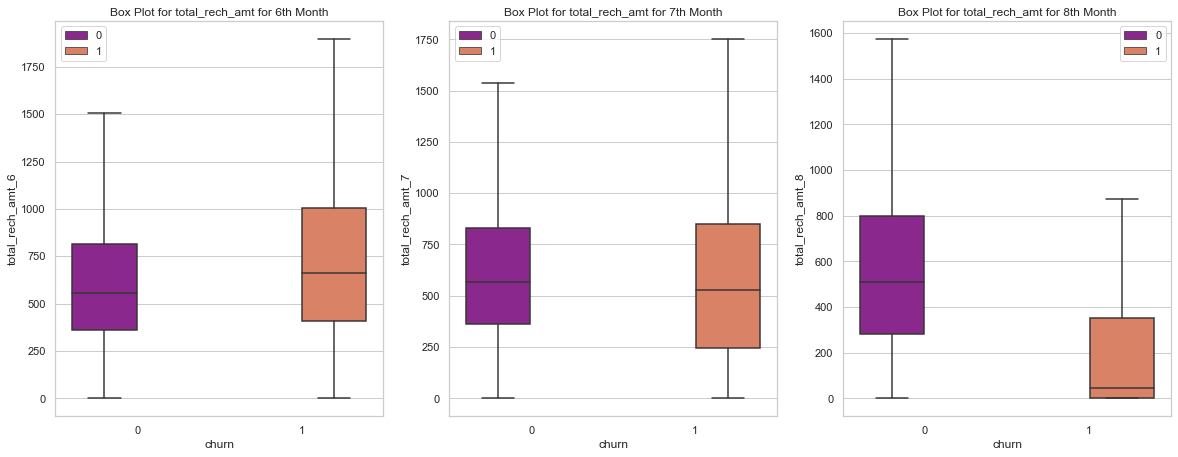

In [45]:
#### Plotting boxplot for each of the above following:

plot_box_chart('total_rech_amt')

#### Inference from above:
- In action phase, there is a decline in recharge amount among churned customers

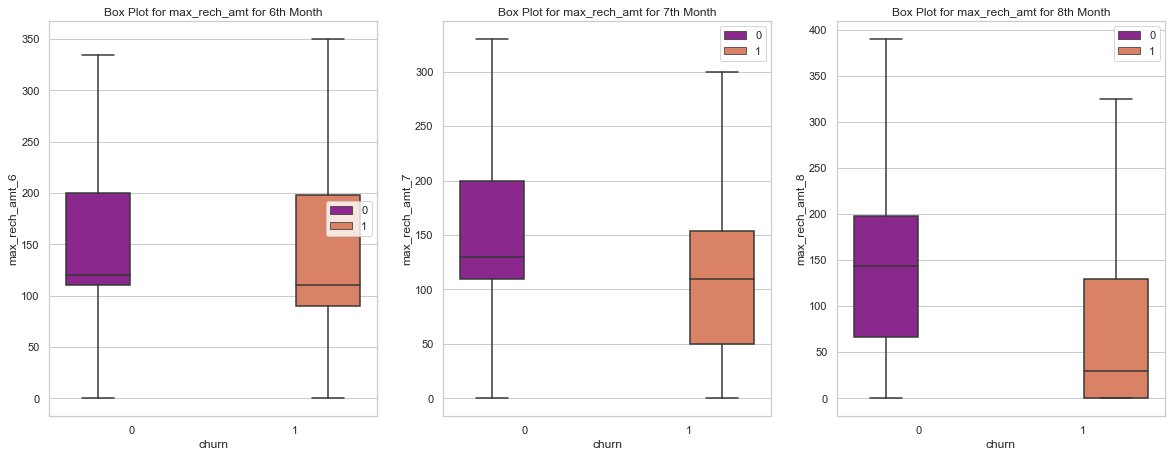

In [46]:
plot_box_chart('max_rech_amt')

#### Inference from above:
- In action phase, there is a decline in maximum recharge amount among churned customers

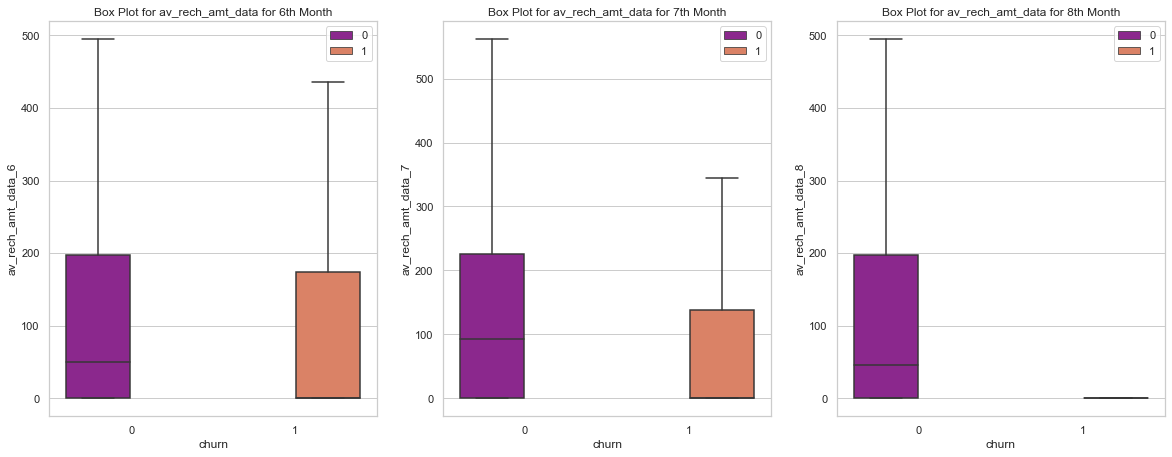

In [47]:
plot_box_chart('av_rech_amt_data')

#### Inference from above:
- In action phase, avg rechagre amount is almost close to 0 when it comes to recharging for data which is a huge decline among churned customers

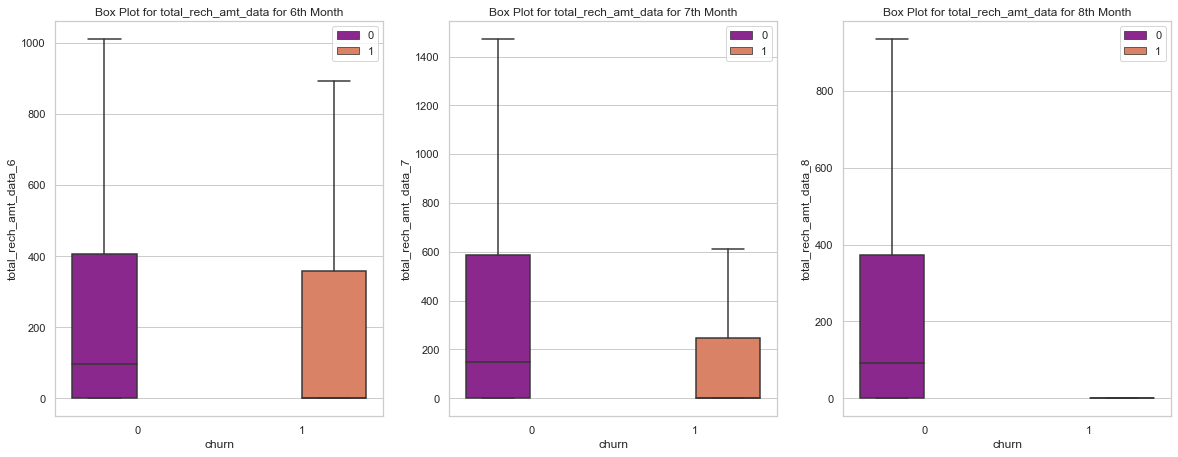

In [48]:
plot_box_chart('total_rech_amt_data')

#### Inference from above:
- In action phase, for total rechagre amount for data there is a huge decline among churned customers

### Step 3.2.2: Analysis other set of recharge related variables

In [49]:
other_rch = df_telecom_high_val_cust.columns[df_telecom_high_val_cust.columns.str.contains('rech_num|max_rech_data', regex = True)]

In [50]:
other_rch

Index(['total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8',
       'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8'],
      dtype='object')

In [51]:
### Checking for the percentage of null values among above identified variables

round(100*df_telecom_high_val_cust.loc[:,other_rch].isnull().sum()/len(df_telecom_high_val_cust))

total_rech_num_6                   0.00
total_rech_num_7                   0.00
total_rech_num_8                   0.00
max_rech_data_6                   44.00
max_rech_data_7                   43.00
max_rech_data_8                   47.00
dtype: float64

In [52]:
### max rech data related cols have above 43% of NULL values. Will look to impute these values

df_telecom_high_val_cust[['max_rech_data_6','max_rech_data_7','max_rech_data_8']].describe()

,max_rech_data_6,max_rech_data_7,max_rech_data_8
count,"16,740.00","17,038.00","15,935.00"
mean,139.80,140.44,136.35
std,118.89,120.30,119.57
min,1.00,1.00,1.00
25%,25.00,25.00,25.00
50%,152.00,152.00,152.00
75%,198.00,198.00,198.00
max,"1,555.00","1,555.00","1,555.00"


> <span style='color:green'>**Analysis:** The missing values show here that recharge was not done for that month hence there are null values. So we will impute null values for such columns with 0.

In [53]:
df_telecom_high_val_cust[['max_rech_data_6','max_rech_data_7','max_rech_data_8']]= df_telecom_high_val_cust[['max_rech_data_6','max_rech_data_7','max_rech_data_8']].replace(np.nan,0)

In [54]:
round(100*df_telecom_high_val_cust.loc[:,other_rch].isnull().sum()/len(df_telecom_high_val_cust))

total_rech_num_6                   0.00
total_rech_num_7                   0.00
total_rech_num_8                   0.00
max_rech_data_6                    0.00
max_rech_data_7                    0.00
max_rech_data_8                    0.00
dtype: float64

- Imputation is complete and we dont have any more null values

#### Plotting boxplots to see the trend of recharges among churn and non churn customers on each 6,7 and 8th month

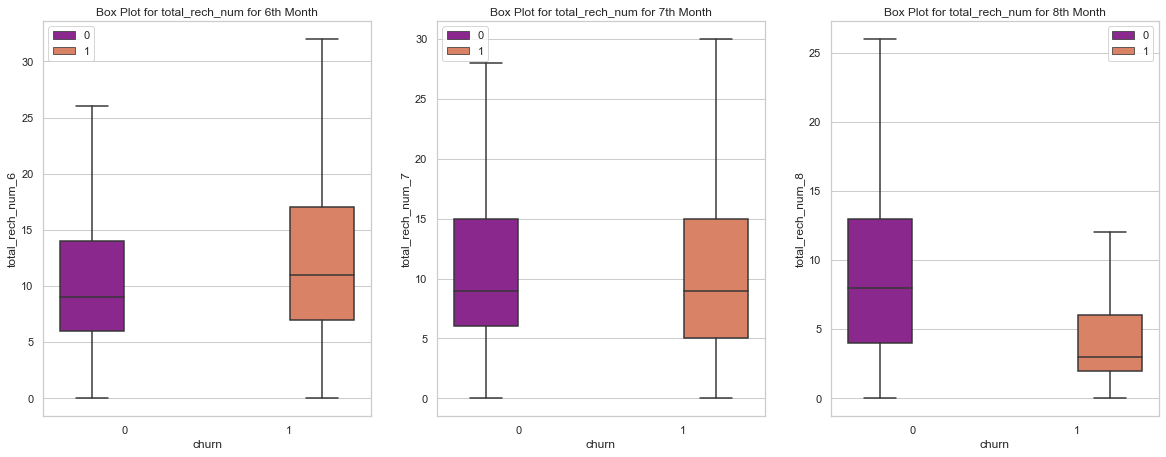

In [55]:
plot_box_chart('total_rech_num')

> <span style='color:green'>**Analysis:** We can see that there is a huge drop in total recharge number also in the 8th month (action phase) for churned customers.

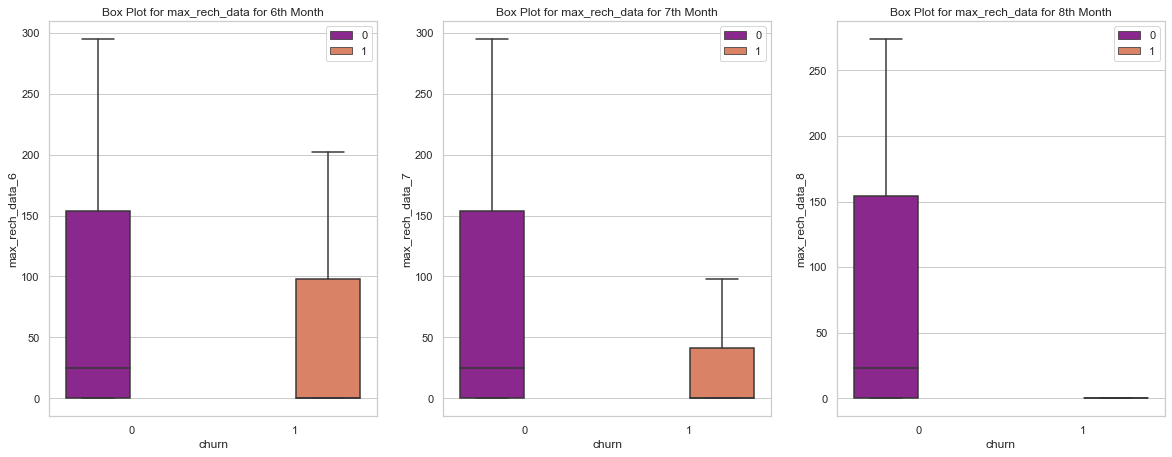

In [56]:
# Ploting for maximum recharge for data:
plot_box_chart('max_rech_data')

> <span style='color:green'>**Analysis:** We can see that there is a huge drop in maximum recharge for data also in the 8th month (action phase) for churned customers.

### Step 3.2.3: Analysing last day recharge variables by plotting graphs

In [57]:
### Fetch last day recharge amount columns
last_day_rech_amt = df_telecom_high_val_cust.columns[df_telecom_high_val_cust.columns.str.contains('day')]

In [58]:
last_day_rech_amt

Index(['last_day_rch_amt_6', 'last_day_rch_amt_7', 'last_day_rch_amt_8'], dtype='object')

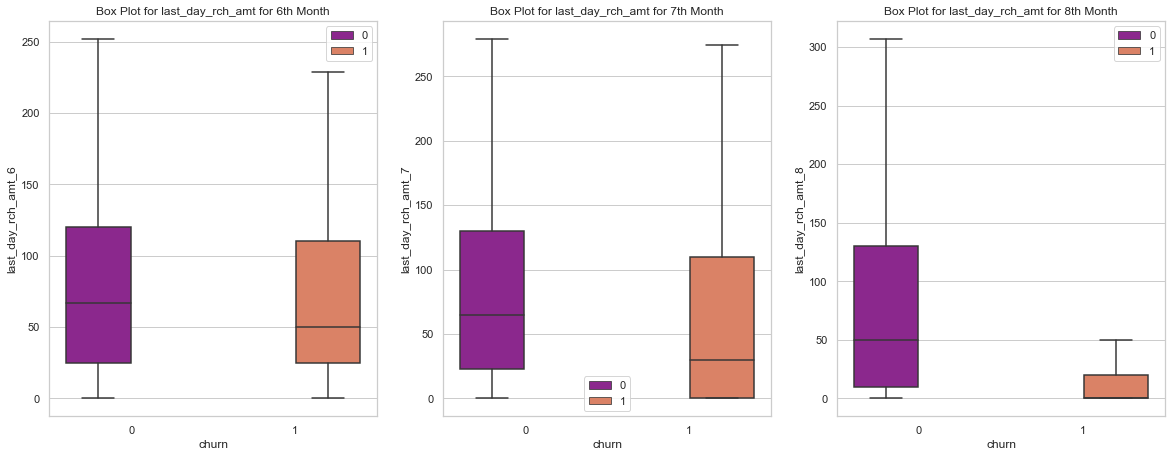

In [59]:
# Ploting for last day recharge amount:
plot_box_chart('last_day_rch_amt')

> <span style='color:green'>**Analysis:** We can see that there is a huge drop in maximum recharge for data also in the 8th month (action phase) for churned customers.

### Step 3.2.3: Analysing 2G/3G related variables by plotting graphs

In [60]:
col_2g_3g = df_telecom_high_val_cust.columns[df_telecom_high_val_cust.columns.str.contains('2g|3g',regex=True)]

In [61]:
len(col_2g_3g)

34

> <span style='color:green'>**Analysis:**There are 34 columns related to 2g and 3g data. Checking the percentage of null values in these 34 variables

In [62]:
round(100*df_telecom_high_val_cust[col_2g_3g].isnull().sum()/len(df_telecom_high_val_cust),2).sort_values(ascending = False)

arpu_2g_8                        46.80
count_rech_2g_8                  46.80
count_rech_3g_8                  46.80
arpu_3g_8                        46.80
count_rech_2g_6                  44.11
count_rech_3g_6                  44.11
arpu_3g_6                        44.11
arpu_2g_6                        44.11
count_rech_2g_7                  43.12
count_rech_3g_7                  43.12
arpu_3g_7                        43.12
arpu_2g_7                        43.12
sachet_2g_6                       0.00
monthly_2g_8                      0.00
jul_vbc_3g                        0.00
aug_vbc_3g                        0.00
sachet_3g_8                       0.00
sachet_3g_7                       0.00
sachet_3g_6                       0.00
vol_2g_mb_6                       0.00
vol_2g_mb_7                       0.00
vol_2g_mb_8                       0.00
vol_3g_mb_6                       0.00
vol_3g_mb_7                       0.00
vol_3g_mb_8                       0.00
monthly_3g_8             

> <span style='color:green'>**Analysis:** We are getting more then 43% values that are not available for count of recharge and average revenue for 2G/3G per user. 
Although we have 2G/3G volume usage based data available, we can drop these columns.

In [63]:
df_telecom_high_val_cust.drop(['count_rech_2g_6','count_rech_2g_7',
              'count_rech_2g_8','count_rech_3g_6','count_rech_3g_7','count_rech_3g_8'
               ,'arpu_3g_6','arpu_3g_7','arpu_3g_8','arpu_2g_6','arpu_2g_7','arpu_2g_8'],axis=1,inplace=True)

In [64]:
df_telecom_high_val_cust.head()

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,total_rech_amt_data_6,total_rech_amt_data_7,total_rech_amt_data_8,tot_avg_rech_amnt_Gud_Phase,churn
0,7000842753,197.38,214.82,213.80,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,0.00,0.00,0.00,nan,nan,0.16,nan,nan,4.13,nan,nan,1.15,nan,nan,5.44,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,0.00,0.00,5.44,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,4,3,2,362,252,252,252,252,252,6/21/2014,7/16/2014,8/8/2014,252,252,252,6/21/2014,7/16/2014,8/8/2014,1.00,1.00,1.00,252.00,252.00,252.00,252.00,252.00,252.00,30.13,1.32,5.75,83.57,150.76,109.61,0.00,0.00,0.00,0,0,0,0,0,0,1,1,1,0,0,0,1.00,1.00,1.00,968,30.40,0.00,101.20,3.58,252.00,252.00,252.00,559.00,1
7,7000701601,"1,069.18","1,349.85","3,171.48",57.84,54.68,52.29,453.43,567.16,325.91,16.23,33.49,31.64,23.74,12.59,38.06,51.39,31.38,40.28,308.63,447.38,162.28,62.13,55.14,53.23,0.00,0.00,0.00,422.16,533.91,255.79,4.30,23.29,12.01,49.89,31.76,49.14,6.66,20.08,16.68,60.86,75.14,77.84,0.00,0.18,10.01,4.50,0.00,6.50,0.00,0.00,0.00,487.53,609.24,350.16,58.14,32.26,27.31,217.56,221.49,121.19,152.16,101.46,39.53,427.88,355.23,188.04,36.89,11.83,30.39,91.44,126.99,141.33,52.19,34.24,22.21,180.54,173.08,193.94,626.46,558.04,428.74,0.21,0.00,0.00,2.06,14.53,31.59,15.74,15.19,15.14,5,5,7,1580,790,3638,1580,790,1580,6/27/2014,7/25/2014,8/26/2014,0,0,779,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,nan,nan,nan,0,0,0,0,0,0,0,0,0,0,0,0,nan,nan,nan,802,57.74,19.38,18.74,0.00,0.00,0.00,0.00,"1,185.00",1
8,7001524846,378.72,492.22,137.36,413.69,351.03,35.08,94.66,80.63,136.48,0.00,0.00,0.00,0.00,0.00,0.00,297.13,217.59,12.49,80.96,70.58,50.54,0.00,0.00,0.00,0.0

In [65]:
df_telecom_high_val_cust.shape

(29953, 152)

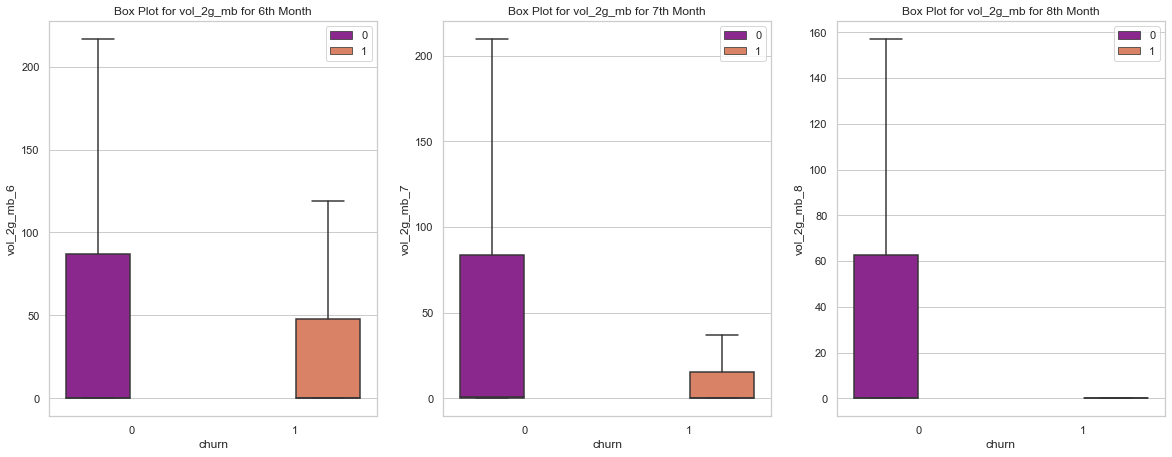

In [66]:
# Ploting graphs for volume of 2G and 3G usage columns:

plot_box_chart('vol_2g_mb')

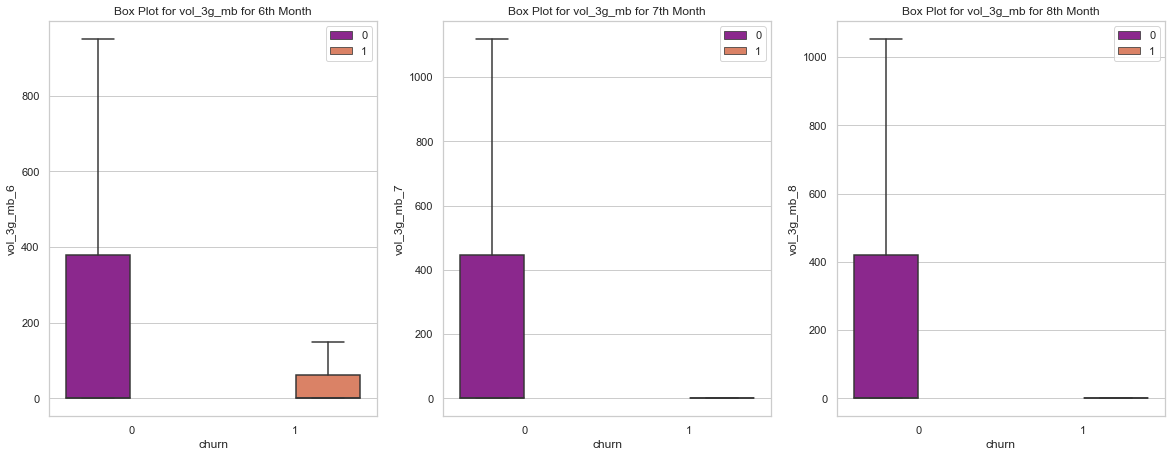

In [67]:
plot_box_chart('vol_3g_mb')

> <span style='color:green'>**Inferences:** THe data volume usage for 2G/3G sees a huge dip among churned customers in 8th month.

#### Checking for percentage of Null values

In [68]:
col_monthly_2g_3g = ['monthly_2g_6','monthly_2g_7','monthly_2g_8','monthly_3g_6','monthly_3g_7','monthly_3g_8']

In [69]:
col_monthly_2g_3g

['monthly_2g_6',
 'monthly_2g_7',
 'monthly_2g_8',
 'monthly_3g_6',
 'monthly_3g_7',
 'monthly_3g_8']

In [70]:
df_telecom_high_val_cust[col_monthly_2g_3g].isnull().sum()/len(df_telecom_high_val_cust)

monthly_2g_6                   0.00
monthly_2g_7                   0.00
monthly_2g_8                   0.00
monthly_3g_6                   0.00
monthly_3g_7                   0.00
monthly_3g_8                   0.00
dtype: float64

> <span style='color:green'>**Inferences:**There are no null values

#### Plotting graphs

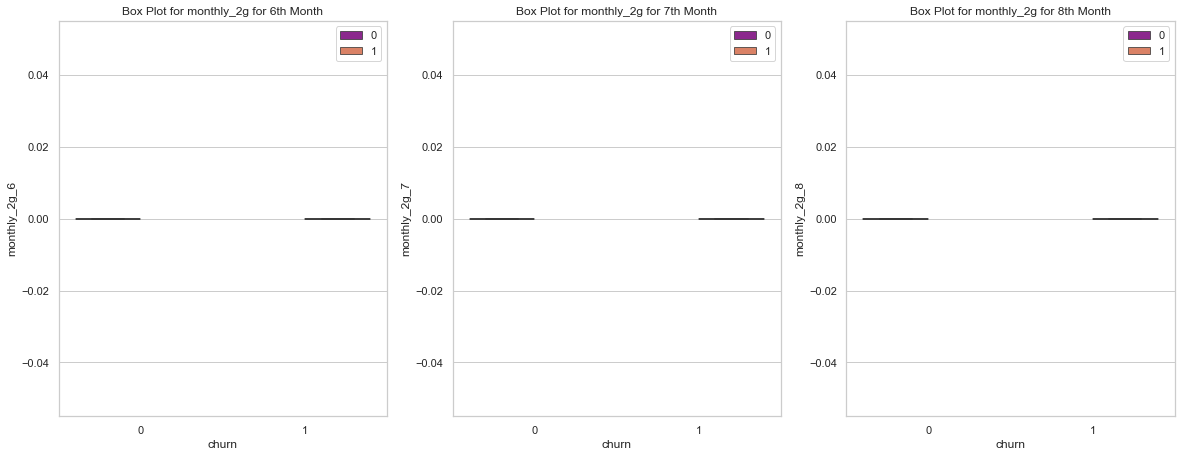

In [71]:
plot_box_chart('monthly_2g')

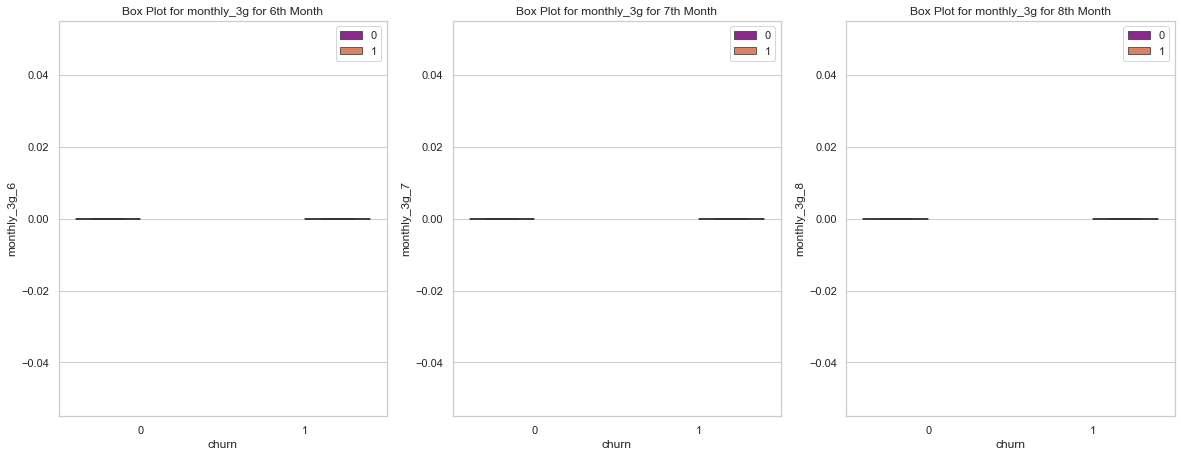

In [72]:
plot_box_chart('monthly_3g')

#### Since the range is very low, we will take the mean of the data and check

In [73]:
def plot_mean_bar_chart(df,columns_list):
    df_0 = df[df.churn==0].filter(columns_list)
    df_1 = df[df.churn==1].filter(columns_list)

    mean_df_0 = pd.DataFrame([df_0.mean()],index={'Non Churn'})
    mean_df_1 = pd.DataFrame([df_1.mean()],index={'Churn'})

    temp = [mean_df_0, mean_df_1]
    mean_combined = pd.concat(temp)

    mean_combined.T.plot.bar(figsize=(10,5),rot=0)
    plt.show()
    
    return mean_combined

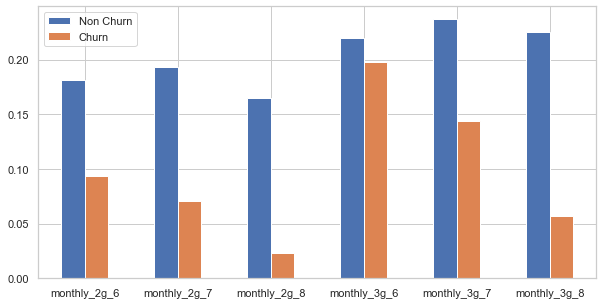

,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8
Non Churn,0.18,0.19,0.17,0.22,0.24,0.22
Churn,0.09,0.07,0.02,0.20,0.14,0.06


In [74]:
plot_mean_bar_chart(df_telecom_high_val_cust, col_monthly_2g_3g)

> <span style='color:green'>**Inferences:** From the above plot, it is visible that we have decreasing trend among churned customers and it is lowest in 8th month

#### Analysing VBC columns

In [75]:
# let's check Volume based cost 

vbc_column = df_telecom_high_val_cust.columns[df_telecom_high_val_cust.columns.str.contains('vbc_',regex=True)]
vbc_column.tolist()

['aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'sep_vbc_3g']

In [76]:
# Renaming month named vbc columns to change the format so that our box plot function and return the plots without change in code
df_telecom_high_val_cust.rename(columns={'jun_vbc_3g':'vbc_3g_6','jul_vbc_3g':'vbc_3g_7','aug_vbc_3g':'vbc_3g_8'
                         ,'sep_vbc_3g':'vbc_3g_9'}, inplace=True)

# drop 9th month column as it is not needed
df_telecom_high_val_cust.drop('vbc_3g_9',axis=1,inplace=True)

In [77]:
df_telecom_high_val_cust.head()

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,vbc_3g_8,vbc_3g_7,vbc_3g_6,total_rech_amt_data_6,total_rech_amt_data_7,total_rech_amt_data_8,tot_avg_rech_amnt_Gud_Phase,churn
0,7000842753,197.38,214.82,213.80,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,0.00,0.00,0.00,nan,nan,0.16,nan,nan,4.13,nan,nan,1.15,nan,nan,5.44,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,0.00,0.00,5.44,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,4,3,2,362,252,252,252,252,252,6/21/2014,7/16/2014,8/8/2014,252,252,252,6/21/2014,7/16/2014,8/8/2014,1.00,1.00,1.00,252.00,252.00,252.00,252.00,252.00,252.00,30.13,1.32,5.75,83.57,150.76,109.61,0.00,0.00,0.00,0,0,0,0,0,0,1,1,1,0,0,0,1.00,1.00,1.00,968,30.40,0.00,101.20,252.00,252.00,252.00,559.00,1
7,7000701601,"1,069.18","1,349.85","3,171.48",57.84,54.68,52.29,453.43,567.16,325.91,16.23,33.49,31.64,23.74,12.59,38.06,51.39,31.38,40.28,308.63,447.38,162.28,62.13,55.14,53.23,0.00,0.00,0.00,422.16,533.91,255.79,4.30,23.29,12.01,49.89,31.76,49.14,6.66,20.08,16.68,60.86,75.14,77.84,0.00,0.18,10.01,4.50,0.00,6.50,0.00,0.00,0.00,487.53,609.24,350.16,58.14,32.26,27.31,217.56,221.49,121.19,152.16,101.46,39.53,427.88,355.23,188.04,36.89,11.83,30.39,91.44,126.99,141.33,52.19,34.24,22.21,180.54,173.08,193.94,626.46,558.04,428.74,0.21,0.00,0.00,2.06,14.53,31.59,15.74,15.19,15.14,5,5,7,1580,790,3638,1580,790,1580,6/27/2014,7/25/2014,8/26/2014,0,0,779,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,nan,nan,nan,0,0,0,0,0,0,0,0,0,0,0,0,nan,nan,nan,802,57.74,19.38,18.74,0.00,0.00,0.00,"1,185.00",1
8,7001524846,378.72,492.22,137.36,413.69,351.03,35.08,94.66,80.63,136.48,0.00,0.00,0.00,0.00,0.00,0.00,297.13,217.59,12.49,80.96,70.58,50.54,0.00,0.00,0.00,0.00,0.00,7.15,378.09,288.18,6

In [78]:
#### dropping the unwanted column from vbc_column 

vbc_column = vbc_column.drop('sep_vbc_3g')

In [79]:
vbc_column = df_telecom_high_val_cust.columns[df_telecom_high_val_cust.columns.str.contains('vbc_3g',regex=True)]
vbc_column.tolist()

['vbc_3g_8', 'vbc_3g_7', 'vbc_3g_6']

In [80]:
vbc_column

Index(['vbc_3g_8', 'vbc_3g_7', 'vbc_3g_6'], dtype='object')

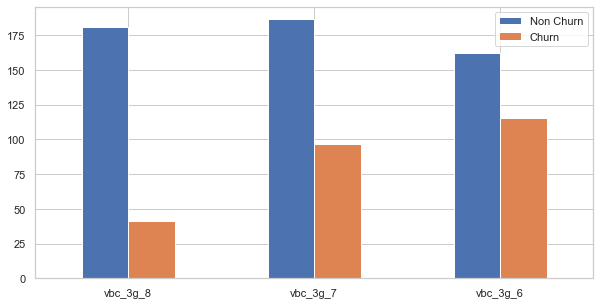

,vbc_3g_8,vbc_3g_7,vbc_3g_6
Non Churn,180.62,186.37,162.56
Churn,40.94,96.34,115.46


In [81]:
#### Plotting bar charts

plot_mean_bar_chart(df_telecom_high_val_cust, vbc_column)

> <span style='color:green'>**Analysis:** It can be seen that volume based cost for 3G is much lower for Churned customers as compared to Non-Churned Customers and also there is a drop in vbc in 8th month

In [82]:
# analysing Service schemes with validity smaller than a month for 2G/3G

col_sacht_2g_3g = df_telecom_high_val_cust.columns[df_telecom_high_val_cust.columns.str.contains('sachet_2g|sachet_3g',regex=True)]
col_sacht_2g_3g

Index(['sachet_2g_6', 'sachet_2g_7', 'sachet_2g_8', 'sachet_3g_6',
       'sachet_3g_7', 'sachet_3g_8'],
      dtype='object')

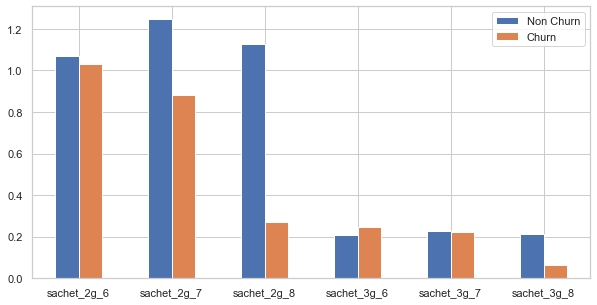

,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8
Non Churn,1.07,1.25,1.13,0.21,0.23,0.21
Churn,1.03,0.88,0.27,0.24,0.22,0.07


In [83]:
plot_mean_bar_chart(df_telecom_high_val_cust, col_sacht_2g_3g)

> <span style='color:green'>**Analysis:** Again we can see a downward trend among Churned customers and it is lowest in 8th month for both 2g and 3g users

### Analysing Average Revenue variables

In [84]:
col_arpu = df_telecom_high_val_cust.columns[df_telecom_high_val_cust.columns.str.contains('arpu_')]
col_arpu

Index(['arpu_6', 'arpu_7', 'arpu_8'], dtype='object')

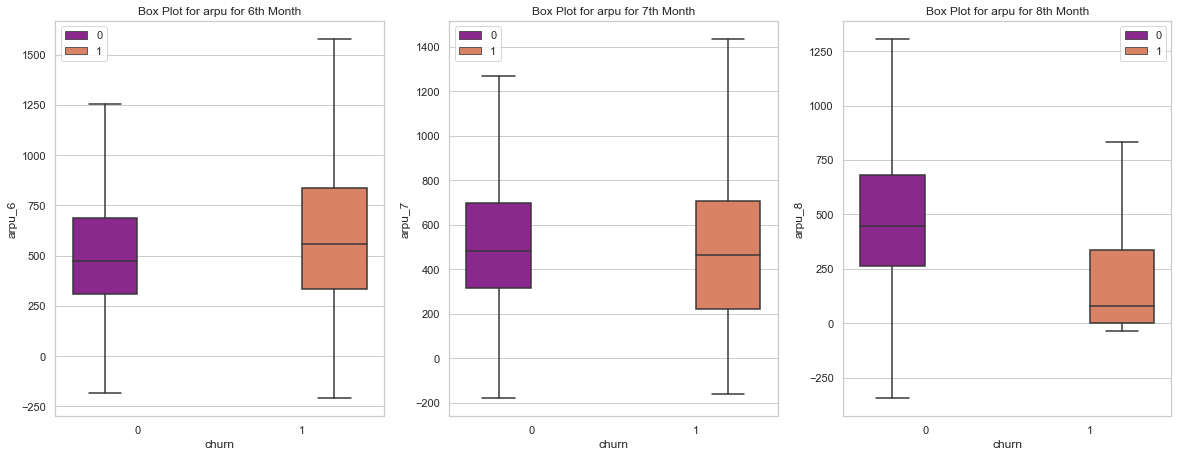

In [85]:
plot_box_chart('arpu')

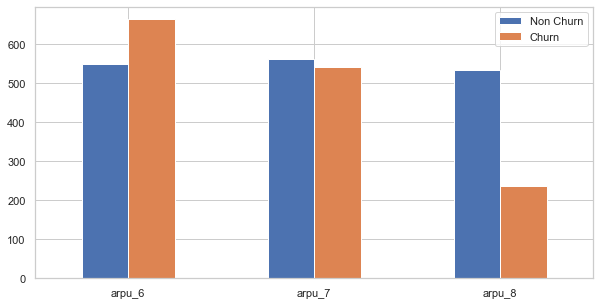

,arpu_6,arpu_7,arpu_8
Non Churn,549.55,562.93,532.87
Churn,663.71,541.15,237.66


In [86]:
plot_mean_bar_chart(df_telecom_high_val_cust, col_arpu)

> <span style='color:green'>**Inferences from above:** During good phase, we can see that average revenue is good among churned customers, but as we enter into action phase, theres decline in the ARPU values

### Step 3.2.4: Analysing Minutes of Usage (MOU) related variables

In [87]:
mou_cols = df_telecom_high_val_cust.columns[df_telecom_high_val_cust.columns.str.contains('mou')]

In [88]:
len(mou_cols)

81

In [89]:
mou_cols

Index(['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7',
       'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8',
       'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8',
       'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8',
       'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8',
       'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8',
       'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6',
       'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6',
       'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6',
       'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_mou_6', 'std_og_mou_7',
       'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8',
       'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'total_og_mou_6',
       'total_og_mou_7', 'total_og_mou_8', 'loc_ic_t2t_mou_6',
       'loc_ic_t2t_mo

#### Performing NULL percentage analysis

In [90]:
round(100*df_telecom_high_val_cust[mou_cols].isnull().sum()/len(df_telecom_high_val_cust),2).sort_values(ascending = False)

isd_ic_mou_8                       3.91
loc_og_t2m_mou_8                   3.91
spl_og_mou_8                       3.91
std_og_mou_8                       3.91
std_og_t2f_mou_8                   3.91
std_og_t2m_mou_8                   3.91
loc_ic_t2t_mou_8                   3.91
std_og_t2t_mou_8                   3.91
loc_ic_t2m_mou_8                   3.91
loc_og_mou_8                       3.91
loc_ic_t2f_mou_8                   3.91
loc_og_t2c_mou_8                   3.91
loc_ic_mou_8                       3.91
isd_og_mou_8                       3.91
std_ic_t2t_mou_8                   3.91
loc_og_t2f_mou_8                   3.91
std_ic_t2m_mou_8                   3.91
onnet_mou_8                        3.91
loc_og_t2t_mou_8                   3.91
spl_ic_mou_8                       3.91
std_ic_t2f_mou_8                   3.91
roam_og_mou_8                      3.91
std_ic_mou_8                       3.91
offnet_mou_8                       3.91
roam_ic_mou_8                      3.91


> <span style='color:green'>**Inferences from above:** So for all minutes of usage columns the maximum missing % is 3.91 , means in these case the customer has not been used at all for that particular call type, thus we can fill the missing values with 0

In [91]:
# replaceing null values by 0 for minutes of usage variables

df_telecom_high_val_cust[mou_cols] = df_telecom_high_val_cust[mou_cols].replace(np.NaN,0)

In [92]:
round(100*df_telecom_high_val_cust[mou_cols].isnull().sum()/len(df_telecom_high_val_cust),2).sort_values(ascending = False)

isd_ic_mou_8                       0.00
isd_og_mou_6                       0.00
loc_og_t2c_mou_6                   0.00
loc_og_t2c_mou_7                   0.00
loc_og_t2c_mou_8                   0.00
loc_og_mou_6                       0.00
loc_og_mou_7                       0.00
loc_og_mou_8                       0.00
std_og_t2t_mou_6                   0.00
std_og_t2t_mou_7                   0.00
std_og_t2t_mou_8                   0.00
std_og_t2m_mou_6                   0.00
std_og_t2m_mou_7                   0.00
std_og_t2m_mou_8                   0.00
std_og_t2f_mou_6                   0.00
std_og_t2f_mou_7                   0.00
std_og_t2f_mou_8                   0.00
std_og_mou_6                       0.00
std_og_mou_7                       0.00
loc_og_t2f_mou_8                   0.00
loc_og_t2f_mou_7                   0.00
loc_og_t2f_mou_6                   0.00
roam_ic_mou_8                      0.00
onnet_mou_7                        0.00
onnet_mou_8                        0.00


> <span style='color:green'>**Inferences:**  Now, we will take subset from the above list of MOU related variables and anlayse them. Firstly, Outgoing related variables

In [93]:
col_mou_og6 = df_telecom_high_val_cust.columns[df_telecom_high_val_cust.columns.str.contains('.*_og_.*mou_6',regex=True)]

In [94]:
col_mou_og6

Index(['roam_og_mou_6', 'loc_og_t2t_mou_6', 'loc_og_t2m_mou_6',
       'loc_og_t2f_mou_6', 'loc_og_t2c_mou_6', 'loc_og_mou_6',
       'std_og_t2t_mou_6', 'std_og_t2m_mou_6', 'std_og_t2f_mou_6',
       'std_og_mou_6', 'isd_og_mou_6', 'spl_og_mou_6', 'total_og_mou_6'],
      dtype='object')

In [95]:
df_telecom_high_val_cust[col_mou_og6].describe()

,roam_og_mou_6,loc_og_t2t_mou_6,loc_og_t2m_mou_6,loc_og_t2f_mou_6,loc_og_t2c_mou_6,loc_og_mou_6,std_og_t2t_mou_6,std_og_t2m_mou_6,std_og_t2f_mou_6,std_og_mou_6,isd_og_mou_6,spl_og_mou_6,total_og_mou_6
count,"29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00"
mean,26.60,84.57,163.31,6.35,1.58,254.24,165.90,179.44,1.81,347.15,2.17,5.83,610.06
std,116.27,228.96,250.22,22.14,6.31,378.55,403.99,409.14,11.99,608.85,45.89,17.58,691.18
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,4.38,19.21,0.00,0.00,32.26,0.00,0.00,0.00,0.40,0.00,0.00,116.64
50%,0.00,24.36,77.26,0.00,0.00,124.59,2.71,16.36,0.00,45.08,0.00,0.23,410.63
75%,0.00,78.06,209.03,4.23,0.00,332.31,109.56,154.54,0.00,465.29,0.00,5.21,859.03
max,"3,775.11","6,431.33","4,729.74","1,466.03",271.44,"10,643.38","7,366.58","8,314.76",628.56,"8,432.99","5,900.66","1,023.21","10,674.03"


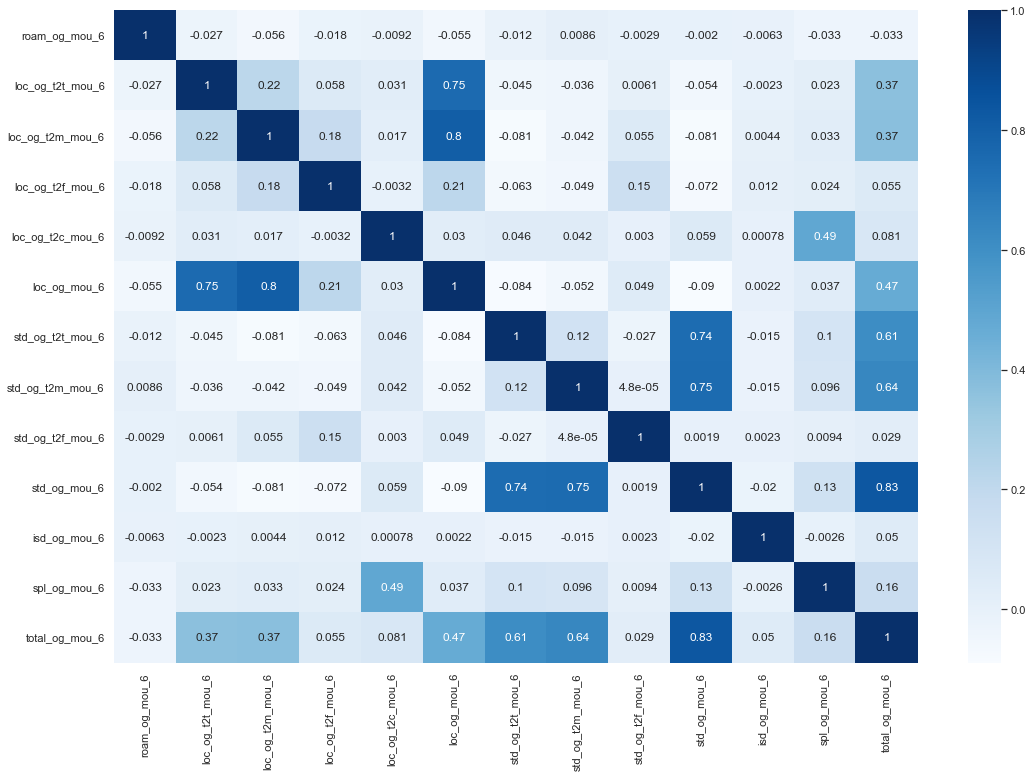

In [96]:
### using heatmap plotting function created above, we will plot the heatmap

heatmap(18,12,df_telecom_high_val_cust.filter(col_mou_og6))

> <span style='color:green'>**Analysis:** We can see that total_og_mou_6, std_og_mou_6 and loc_og_mou_6 seems to have strong correlation with other fileds and they needs to be inspected to avoid any multicolinearity issues.

In [97]:
df_telecom_high_val_cust.columns[df_telecom_high_val_cust.columns.str.contains('std_*', regex=True)]

Index(['std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8',
       'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8',
       'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8',
       'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 'std_ic_t2t_mou_6',
       'std_ic_t2t_mou_7', 'std_ic_t2t_mou_8', 'std_ic_t2m_mou_6',
       'std_ic_t2m_mou_7', 'std_ic_t2m_mou_8', 'std_ic_t2f_mou_6',
       'std_ic_t2f_mou_7', 'std_ic_t2f_mou_8', 'std_ic_mou_6', 'std_ic_mou_7',
       'std_ic_mou_8'],
      dtype='object')

In [98]:
print(df_telecom_high_val_cust.loc[8,'total_og_mou_6'],"==",df_telecom_high_val_cust.loc[8,['loc_og_mou_6','std_og_mou_6','spl_og_mou_6','isd_og_mou_6','og_others_6']].sum())
print(df_telecom_high_val_cust.loc[8,'std_og_mou_6'],"==",df_telecom_high_val_cust.loc[8,['std_og_t2m_mou_6','std_og_t2t_mou_6','std_og_t2f_mou_6']].sum())
print(df_telecom_high_val_cust.loc[8,'loc_og_mou_6'],"==",df_telecom_high_val_cust.loc[8,['loc_og_t2m_mou_6','loc_og_t2t_mou_6','loc_og_t2f_mou_6']].sum())

508.36 == 508.34999999999997
130.26 == 130.25
378.09 == 378.09


> <span style='color:green'>**Analysis:** We can see that total_og_mou_6, std_og_mou_6 and loc_og_mou_6 is a combination of other variables present in dataset.So we can remove these columns for all months from the data set

In [99]:
list_total_og_cols = df_telecom_high_val_cust.columns[df_telecom_high_val_cust.columns.str.contains('total_og_mou|std_og_mou|loc_og_mou',regex=True)]
df_telecom_high_val_cust.drop(list_total_og_cols,axis=1,inplace=True)
log("Columns dropped - ")
list_total_og_cols.tolist()

> <span style='color:green'>Columns dropped - </span>

['loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'std_og_mou_6',
 'std_og_mou_7',
 'std_og_mou_8',
 'total_og_mou_6',
 'total_og_mou_7',
 'total_og_mou_8']

> <span style='color:green'>**Firstly, analysing Outgoing related variables Incoming related variables**

In [100]:
mou_ic_cols6 = df_telecom_high_val_cust.columns[df_telecom_high_val_cust.columns.str.contains('.*_ic_.*mou_6',regex=True)]

In [101]:
df_telecom_high_val_cust[mou_ic_cols6].describe()

,roam_ic_mou_6,loc_ic_t2t_mou_6,loc_ic_t2m_mou_6,loc_ic_t2f_mou_6,loc_ic_mou_6,std_ic_t2t_mou_6,std_ic_t2m_mou_6,std_ic_t2f_mou_6,std_ic_mou_6,total_ic_mou_6,spl_ic_mou_6,isd_ic_mou_6
count,"29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00"
mean,16.12,65.51,150.47,15.29,231.28,14.90,29.21,2.70,46.81,290.12,0.06,10.80
std,76.34,163.86,219.32,45.79,315.01,77.75,98.28,19.11,137.60,365.74,0.19,76.79
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,6.10,28.09,0.00,47.91,0.00,0.00,0.00,1.03,72.89,0.00,0.00
50%,0.00,25.08,84.11,1.84,134.56,0.38,5.00,0.00,11.41,183.78,0.00,0.00
75%,0.00,67.48,188.74,11.98,297.26,8.19,23.63,0.11,41.49,372.16,0.00,0.00
max,"2,613.31","6,351.44","4,693.86","1,678.41","7,454.63","5,459.56","4,630.23","1,351.11","5,459.63","7,716.14",19.76,"6,789.41"


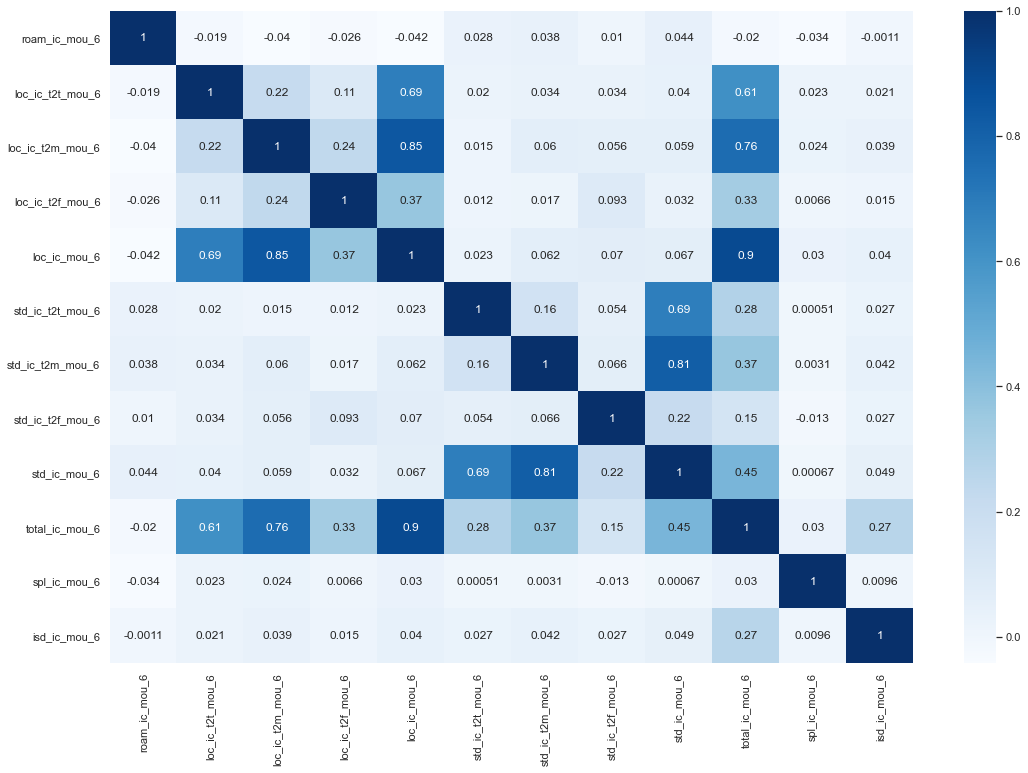

In [102]:
heatmap(18,12,df_telecom_high_val_cust.filter(mou_ic_cols6))

> <span style='color:green'>**Inferences from above:** We can see that total_ic_mou_6, std_ic_mou_6 and loc_ic_mou_6 seems to have strong correlation with other fileds and they needs to be inspected to avoid any multicolinearity issues.

In [103]:
print(df_telecom_high_val_cust.loc[21,'total_ic_mou_6'],"==",df_telecom_high_val_cust.loc[21,['loc_ic_mou_6','roam_ic_mou_6','isd_ic_mou_6','spl_ic_mou_6','std_ic_mou_6']].sum())
print(df_telecom_high_val_cust.loc[21,'loc_ic_mou_6'],"==",df_telecom_high_val_cust.loc[21,['loc_ic_t2t_mou_6','loc_ic_t2m_mou_6','loc_ic_t2f_mou_6']].sum())
print(df_telecom_high_val_cust.loc[21,'std_ic_mou_6'],"==",df_telecom_high_val_cust.loc[21,['std_ic_t2t_mou_6','std_ic_t2m_mou_6','std_ic_t2f_mou_6']].sum())

207.09 == 207.09
125.33 == 125.32000000000001
81.76 == 81.75


> <span style='color:green'>**Analysis:** We can see that total_ic_mou_6, std_ic_mou_6 and loc_ic_mou_6 is a combination of other variables present in dataset.So we can remove these columns for all months from the data set

In [104]:
list_total_ic_cols = df_telecom_high_val_cust.columns[df_telecom_high_val_cust.columns.str.contains('total_ic_mou|std_ic_mou|loc_ic_mou',regex=True)]
df_telecom_high_val_cust.drop(list_total_ic_cols,axis=1,inplace=True)
log("Columns dropped - ")
list_total_ic_cols.tolist()

> <span style='color:green'>Columns dropped - </span>

['loc_ic_mou_6',
 'loc_ic_mou_7',
 'loc_ic_mou_8',
 'std_ic_mou_6',
 'std_ic_mou_7',
 'std_ic_mou_8',
 'total_ic_mou_6',
 'total_ic_mou_7',
 'total_ic_mou_8']

In [105]:
df_telecom_high_val_cust.head()

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,vbc_3g_8,vbc_3g_7,vbc_3g_6,total_rech_amt_data_6,total_rech_amt_data_7,total_rech_amt_data_8,tot_avg_rech_amnt_Gud_Phase,churn
0,7000842753,197.38,214.82,213.80,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,nan,nan,0.00,0.00,0.00,0.16,0.00,0.00,4.13,0.00,0.00,1.15,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,nan,nan,0.00,4,3,2,362,252,252,252,252,252,6/21/2014,7/16/2014,8/8/2014,252,252,252,6/21/2014,7/16/2014,8/8/2014,1.00,1.00,1.00,252.00,252.00,252.00,252.00,252.00,252.00,30.13,1.32,5.75,83.57,150.76,109.61,0.00,0.00,0.00,0,0,0,0,0,0,1,1,1,0,0,0,1.00,1.00,1.00,968,30.40,0.00,101.20,252.00,252.00,252.00,559.00,1
7,7000701601,"1,069.18","1,349.85","3,171.48",57.84,54.68,52.29,453.43,567.16,325.91,16.23,33.49,31.64,23.74,12.59,38.06,51.39,31.38,40.28,308.63,447.38,162.28,62.13,55.14,53.23,0.00,0.00,0.00,4.30,23.29,12.01,49.89,31.76,49.14,6.66,20.08,16.68,0.00,0.18,10.01,4.50,0.00,6.50,0.00,0.00,0.00,58.14,32.26,27.31,217.56,221.49,121.19,152.16,101.46,39.53,36.89,11.83,30.39,91.44,126.99,141.33,52.19,34.24,22.21,0.21,0.00,0.00,2.06,14.53,31.59,15.74,15.19,15.14,5,5,7,1580,790,3638,1580,790,1580,6/27/2014,7/25/2014,8/26/2014,0,0,779,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,nan,nan,nan,0,0,0,0,0,0,0,0,0,0,0,0,nan,nan,nan,802,57.74,19.38,18.74,0.00,0.00,0.00,"1,185.00",1
8,7001524846,378.72,492.22,137.36,413.69,351.03,35.08,94.66,80.63,136.48,0.00,0.00,0.00,0.00,0.00,0.00,297.13,217.59,12.49,80.96,70.58,50.54,0.00,0.00,0.00,0.00,0.00,7.15,116.56,133.43,22.58,13.69,10.04,75.69,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,10.23,0.00,0.00,0.00,23.84,9.84,0.31,57.58,13.98,15.48,0.00,0.00,0.00,0.00,0.58,0.10,22.43,4.08,0.65,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,19,21,14,437,601,120,90,154,30,6/25/2014,7/31/2014,8/30/2014,50,0,10,NaN,7/31/2014,8/23/2014,0.00,2.00,3.00,0.00,154.00,23.00,0.00,177.00,69.00,0.00,356.00,0.03,0.00,750.95,11.94,nan,0.

In [106]:
df_telecom_high_val_cust.shape

(29953, 133)

#### Analysing Variables related to OFFNET

In [107]:
offnet_usage_service_col = df_telecom_high_val_cust.columns[df_telecom_high_val_cust.columns.str.contains('offnet.*mou',regex=True)]

In [108]:
offnet_usage_service_col

Index(['offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8'], dtype='object')

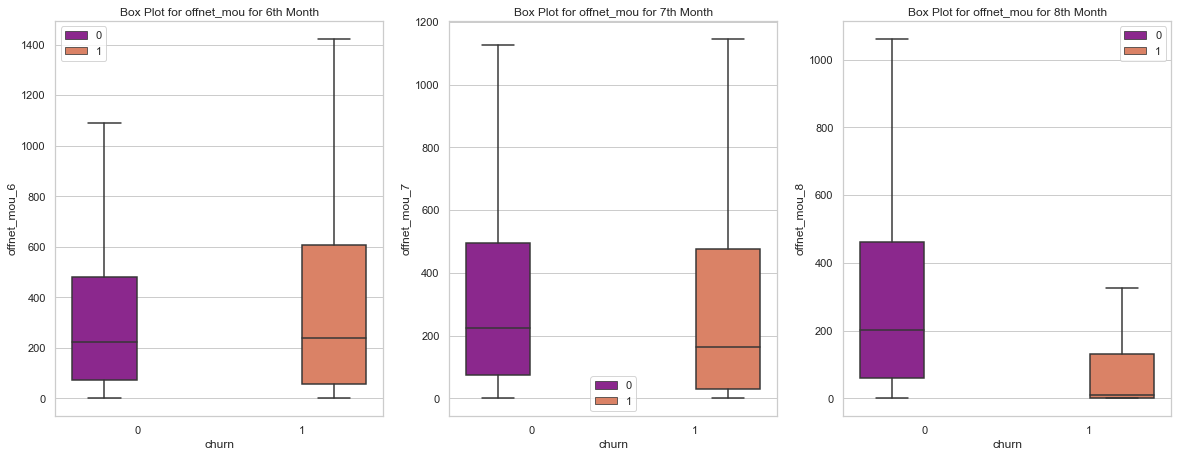

In [109]:
# Offnet mou values for churned and non churned customers
plot_box_chart('offnet_mou')

> <span style='color:green'>**Analysis:** We can see the drop for offnet mou services in the 8th month

> <span style='color:green'>**Analysing Variables related to ONNET**

In [110]:
onnet_usage_service =  df_telecom_high_val_cust.columns[df_telecom_high_val_cust.columns.str.contains('^onnet.*mou',regex=True)]

In [111]:
onnet_usage_service

Index(['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8'], dtype='object')

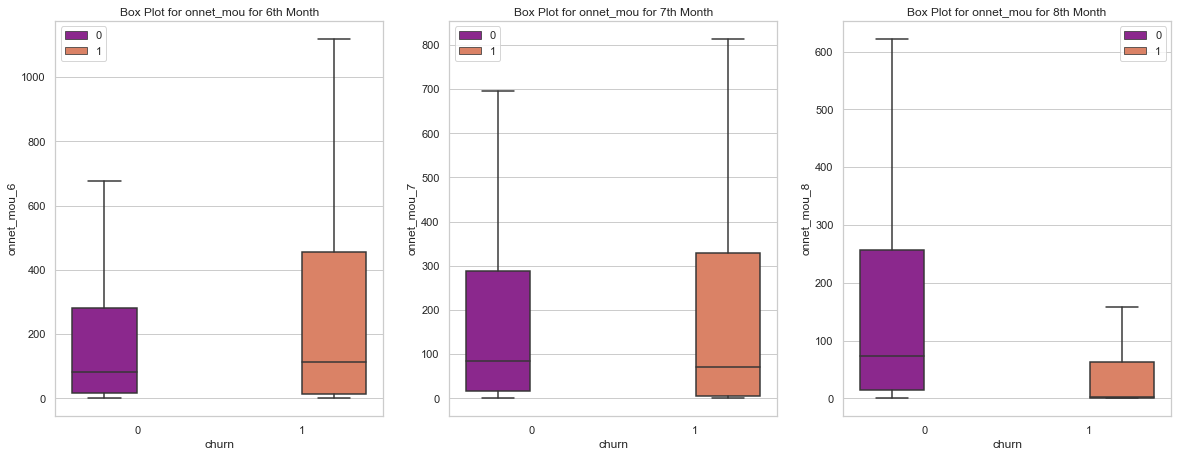

In [112]:
# Plotting onnet
plot_box_chart('onnet_mou')

### Step 3.2.5: Analysing Time period with which customer is associated with network

In [113]:
df_tenure = df_telecom_high_val_cust.copy()

- ##### aon --> Age on network - number of days the customer is using the operator T network

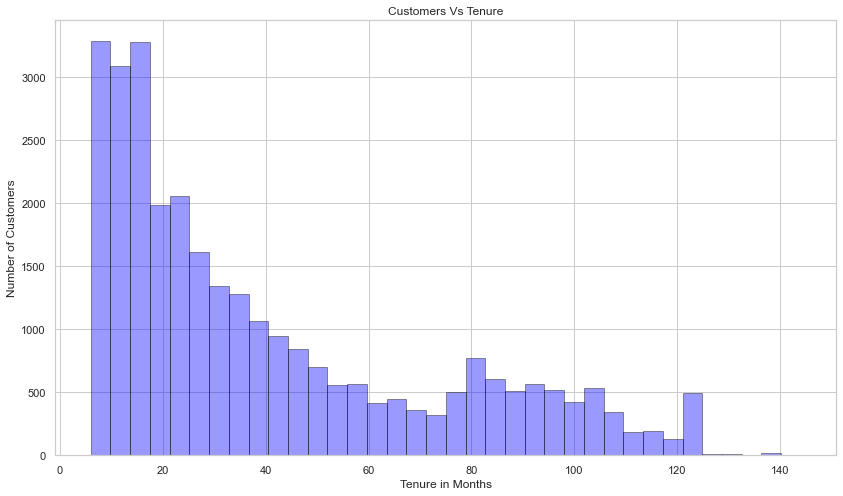

In [114]:
plt.figure(figsize=(14,8))

df_tenure['tenure'] = df_tenure['aon']/30
df_tenure['tenure'].head()
ax = sns.distplot(df_tenure['tenure'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax.set_ylabel('Number of Customers')
ax.set_xlabel('Tenure in Months')
ax.set_title('Customers Vs Tenure')
plt.show()

In [115]:
df_tenure.head()

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,vbc_3g_8,vbc_3g_7,vbc_3g_6,total_rech_amt_data_6,total_rech_amt_data_7,total_rech_amt_data_8,tot_avg_rech_amnt_Gud_Phase,churn,tenure
0,7000842753,197.38,214.82,213.80,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,nan,nan,0.00,0.00,0.00,0.16,0.00,0.00,4.13,0.00,0.00,1.15,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,nan,nan,0.00,4,3,2,362,252,252,252,252,252,6/21/2014,7/16/2014,8/8/2014,252,252,252,6/21/2014,7/16/2014,8/8/2014,1.00,1.00,1.00,252.00,252.00,252.00,252.00,252.00,252.00,30.13,1.32,5.75,83.57,150.76,109.61,0.00,0.00,0.00,0,0,0,0,0,0,1,1,1,0,0,0,1.00,1.00,1.00,968,30.40,0.00,101.20,252.00,252.00,252.00,559.00,1,32.27
7,7000701601,"1,069.18","1,349.85","3,171.48",57.84,54.68,52.29,453.43,567.16,325.91,16.23,33.49,31.64,23.74,12.59,38.06,51.39,31.38,40.28,308.63,447.38,162.28,62.13,55.14,53.23,0.00,0.00,0.00,4.30,23.29,12.01,49.89,31.76,49.14,6.66,20.08,16.68,0.00,0.18,10.01,4.50,0.00,6.50,0.00,0.00,0.00,58.14,32.26,27.31,217.56,221.49,121.19,152.16,101.46,39.53,36.89,11.83,30.39,91.44,126.99,141.33,52.19,34.24,22.21,0.21,0.00,0.00,2.06,14.53,31.59,15.74,15.19,15.14,5,5,7,1580,790,3638,1580,790,1580,6/27/2014,7/25/2014,8/26/2014,0,0,779,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,nan,nan,nan,0,0,0,0,0,0,0,0,0,0,0,0,nan,nan,nan,802,57.74,19.38,18.74,0.00,0.00,0.00,"1,185.00",1,26.73
8,7001524846,378.72,492.22,137.36,413.69,351.03,35.08,94.66,80.63,136.48,0.00,0.00,0.00,0.00,0.00,0.00,297.13,217.59,12.49,80.96,70.58,50.54,0.00,0.00,0.00,0.00,0.00,7.15,116.56,133.43,22.58,13.69,10.04,75.69,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,10.23,0.00,0.00,0.00,23.84,9.84,0.31,57.58,13.98,15.48,0.00,0.00,0.00,0.00,0.58,0.10,22.43,4.08,0.65,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,19,21,14,437,601,120,90,154,30,6/25/2014,7/31/2014,8/30/2014,50,0,10,NaN,7/31/2014,8/23/2014,0.00,2.00,3.00,0.00,154.00,23.00,0.00,177.00,69.00,0.00,356.00,0.03,0.00,

In [116]:
tn_range = [0, 6, 12, 24, 60, 61]
tn_label = [ '0-6 Months', '6-12 Months', '1-2 Yrs', '2-5 Yrs', '5 Yrs and above']
df_tenure['tenure_range'] = pd.cut(df_tenure['tenure'], tn_range, labels=tn_label)

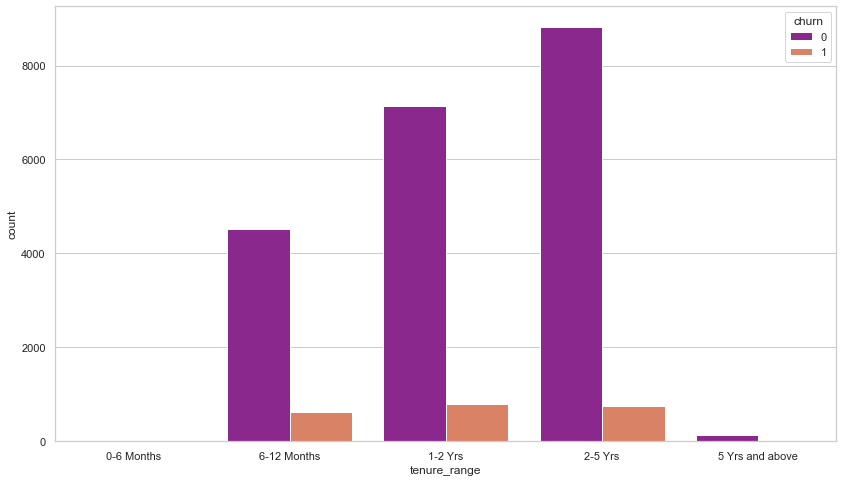

In [117]:
plt.figure(figsize=(14,8))
sns.countplot(x = 'tenure_range', hue = 'churn',data = df_tenure,palette=("plasma"))
plt.show()

### Step 3.3: Dropping columns with NULL values of more than 30%

#### Identifying variables with more than 30% null values in it

In [118]:
meta_df = get_meta_data(df_telecom_high_val_cust)
meta_df = meta_df[meta_df["Null_Percentage"] > 30]
meta_df.sort_values(["Null_Percentage"], axis=0,ascending=False, inplace=True)
col_to_display = ['Null_Percentage']
meta_df[col_to_display]

,Null_Percentage
date_of_last_rech_data_8,46.80
night_pck_user_8,46.80
fb_user_8,46.80
date_of_last_rech_data_6,44.11
night_pck_user_6,44.11
fb_user_6,44.11
date_of_last_rech_data_7,43.12
night_pck_user_7,43.12
fb_user_7,43.12


In [119]:
### Dropping the columns with NULL percentage > 30
drop_null_cols = meta_df.index
df_telecom_high_val_cust.drop(df_telecom_high_val_cust[drop_null_cols],axis=1,inplace=True)

In [120]:
df_telecom_high_val_cust.head()

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,vbc_3g_8,vbc_3g_7,vbc_3g_6,total_rech_amt_data_6,total_rech_amt_data_7,total_rech_amt_data_8,tot_avg_rech_amnt_Gud_Phase,churn
0,7000842753,197.38,214.82,213.80,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,nan,nan,0.00,0.00,0.00,0.16,0.00,0.00,4.13,0.00,0.00,1.15,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,nan,nan,0.00,4,3,2,362,252,252,252,252,252,6/21/2014,7/16/2014,8/8/2014,252,252,252,1.00,1.00,1.00,252.00,252.00,252.00,252.00,252.00,252.00,30.13,1.32,5.75,83.57,150.76,109.61,0,0,0,0,0,0,1,1,1,0,0,0,968,30.40,0.00,101.20,252.00,252.00,252.00,559.00,1
7,7000701601,"1,069.18","1,349.85","3,171.48",57.84,54.68,52.29,453.43,567.16,325.91,16.23,33.49,31.64,23.74,12.59,38.06,51.39,31.38,40.28,308.63,447.38,162.28,62.13,55.14,53.23,0.00,0.00,0.00,4.30,23.29,12.01,49.89,31.76,49.14,6.66,20.08,16.68,0.00,0.18,10.01,4.50,0.00,6.50,0.00,0.00,0.00,58.14,32.26,27.31,217.56,221.49,121.19,152.16,101.46,39.53,36.89,11.83,30.39,91.44,126.99,141.33,52.19,34.24,22.21,0.21,0.00,0.00,2.06,14.53,31.59,15.74,15.19,15.14,5,5,7,1580,790,3638,1580,790,1580,6/27/2014,7/25/2014,8/26/2014,0,0,779,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,802,57.74,19.38,18.74,0.00,0.00,0.00,"1,185.00",1
8,7001524846,378.72,492.22,137.36,413.69,351.03,35.08,94.66,80.63,136.48,0.00,0.00,0.00,0.00,0.00,0.00,297.13,217.59,12.49,80.96,70.58,50.54,0.00,0.00,0.00,0.00,0.00,7.15,116.56,133.43,22.58,13.69,10.04,75.69,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,10.23,0.00,0.00,0.00,23.84,9.84,0.31,57.58,13.98,15.48,0.00,0.00,0.00,0.00,0.58,0.10,22.43,4.08,0.65,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,19,21,14,437,601,120,90,154,30,6/25/2014,7/31/2014,8/30/2014,50,0,10,0.00,2.00,3.00,0.00,154.00,23.00,0.00,177.00,69.00,0.00,356.00,0.03,0.00,750.95,11.94,0,1,0,0,1,3,0,0,0,0,0,0,315,21.03,910.65,122.16,0.00,354.00,207.00,696.00,0
21,7002124215,514.45,597.75,637.76,102.41,132.11,85.14,757.93,896.68,983.39,0.00,0.00,0.00,0.00,0.00,0.00,4.48,6.16,23.34,91.81,87.93,104.81,0.75,0.00,1.58,0.00,0.00,0.00,97.93,125.94,61.79,665.36,808.74,8

In [121]:
df_telecom_high_val_cust.shape

(29953, 124)

### Step 3.4: Imputing NULL values for remaining columns

In [122]:
meta_df = get_meta_data(df_telecom_high_val_cust)
meta_df = meta_df[meta_df['Null_Percentage']>0.00]
meta_df.sort_values(['Null_Percentage'], ascending=False, inplace=True, axis =0)
cols_with_nulls = ['Null_Percentage']
meta_df[col_to_display]

,Null_Percentage
og_others_8,3.91
ic_others_8,3.91
date_of_last_rech_8,1.94
og_others_6,1.81
ic_others_6,1.81
og_others_7,1.79
ic_others_7,1.79
date_of_last_rech_7,0.33
date_of_last_rech_6,0.24


In [123]:
df_telecom_high_val_cust[meta_df.index].head()

,og_others_8,ic_others_8,date_of_last_rech_8,og_others_6,ic_others_6,og_others_7,ic_others_7,date_of_last_rech_7,date_of_last_rech_6
0,0.00,0.00,8/8/2014,nan,nan,nan,nan,7/16/2014,6/21/2014
7,0.00,15.14,8/26/2014,0.00,15.74,0.00,15.19,7/25/2014,6/27/2014
8,0.00,0.00,8/30/2014,0.00,0.00,0.00,0.00,7/31/2014,6/25/2014
21,0.00,0.00,8/31/2014,0.00,0.00,0.00,0.00,7/31/2014,6/30/2014
23,0.00,13.06,8/24/2014,0.00,0.00,0.00,5.35,7/7/2014,6/18/2014


### Replacing Nan values with 0 for the numeric columns

In [124]:
numberic_col = ['og_others_8', 'ic_others_8', 'og_others_6','ic_others_6', 'og_others_7', 'ic_others_7']

In [125]:
for i in numberic_col:
    df_telecom_high_val_cust.loc[df_telecom_high_val_cust[i].isnull(),i]=0

In [126]:
df_telecom_high_val_cust[meta_df.index].head()

,og_others_8,ic_others_8,date_of_last_rech_8,og_others_6,ic_others_6,og_others_7,ic_others_7,date_of_last_rech_7,date_of_last_rech_6
0,0.00,0.00,8/8/2014,0.00,0.00,0.00,0.00,7/16/2014,6/21/2014
7,0.00,15.14,8/26/2014,0.00,15.74,0.00,15.19,7/25/2014,6/27/2014
8,0.00,0.00,8/30/2014,0.00,0.00,0.00,0.00,7/31/2014,6/25/2014
21,0.00,0.00,8/31/2014,0.00,0.00,0.00,0.00,7/31/2014,6/30/2014
23,0.00,13.06,8/24/2014,0.00,0.00,0.00,5.35,7/7/2014,6/18/2014


In [127]:
meta_df = get_meta_data(df_telecom_high_val_cust)
meta_df = meta_df[meta_df['Null_Percentage']>0.00]
meta_df.sort_values(['Null_Percentage'], ascending=False, inplace=True, axis =0)
cols_with_nulls = ['Null_Percentage']
meta_df[col_to_display]

,Null_Percentage
date_of_last_rech_8,1.94
date_of_last_rech_7,0.33
date_of_last_rech_6,0.24


In [128]:
df_telecom_high_val_cust.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29953 entries, 0 to 99997
Data columns (total 124 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   mobile_number                int64  
 1   arpu_6                       float64
 2   arpu_7                       float64
 3   arpu_8                       float64
 4   onnet_mou_6                  float64
 5   onnet_mou_7                  float64
 6   onnet_mou_8                  float64
 7   offnet_mou_6                 float64
 8   offnet_mou_7                 float64
 9   offnet_mou_8                 float64
 10  roam_ic_mou_6                float64
 11  roam_ic_mou_7                float64
 12  roam_ic_mou_8                float64
 13  roam_og_mou_6                float64
 14  roam_og_mou_7                float64
 15  roam_og_mou_8                float64
 16  loc_og_t2t_mou_6             float64
 17  loc_og_t2t_mou_7             float64
 18  loc_og_t2t_mou_8             float64
 19  loc

### Checking Outliers

#### Analysing Incoming calls for outliers

,roam_ic_mou_6,spl_ic_mou_6,ic_others_6
count,"29,953.00","29,953.00","29,953.00"
mean,16.12,0.06,1.16
std,76.34,0.19,14.00
min,0.00,0.00,0.00
25%,0.00,0.00,0.00
50%,0.00,0.00,0.00
75%,0.00,0.00,0.05
max,"2,613.31",19.76,"1,344.14"


,roam_ic_mou_7,spl_ic_mou_7,ic_others_7
count,"29,953.00","29,953.00","29,953.00"
mean,12.65,0.02,1.50
std,75.83,0.18,16.01
min,0.00,0.00,0.00
25%,0.00,0.00,0.00
50%,0.00,0.00,0.00
75%,0.00,0.00,0.00
max,"3,813.29",21.33,"1,495.94"


,roam_ic_mou_8,spl_ic_mou_8,ic_others_8
count,"29,953.00","29,953.00","29,953.00"
mean,12.51,0.03,1.23
std,74.18,0.11,12.79
min,0.00,0.00,0.00
25%,0.00,0.00,0.00
50%,0.00,0.00,0.00
75%,0.00,0.00,0.00
max,"4,169.81",6.23,"1,209.86"


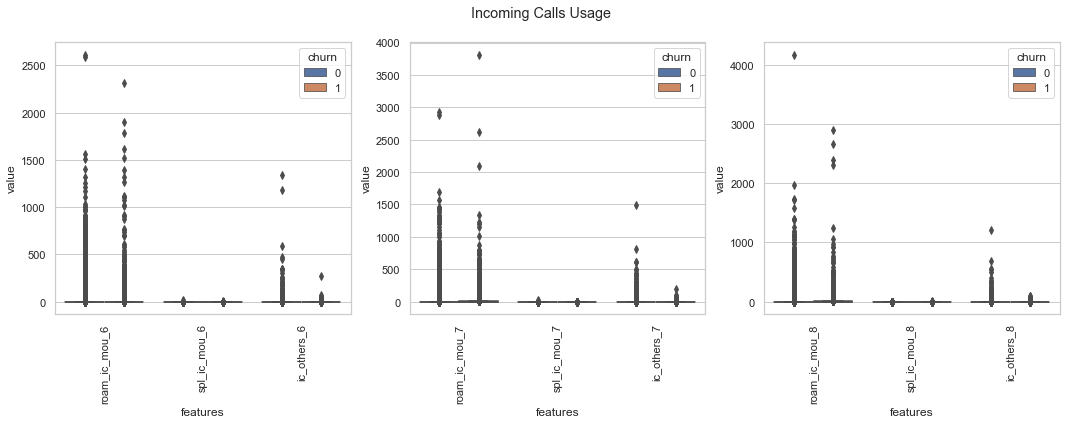

In [129]:
cols = [['roam_ic_mou_6','spl_ic_mou_6','ic_others_6'],
        ['roam_ic_mou_7','spl_ic_mou_7','ic_others_7'],
        ['roam_ic_mou_8','spl_ic_mou_8','ic_others_8']]

# column description stats
for i in range(0,3):
    display(df_telecom_high_val_cust[cols[i]].describe())

# plot for the incoming calls usage
plt.figure(figsize=(18, 5))
for i in range(0,3):
    plt.subplot(1,3,i+1)
    X = pd.concat([df_telecom_high_val_cust[cols[i]], df_telecom_high_val_cust['churn']], axis=1)
    X = pd.melt(X,id_vars="churn",var_name="features",value_name='value')
    sns.boxplot(x="features", y="value", hue="churn", data=X)
    plt.xticks(rotation=90)    
    plt.suptitle('Incoming Calls Usage')

> <span style='color:green'>**Inferences from above:**Almost all the Incoming calls usage columns seem to have outliers at the top percentile.

#### Analysing Outgoing calls for outliers

,isd_og_mou_6,roam_og_mou_6,spl_og_mou_6,og_others_6
count,"29,953.00","29,953.00","29,953.00","29,953.00"
mean,2.17,26.60,5.83,0.66
std,45.89,116.27,17.58,4.11
min,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00
50%,0.00,0.00,0.23,0.00
75%,0.00,0.00,5.21,0.00
max,"5,900.66","3,775.11","1,023.21",609.81


,isd_og_mou_7,roam_og_mou_7,spl_og_mou_7,og_others_7
count,"29,953.00","29,953.00","29,953.00","29,953.00"
mean,2.11,20.16,7.11,0.04
std,45.58,96.13,21.77,2.68
min,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00
50%,0.00,0.00,0.71,0.00
75%,0.00,0.00,6.95,0.00
max,"5,490.28","2,812.04","1,265.79",370.13


,isd_og_mou_8,roam_og_mou_8,spl_og_mou_8,og_others_8
count,"29,953.00","29,953.00","29,953.00","29,953.00"
mean,1.95,19.89,6.55,0.06
std,44.75,104.80,20.29,3.32
min,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00
50%,0.00,0.00,0.43,0.00
75%,0.00,0.00,6.14,0.00
max,"5,681.54","5,337.04",954.51,394.93


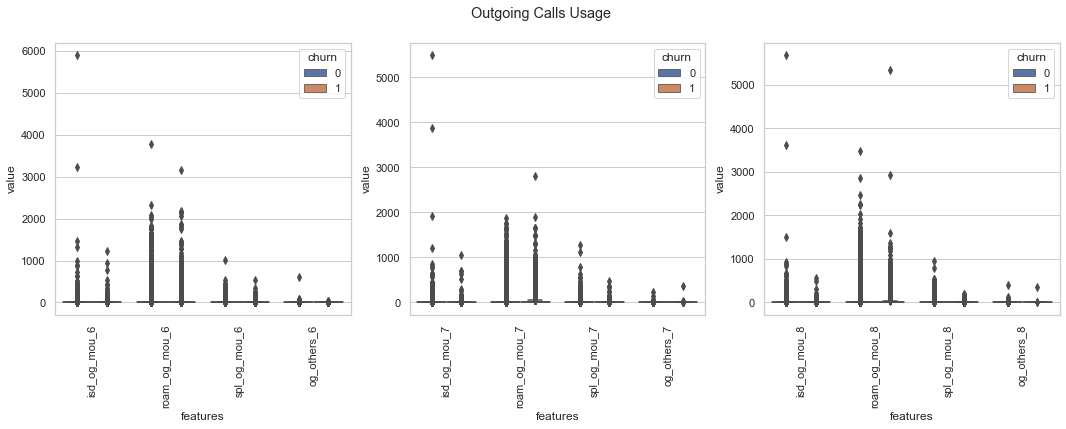

In [130]:
cols = [['isd_og_mou_6','roam_og_mou_6','spl_og_mou_6','og_others_6'],
        ['isd_og_mou_7','roam_og_mou_7','spl_og_mou_7','og_others_7'],
        ['isd_og_mou_8','roam_og_mou_8','spl_og_mou_8','og_others_8']]

# column description stats
for i in range(0,3):
    display(df_telecom_high_val_cust[cols[i]].describe())

# plot for the outgoing calls usage
plt.figure(figsize=(18, 5))
#ic call usage
for i in range(0,3):
    plt.subplot(1,3,i+1)
    X = pd.concat([df_telecom_high_val_cust[cols[i]], df_telecom_high_val_cust['churn']], axis=1)
    X = pd.melt(X,id_vars="churn",var_name="features",value_name='value')
    sns.boxplot(x="features", y="value", hue="churn", data=X)
    plt.xticks(rotation=90)    
    plt.suptitle('Outgoing Calls Usage')

> <span style='color:green'>**Inferences from above:**Almost all the Outgoing calls usage columns seem to have outliers at the top percentile.

#### Analysing Operatorwise Calls Usage

,onnet_mou_6,offnet_mou_6,loc_ic_t2t_mou_6,loc_ic_t2m_mou_6,loc_ic_t2f_mou_6,std_ic_t2t_mou_6,std_ic_t2m_mou_6,std_ic_t2f_mou_6
count,"29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00"
mean,260.90,373.80,65.51,150.47,15.29,14.90,29.21,2.70
std,459.85,482.71,163.86,219.32,45.79,77.75,98.28,19.11
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,17.09,71.61,6.10,28.09,0.00,0.00,0.00,0.00
50%,84.64,222.56,25.08,84.11,1.84,0.38,5.00,0.00
75%,290.49,487.91,67.48,188.74,11.98,8.19,23.63,0.11
max,"7,376.71","8,362.36","6,351.44","4,693.86","1,678.41","5,459.56","4,630.23","1,351.11"


,loc_og_t2t_mou_6,loc_og_t2m_mou_6,loc_og_t2f_mou_6,loc_og_t2c_mou_6,std_og_t2t_mou_6,std_og_t2m_mou_6,std_og_t2f_mou_6
count,"29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00"
mean,84.57,163.31,6.35,1.58,165.90,179.44,1.81
std,228.96,250.22,22.14,6.31,403.99,409.14,11.99
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,4.38,19.21,0.00,0.00,0.00,0.00,0.00
50%,24.36,77.26,0.00,0.00,2.71,16.36,0.00
75%,78.06,209.03,4.23,0.00,109.56,154.54,0.00
max,"6,431.33","4,729.74","1,466.03",271.44,"7,366.58","8,314.76",628.56


,onnet_mou_7,offnet_mou_7,loc_ic_t2t_mou_7,loc_ic_t2m_mou_7,loc_ic_t2f_mou_7,std_ic_t2t_mou_7,std_ic_t2m_mou_7,std_ic_t2f_mou_7
count,"29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00"
mean,268.05,378.23,66.69,151.71,16.05,15.43,30.83,2.80
std,480.30,499.14,167.52,218.37,49.20,83.11,105.69,19.53
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,16.04,69.98,6.79,30.84,0.00,0.00,0.00,0.00
50%,82.83,220.04,25.78,85.69,2.00,0.45,5.18,0.00
75%,290.54,494.03,68.73,190.74,12.24,8.59,24.96,0.20
max,"8,157.78","9,667.13","5,709.59","4,171.51","1,983.01","5,800.93","3,470.38","1,136.08"


,loc_og_t2t_mou_7,loc_og_t2m_mou_7,loc_og_t2f_mou_7,loc_og_t2c_mou_7,std_og_t2t_mou_7,std_og_t2m_mou_7,std_og_t2f_mou_7
count,"29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00"
mean,85.76,163.09,6.43,1.89,174.38,187.96,1.83
std,240.70,241.68,21.96,9.14,421.47,433.81,12.99
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,4.63,20.49,0.00,0.00,0.00,0.00,0.00
50%,24.68,78.99,0.10,0.00,2.68,16.06,0.00
75%,78.51,208.53,4.38,0.10,116.53,160.26,0.00
max,"7,400.66","4,557.14","1,196.43",569.71,"8,133.66","9,284.74",544.63


,onnet_mou_8,offnet_mou_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_8
count,"29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00"
mean,234.35,335.12,62.66,146.30,14.41,13.92,27.92,2.56
std,458.75,481.99,159.03,215.00,43.34,71.39,103.37,19.91
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,10.44,46.76,4.88,24.23,0.00,0.00,0.00,0.00
50%,65.66,182.84,22.61,80.04,1.68,0.11,3.71,0.00
75%,240.63,438.86,65.11,185.83,11.16,7.06,21.83,0.09
max,"10,752.56","14,007.34","4,003.21","4,643.49","1,588.53","4,309.29","5,645.86","1,394.89"


,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8
count,"29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00"
mean,78.15,151.81,5.89,1.70,148.59,157.32,1.59
std,227.54,233.75,19.52,7.15,397.84,409.04,10.94
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,2.54,13.13,0.00,0.00,0.00,0.00,0.00
50%,20.74,67.79,0.00,0.00,0.63,9.46,0.00
75%,72.13,197.03,3.93,0.01,78.19,117.71,0.00
max,"10,752.56","4,961.33",928.49,351.83,"8,014.43","13,950.04",516.91


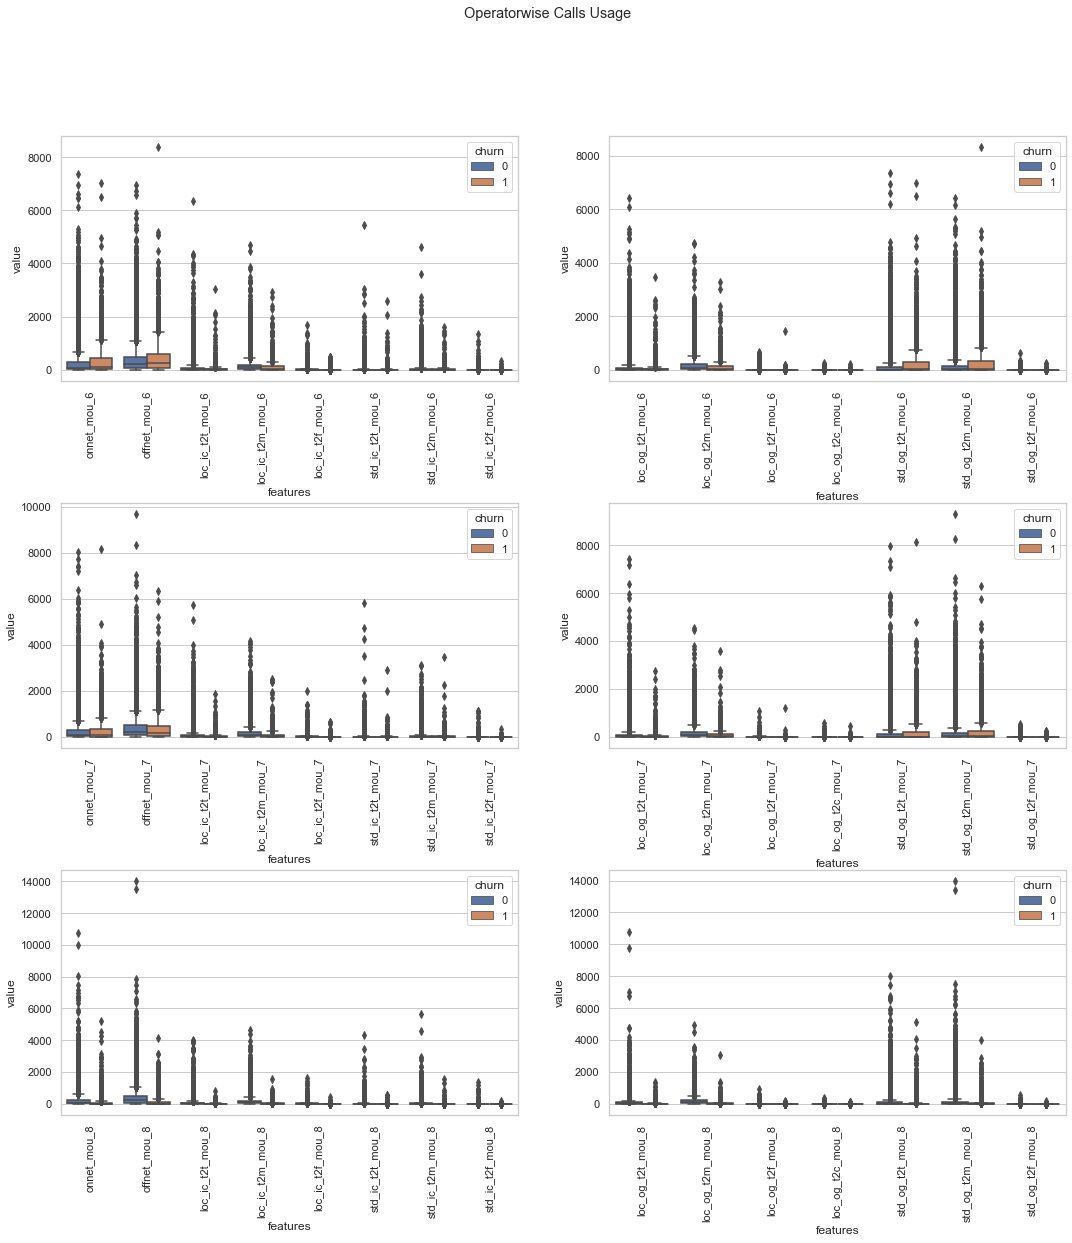

In [131]:
cols = [['onnet_mou_6','offnet_mou_6','loc_ic_t2t_mou_6','loc_ic_t2m_mou_6','loc_ic_t2f_mou_6','std_ic_t2t_mou_6','std_ic_t2m_mou_6','std_ic_t2f_mou_6'],
        ['loc_og_t2t_mou_6','loc_og_t2m_mou_6','loc_og_t2f_mou_6','loc_og_t2c_mou_6','std_og_t2t_mou_6','std_og_t2m_mou_6','std_og_t2f_mou_6'],
        ['onnet_mou_7','offnet_mou_7','loc_ic_t2t_mou_7','loc_ic_t2m_mou_7','loc_ic_t2f_mou_7','std_ic_t2t_mou_7','std_ic_t2m_mou_7','std_ic_t2f_mou_7'],
        ['loc_og_t2t_mou_7','loc_og_t2m_mou_7','loc_og_t2f_mou_7','loc_og_t2c_mou_7','std_og_t2t_mou_7','std_og_t2m_mou_7','std_og_t2f_mou_7'],
        ['onnet_mou_8','offnet_mou_8','loc_ic_t2t_mou_8','loc_ic_t2m_mou_8','loc_ic_t2f_mou_8','std_ic_t2t_mou_8','std_ic_t2m_mou_8','std_ic_t2f_mou_8'],
        ['loc_og_t2t_mou_8','loc_og_t2m_mou_8','loc_og_t2f_mou_8','loc_og_t2c_mou_8','std_og_t2t_mou_8','std_og_t2m_mou_8','std_og_t2f_mou_8']]

# column description stats
for i in range(0,6):
    display(df_telecom_high_val_cust[cols[i]].describe())

# plot for the operatorwise calls usage
plt.figure(figsize=(18, 18))
plt.subplots_adjust(hspace=0.5)
for i in range(0,6):
    plt.subplot(3,2,i+1)
    X = pd.concat([df_telecom_high_val_cust[cols[i]], df_telecom_high_val_cust['churn']], axis=1)
    X = pd.melt(X,id_vars="churn",var_name="features",value_name='value')
    sns.boxplot(x="features", y="value", hue="churn", data=X)
    plt.xticks(rotation=90)    
    plt.suptitle('Operatorwise Calls Usage')

> <span style='color:green'>**Inferences from above:** Here as well there are outliers at upper quartile

#### Analysing Variables related to Recharge Amout

,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8
count,"29,953.00","29,953.00","29,953.00"
mean,661.13,660.93,584.71
std,561.33,582.75,611.47
min,0.00,0.00,0.00
25%,360.00,352.00,250.00
50%,566.00,562.00,491.00
75%,834.00,832.00,776.00
max,"35,190.00","40,335.00","45,320.00"


,total_rech_amt_data_6,total_rech_amt_data_7,total_rech_amt_data_8
count,"29,953.00","29,953.00","29,953.00"
mean,456.39,528.96,463.64
std,"1,419.71","1,477.10","1,623.84"
min,0.00,0.00,0.00
25%,0.00,0.00,0.00
50%,92.00,100.00,25.00
75%,400.00,575.00,308.00
max,"105,644.00","55,080.00","89,106.50"


,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8
count,"29,953.00","29,953.00","29,953.00"
mean,169.35,172.28,160.22
std,175.42,181.50,173.30
min,0.00,0.00,0.00
25%,110.00,110.00,50.00
50%,120.00,128.00,130.00
75%,200.00,200.00,198.00
max,"4,010.00","4,010.00","4,449.00"


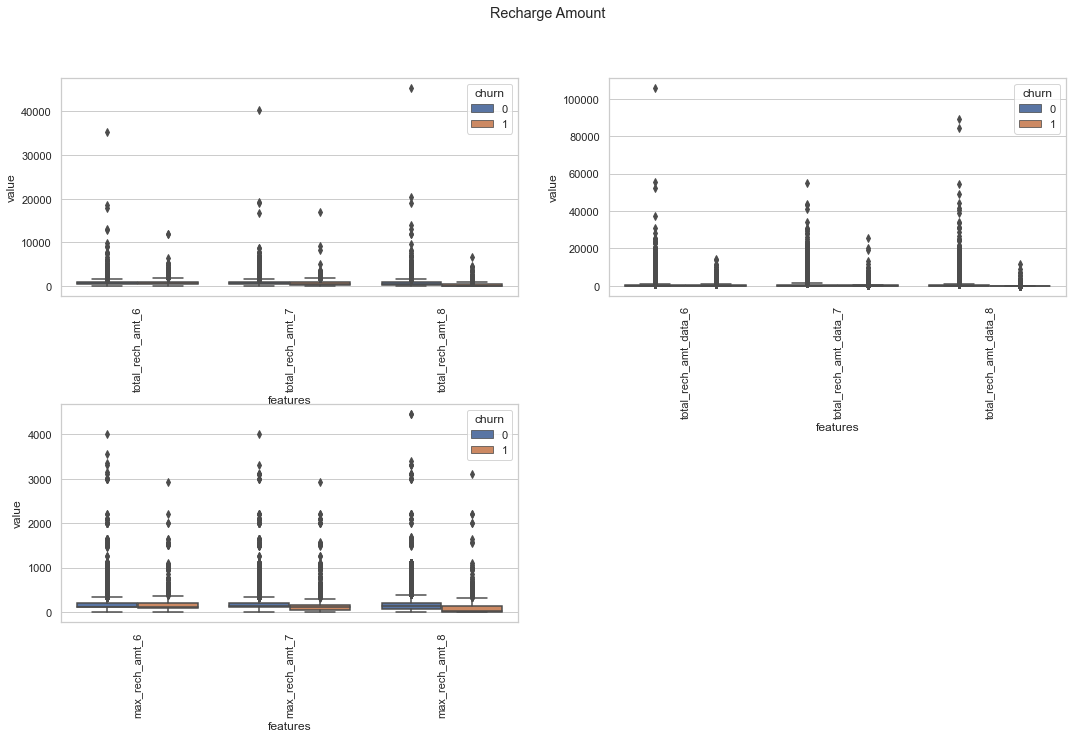

In [132]:
cols = [
        ['total_rech_amt_6','total_rech_amt_7','total_rech_amt_8'],
        ['total_rech_amt_data_6','total_rech_amt_data_7','total_rech_amt_data_8'],
        ['max_rech_amt_6','max_rech_amt_7','max_rech_amt_8']
       ]

# column description stats
for i in range(0,3):
    display(df_telecom_high_val_cust[cols[i]].describe())

# plot for the recharge amount columns
plt.figure(figsize=(18, 10))
plt.subplots_adjust(hspace=0.5)
for i in range(0,3):
    plt.subplot(2,2,i+1)
    X = pd.concat([df_telecom_high_val_cust[cols[i]], df_telecom_high_val_cust['churn']], axis=1)
    X = pd.melt(X,id_vars="churn",var_name="features",value_name='value')
    sns.boxplot(x="features", y="value", hue="churn", data=X)
    plt.xticks(rotation=90)    
    plt.suptitle('Recharge Amount')

> <span style='color:green'>**Inferences from above:** Here as well there are outliers at upper quartile

,total_rech_num_6,total_rech_num_7,total_rech_num_8
count,"29,953.00","29,953.00","29,953.00"
mean,11.85,11.72,9.98
std,9.43,9.43,9.28
min,0.00,0.00,0.00
25%,6.00,6.00,4.00
50%,9.00,9.00,8.00
75%,15.00,15.00,13.00
max,307.00,138.00,196.00


,total_rech_data_6,total_rech_data_7,total_rech_data_8
count,"29,953.00","29,953.00","29,953.00"
mean,1.67,1.86,1.62
std,2.83,3.09,3.00
min,0.00,0.00,0.00
25%,0.00,0.00,0.00
50%,1.00,1.00,1.00
75%,2.00,2.00,2.00
max,61.00,54.00,60.00


,max_rech_data_6,max_rech_data_7,max_rech_data_8
count,"29,953.00","29,953.00","29,953.00"
mean,78.13,79.89,72.54
std,112.78,114.32,110.61
min,0.00,0.00,0.00
25%,0.00,0.00,0.00
50%,25.00,25.00,23.00
75%,154.00,154.00,154.00
max,"1,555.00","1,555.00","1,555.00"


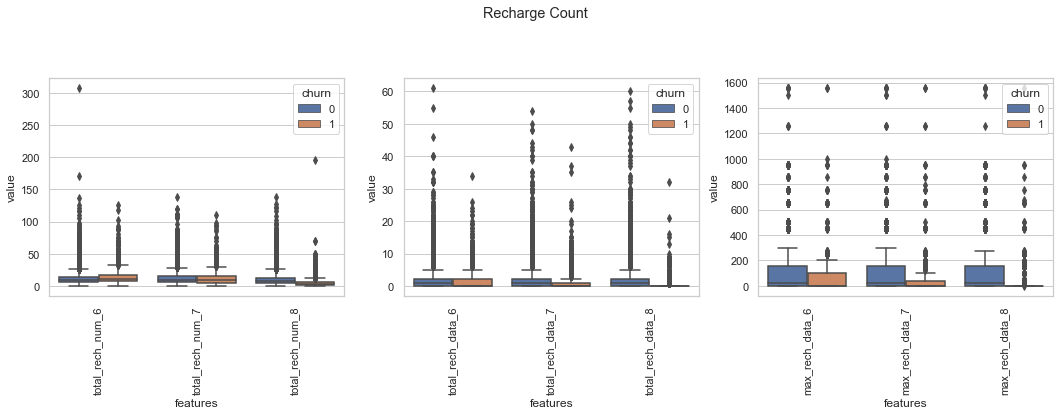

In [133]:
cols = [
        ['total_rech_num_6','total_rech_num_7','total_rech_num_8'],
        ['total_rech_data_6','total_rech_data_7','total_rech_data_8'],
        ['max_rech_data_6','max_rech_data_7','max_rech_data_8']
       ]

# column description stats
for i in range(0,3):
    display(df_telecom_high_val_cust[cols[i]].describe())

# plot for the recharge count columns
plt.figure(figsize=(18, 10))
plt.subplots_adjust(hspace=0.5)
for i in range(0,3):
    plt.subplot(2,3,i+1)
    X = pd.concat([df_telecom_high_val_cust[cols[i]], df_telecom_high_val_cust['churn']], axis=1)
    X = pd.melt(X,id_vars="churn",var_name="features",value_name='value')
    sns.boxplot(x="features", y="value", hue="churn", data=X)
    plt.xticks(rotation=90)    
    plt.suptitle('Recharge Count')

> <span style='color:green'>**Inferences from above:** Here as well there are outliers at upper quartile

#### Analysing ARPUY related variables

,arpu_6,arpu_7,arpu_8
count,"29,953.00","29,953.00","29,953.00"
mean,558.82,561.16,508.89
std,460.87,480.03,502.14
min,"-2,258.71","-2,014.05",-945.81
25%,310.14,310.07,231.62
50%,482.35,481.50,427.60
75%,700.24,698.83,661.75
max,"27,731.09","35,145.83","33,543.62"


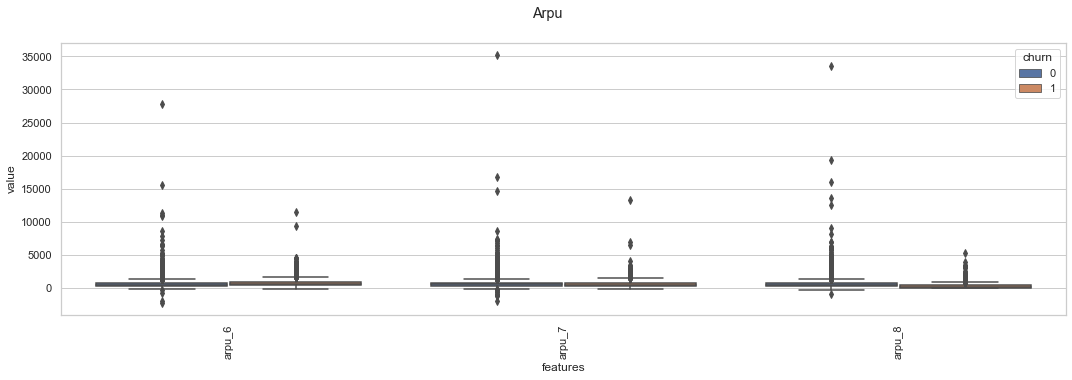

In [134]:
cols = [
        ['arpu_6','arpu_7','arpu_8']
       ]

# column description stats
for i in range(0,1):
    display(df_telecom_high_val_cust[cols[i]].describe())

# plot for the arpu
plt.figure(figsize=(18, 5))
for i in range(0,1):
    plt.subplot(1,1,i+1)
    X = pd.concat([df_telecom_high_val_cust[cols[i]], df_telecom_high_val_cust['churn']], axis=1)
    X = pd.melt(X,id_vars="churn",var_name="features",value_name='value')
    sns.boxplot(x="features", y="value", hue="churn", data=X)
    plt.xticks(rotation=90)    
    plt.suptitle('Arpu')

### Outlier Treatement

- ### Capping the outliers to 99 percentile to handle the outliers

In [135]:
cols_to_exclude = ['monthly_2g_6','monthly_2g_7','monthly_2g_8',
                   'monthly_3g_6','monthly_3g_7','monthly_3g_8',
                   'sachet_2g_6','sachet_2g_7','sachet_2g_8',
                   'sachet_3g_6','sachet_3g_7','sachet_3g_8',
                   'date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8',
                   'spl_ic_mou_6','spl_ic_mou_7','spl_ic_mou_8','spl_og_mou_6','og_others_6','spl_og_mou_7','og_others_7','spl_og_mou_8','og_others_8',
                   'loc_og_t2c_mou_6','std_og_t2f_mou_6','std_ic_t2f_mou_6','loc_ic_t2f_mou_6',
                   'loc_og_t2c_mou_7','std_og_t2f_mou_7','std_ic_t2f_mou_7','loc_ic_t2f_mou_7',
                   'loc_og_t2c_mou_8','std_og_t2f_mou_8','std_ic_t2f_mou_8','loc_ic_t2f_mou_8',
                   'aon','churn','mobile_number'
                  ]
cols = list(set(df_telecom_high_val_cust.columns).difference(set(cols_to_exclude)))

# iterate through the columns and cap the values with the 99th percentile
for col in cols:
    percentiles = df_telecom_high_val_cust[col].quantile([0.01,0.99]).values
    df_telecom_high_val_cust[col][df_telecom_high_val_cust[col] >= percentiles[1]] = percentiles[1]

### Outlier Treatment in completed

## Step 3.5: Merging existing columns to create meaningfull columns and reduce complexity

In [136]:
df_final = df_telecom_high_val_cust.copy()

In [137]:
df_final.shape

(29953, 124)

In [138]:
### Dropping the column - which was created to identify the high value customers

df_final.drop(["tot_avg_rech_amnt_Gud_Phase"],axis=1,inplace=True)

In [139]:
df_final.filter(regex='date_').columns

Index(['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8'], dtype='object')

In [140]:
### Dropping the date related columns

df_final = df_final.drop(df_final.filter(regex='date_').columns, axis = 1)

In [141]:
df_final.head()

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,vbc_3g_8,vbc_3g_7,vbc_3g_6,total_rech_amt_data_6,total_rech_amt_data_7,total_rech_amt_data_8,churn
0,7000842753,197.38,214.82,213.80,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.16,0.00,0.00,4.13,0.00,0.00,1.15,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4,3,2,362.00,252.00,252.00,252,252,252,252,252,252,1.00,1.00,1.00,252.00,252.00,252.00,252.00,252.00,252.00,30.13,1.32,5.75,83.57,150.76,109.61,0,0,0,0,0,0,1,1,1,0,0,0,968,30.40,0.00,101.20,252.00,252.00,252.00,1
7,7000701601,"1,069.18","1,349.85","1,986.74",57.84,54.68,52.29,453.43,567.16,325.91,16.23,33.49,31.64,23.74,12.59,38.06,51.39,31.38,40.28,308.63,447.38,162.28,62.13,55.14,53.23,0.00,0.00,0.00,4.30,23.29,12.01,49.89,31.76,49.14,6.66,20.08,16.68,0.00,0.18,10.01,4.50,0.00,6.50,0.00,0.00,0.00,58.14,32.26,27.31,217.56,221.49,121.19,152.16,101.46,39.53,36.89,11.83,30.39,91.44,126.99,141.33,52.19,34.24,22.21,0.21,0.00,0.00,2.06,14.53,31.59,15.74,15.19,15.14,5,5,7,"1,580.00",790.00,"2,341.48",1000,790,951,0,0,565,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,802,57.74,19.38,18.74,0.00,0.00,0.00,1
8,7001524846,378.72,492.22,137.36,413.69,351.03,35.08,94.66,80.63,136.48,0.00,0.00,0.00,0.00,0.00,0.00,297.13,217.59,12.49,80.96,70.58,50.54,0.00,0.00,0.00,0.00,0.00,7.15,116.56,133.43,22.58,13.69,10.04,75.69,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,10.23,0.00,0.00,0.00,23.84,9.84,0.31,57.58,13.98,15.48,0.00,0.00,0.00,0.00,0.58,0.10,22.43,4.08,0.65,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,19,21,14,437.00,601.00,120.00,90,154,30,50,0,10,0.00,2.00,3.00,0.00,154.00,23.00,0.00,177.00,69.00,0.00,356.00,0.03,0.00,750.95,11.94,0,1,0,0,1,3,0,0,0,0,0,0,315,21.03,910.65,122.16,0.00,354.00,207.00,0
21,7002124215,514.45,597.75,637.76,102.41,132.11,85.14,757.93,896.68,983.39,0.00,0.00,0.00,0.00,0.00,0.00,4.48,6.16,23.34,91.81,87.93,104.81,0.75,0.00,1.58,0.00,0.00,0.00,97.93,125.94,61.79,665.36,808.74,876.99,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.48,10.19,19.54,118.23,74.63,129.16,4.61,2.84,10.39,14.06,5.98,0.18,67.69,38.23,101.74,0.00,0.00,0.

In [142]:
df_final.shape

(29953, 120)

In [143]:
df_final.filter(regex='_6|_7').columns

Index(['arpu_6', 'arpu_7', 'onnet_mou_6', 'onnet_mou_7', 'offnet_mou_6',
       'offnet_mou_7', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_og_mou_6',
       'roam_og_mou_7', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7',
       'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2f_mou_6',
       'loc_og_t2f_mou_7', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7',
       'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2m_mou_6',
       'std_og_t2m_mou_7', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7',
       'isd_og_mou_6', 'isd_og_mou_7', 'spl_og_mou_6', 'spl_og_mou_7',
       'og_others_6', 'og_others_7', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7',
       'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7', 'loc_ic_t2f_mou_6',
       'loc_ic_t2f_mou_7', 'std_ic_t2t_mou_6', 'std_ic_t2t_mou_7',
       'std_ic_t2m_mou_6', 'std_ic_t2m_mou_7', 'std_ic_t2f_mou_6',
       'std_ic_t2f_mou_7', 'spl_ic_mou_6', 'spl_ic_mou_7', 'isd_ic_mou_6',
       'isd_ic_mou_7', 'ic_others_6', 'ic_others_7', 'total_rech_num_6',
       'total_rech_num_7

#### Above are the columns related to Month 6 and 7. Since these 2 months depict good phase, we can club the variables related to 6th and 7th by averaging the values

In [144]:
col_6_7_list = df_final.filter(regex='_6|_7').columns.str[:-2]
for i, col in enumerate(col_6_7_list.unique()):
    #print(i, col)
    new_avg_col = 'avg_'+col+'_6_7'
    column_6 = col+'_6'
    column_7 = col+'_7'
    df_final[new_avg_col] = (df_final[column_6] + df_final[column_7])/2
df_final.head()

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,vbc_3g_8,vbc_3g_7,vbc_3g_6,total_rech_amt_data_6,total_rech_amt_data_7,total_rech_amt_data_8,churn,avg_arpu_6_7,avg_onnet_mou_6_7,avg_offnet_mou_6_7,avg_roam_ic_mou_6_7,avg_roam_og_mou_6_7,avg_loc_og_t2t_mou_6_7,avg_loc_og_t2m_mou_6_7,avg_loc_og_t2f_mou_6_7,avg_loc_og_t2c_mou_6_7,avg_std_og_t2t_mou_6_7,avg_std_og_t2m_mou_6_7,avg_std_og_t2f_mou_6_7,avg_isd_og_mou_6_7,avg_spl_og_mou_6_7,avg_og_others_6_7,avg_loc_ic_t2t_mou_6_7,avg_loc_ic_t2m_mou_6_7,avg_loc_ic_t2f_mou_6_7,avg_std_ic_t2t_mou_6_7,avg_std_ic_t2m_mou_6_7,avg_std_ic_t2f_mou_6_7,avg_spl_ic_mou_6_7,avg_isd_ic_mou_6_7,avg_ic_others_6_7,avg_total_rech_num_6_7,avg_total_rech_amt_6_7,avg_max_rech_amt_6_7,avg_last_day_rch_amt_6_7,avg_total_rech_data_6_7,avg_max_rech_data_6_7,avg_av_rech_amt_data_6_7,avg_vol_2g_mb_6_7,avg_vol_3g_mb_6_7,avg_monthly_2g_6_7,avg_sachet_2g_6_7,avg_monthly_3g_6_7,avg_sachet_3g_6_7,avg_vbc_3g_6_7,avg_total_rech_amt_data_6_7
0,7000842753,197.38,214.82,213.80,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.16,0.00,0.00,4.13,0.00,0.00,1.15,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4,3,2,362.00,252.00,252.00,252,252,252,252,252,252,1.00,1.00,1.00,252.00,252.00,252.00,252.00,252.00,252.00,30.13,1.32,5.75,83.57,150.76,109.61,0,0,0,0,0,0,1,1,1,0,0,0,968,30.40,0.00,101.20,252.00,252.00,252.00,1,206.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.50,307.00,252.00,252.00,1.00,252.00,252.00,15.72,117.16,0.00,0.00,1.00,0.00,50.60,252.00
7,7000701601,"1,069.18","1,349.85","1,986.74",57.84,54.68,52.29,453.43,567.16,325.91,16.23,33.49,31.64,23.74,12.59,38.06,51.39,31.38,40.28,308.63,447.38,162.28,62.13,55.14,53.23,0.00,0.00,0.00,4.30,23.29,12.01,49.89,31.76,49.14,6.66,20.08,16.68,0.00,0.18,10.01,4.50,0.00,6.50,0.00,0.00,0.00,58.14,32.26,27.31,217.56,221.49,121.19,152.16,101.46,39.53,36.89,11.83,30.39,91.44,126.99,141.33,52.19,34.24,22.21,0.21,0.00,0.00,2.06,14.53,31.59,15.74,15.19,15.14,5,5,7,"1,580.00",790.00,"2,341.48",1000,790,951,0,0,565,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0

In [145]:
df_final.shape

(29953, 159)

In [146]:
df_fina_bkp = df_final.copy()

#### Now we will drop the original variables related to 6th and 7th month since we have clubbed them together

In [147]:
col_drop_good_phase = df_final.filter(regex='_6$').columns

In [148]:
len(col_drop_good_phase)

39

In [149]:
df_final = df_final.drop(col_drop_good_phase, axis = 1)

In [150]:
df_final.head()

,mobile_number,arpu_7,arpu_8,onnet_mou_7,onnet_mou_8,offnet_mou_7,offnet_mou_8,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_7,loc_og_t2c_mou_8,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_7,std_og_t2f_mou_8,isd_og_mou_7,isd_og_mou_8,spl_og_mou_7,spl_og_mou_8,og_others_7,og_others_8,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_7,std_ic_t2f_mou_8,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_7,isd_ic_mou_8,ic_others_7,ic_others_8,total_rech_num_7,total_rech_num_8,total_rech_amt_7,total_rech_amt_8,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_7,total_rech_data_8,max_rech_data_7,max_rech_data_8,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_7,monthly_2g_8,sachet_2g_7,sachet_2g_8,monthly_3g_7,monthly_3g_8,sachet_3g_7,sachet_3g_8,aon,vbc_3g_8,vbc_3g_7,total_rech_amt_data_7,total_rech_amt_data_8,churn,avg_arpu_6_7,avg_onnet_mou_6_7,avg_offnet_mou_6_7,avg_roam_ic_mou_6_7,avg_roam_og_mou_6_7,avg_loc_og_t2t_mou_6_7,avg_loc_og_t2m_mou_6_7,avg_loc_og_t2f_mou_6_7,avg_loc_og_t2c_mou_6_7,avg_std_og_t2t_mou_6_7,avg_std_og_t2m_mou_6_7,avg_std_og_t2f_mou_6_7,avg_isd_og_mou_6_7,avg_spl_og_mou_6_7,avg_og_others_6_7,avg_loc_ic_t2t_mou_6_7,avg_loc_ic_t2m_mou_6_7,avg_loc_ic_t2f_mou_6_7,avg_std_ic_t2t_mou_6_7,avg_std_ic_t2m_mou_6_7,avg_std_ic_t2f_mou_6_7,avg_spl_ic_mou_6_7,avg_isd_ic_mou_6_7,avg_ic_others_6_7,avg_total_rech_num_6_7,avg_total_rech_amt_6_7,avg_max_rech_amt_6_7,avg_last_day_rch_amt_6_7,avg_total_rech_data_6_7,avg_max_rech_data_6_7,avg_av_rech_amt_data_6_7,avg_vol_2g_mb_6_7,avg_vol_3g_mb_6_7,avg_monthly_2g_6_7,avg_sachet_2g_6_7,avg_monthly_3g_6_7,avg_sachet_3g_6_7,avg_vbc_3g_6_7,avg_total_rech_amt_data_6_7
0,7000842753,214.82,213.80,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.16,0.00,4.13,0.00,1.15,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3,2,252.00,252.00,252,252,252,252,1.00,1.00,252.00,252.00,252.00,252.00,1.32,5.75,150.76,109.61,0,0,0,0,1,1,0,0,968,30.40,0.00,252.00,252.00,1,206.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.50,307.00,252.00,252.00,1.00,252.00,252.00,15.72,117.16,0.00,0.00,1.00,0.00,50.60,252.00
7,7000701601,"1,349.85","1,986.74",54.68,52.29,567.16,325.91,33.49,31.64,12.59,38.06,31.38,40.28,447.38,162.28,55.14,53.23,0.00,0.00,23.29,12.01,31.76,49.14,20.08,16.68,0.18,10.01,0.00,6.50,0.00,0.00,32.26,27.31,221.49,121.19,101.46,39.53,11.83,30.39,126.99,141.33,34.24,22.21,0.00,0.00,14.53,31.59,15.19,15.14,5,7,790.00,"2,341.48",790,951,0,565,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,802,57.74,19.38,0.00,0.00,1,"1,209.51",56.26,510.29,24.86,18.16,41.38,378.00,58.64,0.00,13.79,40.83,13.37,0.09,2.25,0.00,45.20,219.53,126.81,24.36,109.22,43.22,0.10,8.29,15.46,5.00,"1,185.00",895.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,19.06,0.00
8,7001524846,492.22,137.36,351.03,35.08,80.63,136.48,0.00,0.00,0.00,0.00,217.59,12.49,70.58,50.54,0.00,0.00,0.00,7.15,133.43,22.58,10.04,75.69,0.00,0.00,0.00,0.00,0.00,10.23,0.00,0.00,9.84,0.31,13.98,15.48,0.00,0.00,0.58,0.10,4.08,0.65,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,21,14,601.00,120.00,154,30,0,10,2.00,3.00,154.00,23.00,177.00,69.00,356.00,0.03,750.95,11.94,1,0,1,3,0,0,0,0,315,21.03,910.65,354.00,207.00,0,435.47,382.36,87.64,0.00,0.00,257.36,75.77,0.00,0.00,125.00,11.86,0.00,0.00,0.00,0.00,16.84,35.78,0.00,0.29,13.25,0.00,0.00,0.00,0.00,20.00,519.00,122.00,25.00,1.00,77.00,88.50,178.00,375.48,0.50,0.50,0.00,0.00,516.40,177.00
21,7002124215,597.75,637.76,132.11,85.14,896.68,983.39,0.00,0.0

In [151]:
df_final.shape

(29953, 120)

In [152]:
col_list_good_phase_7 = []
for i in df_final.columns:
    if not i.endswith('_6_7'):
        if i.endswith('_7'):
            col_list_good_phase_7.append(i)
print(col_list_good_phase_7)

['arpu_7', 'onnet_mou_7', 'offnet_mou_7', 'roam_ic_mou_7', 'roam_og_mou_7', 'loc_og_t2t_mou_7', 'loc_og_t2m_mou_7', 'loc_og_t2f_mou_7', 'loc_og_t2c_mou_7', 'std_og_t2t_mou_7', 'std_og_t2m_mou_7', 'std_og_t2f_mou_7', 'isd_og_mou_7', 'spl_og_mou_7', 'og_others_7', 'loc_ic_t2t_mou_7', 'loc_ic_t2m_mou_7', 'loc_ic_t2f_mou_7', 'std_ic_t2t_mou_7', 'std_ic_t2m_mou_7', 'std_ic_t2f_mou_7', 'spl_ic_mou_7', 'isd_ic_mou_7', 'ic_others_7', 'total_rech_num_7', 'total_rech_amt_7', 'max_rech_amt_7', 'last_day_rch_amt_7', 'total_rech_data_7', 'max_rech_data_7', 'av_rech_amt_data_7', 'vol_2g_mb_7', 'vol_3g_mb_7', 'monthly_2g_7', 'sachet_2g_7', 'monthly_3g_7', 'sachet_3g_7', 'vbc_3g_7', 'total_rech_amt_data_7']


In [153]:
len(col_list_good_phase_7)

39

In [154]:
df_final = df_final.drop(col_list_good_phase_7, axis = 1)

In [155]:
df_final.shape

(29953, 81)

In [156]:
df_final.head()

,mobile_number,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,total_rech_data_8,max_rech_data_8,av_rech_amt_data_8,vol_2g_mb_8,vol_3g_mb_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,aon,vbc_3g_8,total_rech_amt_data_8,churn,avg_arpu_6_7,avg_onnet_mou_6_7,avg_offnet_mou_6_7,avg_roam_ic_mou_6_7,avg_roam_og_mou_6_7,avg_loc_og_t2t_mou_6_7,avg_loc_og_t2m_mou_6_7,avg_loc_og_t2f_mou_6_7,avg_loc_og_t2c_mou_6_7,avg_std_og_t2t_mou_6_7,avg_std_og_t2m_mou_6_7,avg_std_og_t2f_mou_6_7,avg_isd_og_mou_6_7,avg_spl_og_mou_6_7,avg_og_others_6_7,avg_loc_ic_t2t_mou_6_7,avg_loc_ic_t2m_mou_6_7,avg_loc_ic_t2f_mou_6_7,avg_std_ic_t2t_mou_6_7,avg_std_ic_t2m_mou_6_7,avg_std_ic_t2f_mou_6_7,avg_spl_ic_mou_6_7,avg_isd_ic_mou_6_7,avg_ic_others_6_7,avg_total_rech_num_6_7,avg_total_rech_amt_6_7,avg_max_rech_amt_6_7,avg_last_day_rch_amt_6_7,avg_total_rech_data_6_7,avg_max_rech_data_6_7,avg_av_rech_amt_data_6_7,avg_vol_2g_mb_6_7,avg_vol_3g_mb_6_7,avg_monthly_2g_6_7,avg_sachet_2g_6_7,avg_monthly_3g_6_7,avg_sachet_3g_6_7,avg_vbc_3g_6_7,avg_total_rech_amt_data_6_7
0,7000842753,213.80,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.16,4.13,1.15,0.00,0.00,0.00,0.00,0.00,0.00,2,252.00,252,252,1.00,252.00,252.00,5.75,109.61,0,0,1,0,968,30.40,252.00,1,206.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.50,307.00,252.00,252.00,1.00,252.00,252.00,15.72,117.16,0.00,0.00,1.00,0.00,50.60,252.00
7,7000701601,"1,986.74",52.29,325.91,31.64,38.06,40.28,162.28,53.23,0.00,12.01,49.14,16.68,10.01,6.50,0.00,27.31,121.19,39.53,30.39,141.33,22.21,0.00,31.59,15.14,7,"2,341.48",951,565,0.00,0.00,0.00,0.00,0.00,0,0,0,0,802,57.74,0.00,1,"1,209.51",56.26,510.29,24.86,18.16,41.38,378.00,58.64,0.00,13.79,40.83,13.37,0.09,2.25,0.00,45.20,219.53,126.81,24.36,109.22,43.22,0.10,8.29,15.46,5.00,"1,185.00",895.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,19.06,0.00
8,7001524846,137.36,35.08,136.48,0.00,0.00,12.49,50.54,0.00,7.15,22.58,75.69,0.00,0.00,10.23,0.00,0.31,15.48,0.00,0.10,0.65,0.00,0.00,0.00,0.00,14,120.00,30,10,3.00,23.00,69.00,0.03,11.94,0,3,0,0,315,21.03,207.00,0,435.47,382.36,87.64,0.00,0.00,257.36,75.77,0.00,0.00,125.00,11.86,0.00,0.00,0.00,0.00,16.84,35.78,0.00,0.29,13.25,0.00,0.00,0.00,0.00,20.00,519.00,122.00,25.00,1.00,77.00,88.50,178.00,375.48,0.50,0.50,0.00,0.00,516.40,177.00
21,7002124215,637.76,85.14,983.39,0.00,0.00,23.34,104.81,1.58,0.00,61.79,876.99,0.00,0.00,0.00,0.00,19.54,129.16,10.39,0.18,101.74,0.00,0.00,0.00,0.00,27,718.00,50,50,0.00,0.00,0.00,0.00,0.00,0,0,0,0,720,0.00,0.00,0,556.10,117.26,827.30,0.00,0.00,5.32,89.87,0.38,0.00,111.94,737.05,0.00,0.00,0.00,0.00,6.33,96.43,3.73,10.02,52.96,0.00,0.00,0.00,0.00,24.00,640.00,50.00,25.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
23,7000887461,366.97,33.58,205.89,0.00,0.00,33.58,148.56,0.00,17.71,0.00,39.61,0.00,0.00,17.71,0.00,76.64,146.84,0.71,13.38,43.91,0.00,0.00,3.74,13.06,4,439.00,179,0,2.00,179.00,270.00,0.01,"1,009.92",0,0,1,1,604,40.45,540.00,0,134.12,49.81,87.38,0.00,0.00,49.81,82.97,0.00,0.00,0.00,4.35,0.00,0.01,0.05,0.00,40.88,104.63,0.00,0.26,8.66,0.00,0.00,14.12,2.67,4.00,227.00,89.50,89.50,1.00,89.50,178.00,0.24,299.55,0.00,0.00,1.00,0.00,25.93,356.00


#### Dropping Mobile number as it is having unique values and would not be of much use in Modelling

In [157]:
df_final = df_final.drop(columns = 'mobile_number', axis =1)

In [158]:
df_final.shape

(29953, 80)

In [159]:
df_final_bkp = df_final.copy()

In [160]:
df_final.head()

,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,total_rech_data_8,max_rech_data_8,av_rech_amt_data_8,vol_2g_mb_8,vol_3g_mb_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,aon,vbc_3g_8,total_rech_amt_data_8,churn,avg_arpu_6_7,avg_onnet_mou_6_7,avg_offnet_mou_6_7,avg_roam_ic_mou_6_7,avg_roam_og_mou_6_7,avg_loc_og_t2t_mou_6_7,avg_loc_og_t2m_mou_6_7,avg_loc_og_t2f_mou_6_7,avg_loc_og_t2c_mou_6_7,avg_std_og_t2t_mou_6_7,avg_std_og_t2m_mou_6_7,avg_std_og_t2f_mou_6_7,avg_isd_og_mou_6_7,avg_spl_og_mou_6_7,avg_og_others_6_7,avg_loc_ic_t2t_mou_6_7,avg_loc_ic_t2m_mou_6_7,avg_loc_ic_t2f_mou_6_7,avg_std_ic_t2t_mou_6_7,avg_std_ic_t2m_mou_6_7,avg_std_ic_t2f_mou_6_7,avg_spl_ic_mou_6_7,avg_isd_ic_mou_6_7,avg_ic_others_6_7,avg_total_rech_num_6_7,avg_total_rech_amt_6_7,avg_max_rech_amt_6_7,avg_last_day_rch_amt_6_7,avg_total_rech_data_6_7,avg_max_rech_data_6_7,avg_av_rech_amt_data_6_7,avg_vol_2g_mb_6_7,avg_vol_3g_mb_6_7,avg_monthly_2g_6_7,avg_sachet_2g_6_7,avg_monthly_3g_6_7,avg_sachet_3g_6_7,avg_vbc_3g_6_7,avg_total_rech_amt_data_6_7
0,213.80,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.16,4.13,1.15,0.00,0.00,0.00,0.00,0.00,0.00,2,252.00,252,252,1.00,252.00,252.00,5.75,109.61,0,0,1,0,968,30.40,252.00,1,206.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.50,307.00,252.00,252.00,1.00,252.00,252.00,15.72,117.16,0.00,0.00,1.00,0.00,50.60,252.00
7,"1,986.74",52.29,325.91,31.64,38.06,40.28,162.28,53.23,0.00,12.01,49.14,16.68,10.01,6.50,0.00,27.31,121.19,39.53,30.39,141.33,22.21,0.00,31.59,15.14,7,"2,341.48",951,565,0.00,0.00,0.00,0.00,0.00,0,0,0,0,802,57.74,0.00,1,"1,209.51",56.26,510.29,24.86,18.16,41.38,378.00,58.64,0.00,13.79,40.83,13.37,0.09,2.25,0.00,45.20,219.53,126.81,24.36,109.22,43.22,0.10,8.29,15.46,5.00,"1,185.00",895.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,19.06,0.00
8,137.36,35.08,136.48,0.00,0.00,12.49,50.54,0.00,7.15,22.58,75.69,0.00,0.00,10.23,0.00,0.31,15.48,0.00,0.10,0.65,0.00,0.00,0.00,0.00,14,120.00,30,10,3.00,23.00,69.00,0.03,11.94,0,3,0,0,315,21.03,207.00,0,435.47,382.36,87.64,0.00,0.00,257.36,75.77,0.00,0.00,125.00,11.86,0.00,0.00,0.00,0.00,16.84,35.78,0.00,0.29,13.25,0.00,0.00,0.00,0.00,20.00,519.00,122.00,25.00,1.00,77.00,88.50,178.00,375.48,0.50,0.50,0.00,0.00,516.40,177.00
21,637.76,85.14,983.39,0.00,0.00,23.34,104.81,1.58,0.00,61.79,876.99,0.00,0.00,0.00,0.00,19.54,129.16,10.39,0.18,101.74,0.00,0.00,0.00,0.00,27,718.00,50,50,0.00,0.00,0.00,0.00,0.00,0,0,0,0,720,0.00,0.00,0,556.10,117.26,827.30,0.00,0.00,5.32,89.87,0.38,0.00,111.94,737.05,0.00,0.00,0.00,0.00,6.33,96.43,3.73,10.02,52.96,0.00,0.00,0.00,0.00,24.00,640.00,50.00,25.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
23,366.97,33.58,205.89,0.00,0.00,33.58,148.56,0.00,17.71,0.00,39.61,0.00,0.00,17.71,0.00,76.64,146.84,0.71,13.38,43.91,0.00,0.00,3.74,13.06,4,439.00,179,0,2.00,179.00,270.00,0.01,"1,009.92",0,0,1,1,604,40.45,540.00,0,134.12,49.81,87.38,0.00,0.00,49.81,82.97,0.00,0.00,0.00,4.35,0.00,0.01,0.05,0.00,40.88,104.63,0.00,0.26,8.66,0.00,0.00,14.12,2.67,4.00,227.00,89.50,89.50,1.00,89.50,178.00,0.24,299.55,0.00,0.00,1.00,0.00,25.93,356.00


### EDA and Data Preparation is completed, we can proceed with Modelling

In [161]:
df_final_bkp = df_final.copy()

# Step 4: Model Building

## Step 4.1: PCA - Principal Component Analysis

In [162]:
#### Creating Dataframe for PCA
df_final_pca = df_final.copy()

#### I have created a series of reusable functions for spliting the data, scaling the data, plotting the data and for resampling

In [163]:
### Importing required lib

from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import IncrementalPCA
from sklearn.model_selection import train_test_split

def func_split_data(df):
    X = df.drop(['churn'], axis = 1)
    y = df['churn']
    return X,y

def func_data_scaling_train_test(X_train, X_test):
    scaler = StandardScaler()
    col_list = X_train.columns
    X_scaled_train = scaler.fit_transform(X_train)
    X_scaled_test =  scaler.transform(X_test)
    X_train_scaled_df = pd.DataFrame(X_scaled_train, columns=col_list)
    X_test_scaled_df =  pd.DataFrame(X_scaled_test, columns=col_list)
    log('Performing Data Scaling on Train and Test Dataset')
    return X_train_scaled_df, X_test_scaled_df

In [164]:
from sklearn.preprocessing import scale
from sklearn import svm
from sklearn import metrics
import itertools
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold,GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report
from sklearn.metrics import recall_score,precision_score,roc_auc_score,f1_score,accuracy_score,confusion_matrix
from imblearn.metrics import sensitivity_specificity_support

consolidate_summary = pd.DataFrame()

def plot_confusion_matrix(cm):
    """
    This function prints and plots the confusion matrix.
    """
    classes=[0,1]
    cmap=plt.cm.Blues
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    
def get_svm_model_stats(x_train, x_test, y_train, y_test,kernel): 
    model = svm.SVC(kernel=kernel) # build model
    model.fit(x_train, y_train) # fit model
    predictions = model.predict(x_test) # print
    accuracy_score = round(metrics.accuracy_score(y_true=y_test, y_pred=predictions),2)
    log("Model selected - "+kernel.upper()+" and accuracy score for kernal is "+str(accuracy_score*100))
    model_name = "SVM (Default)-"+kernel
    print_model_metrics(y_test,predictions,model_name)
    
def display_hyper_stats(cv_results,param_value):
    gamma = cv_results[cv_results['param_gamma']==param_value]
    plt.plot(gamma["param_C"], gamma["mean_test_score"])
    plt.plot(gamma["param_C"], gamma["mean_train_score"])
    plt.xlabel('C')
    plt.ylabel('Accuracy')
    plt.title("Gamma="+str(param_value))
    plt.ylim([0.60, 1])
    plt.legend(['test accuracy', 'train accuracy'], loc='lower right')
    plt.xscale('log')  
    
def print_model_metrics(y_test,y_pred,y_test_pred_proba,model_name):
    header(model_name+" Model Stats Scores Summary : ")
    cp = confusion_matrix(y_test,y_pred)
    plt.figure()
    plot_confusion_matrix(cp)
    plt.show()
    
    accuracy = round(accuracy_score(y_test,y_pred),2)
    recall = round(recall_score(y_test,y_pred),2)
    precision = round(precision_score(y_test,y_pred),2)
    roc_auc = round(roc_auc_score(y_test,y_test_pred_proba[:,1]),2)
    f1 = round(f1_score(y_test,y_pred),2)
    
    data = [[model_name,accuracy,recall,precision,roc_auc,f1]] 
    df = pd.DataFrame(data, columns = ['Model', 'Accuracy','Recall','Precision','ROC_AUC','F1_Score'])
    add_to_global_summary(df)
    return df 

def print_model_metrics_without_prob(y_test,y_pred,model_name):
    header(model_name+" Model Stats Scores Summary : ")
    cp = confusion_matrix(y_test,y_pred)
    plt.figure()
    plot_confusion_matrix(cp)
    plt.show()
    
    accuracy = round(accuracy_score(y_test,y_pred),2)
    recall = round(recall_score(y_test,y_pred),2)
    precision = round(precision_score(y_test,y_pred),2)
    roc_auc = round(roc_auc_score(y_test,y_pred),2)
    f1 = round(f1_score(y_test,y_pred),2)
    
    data = [[model_name,accuracy,recall,precision,roc_auc,f1]] 
    df = pd.DataFrame(data, columns = ['Model', 'Accuracy','Recall','Precision','ROC_AUC','F1_Score'])
    add_to_global_summary(df)
    return df 

def add_to_global_summary(df) :
    global consolidate_summary 
    consolidate_summary = consolidate_summary.append(df,ignore_index=True)

### Splitting the Dataset into Train and Test

In [165]:
## Using function to split the Dependent and Predictor variables

X, y = func_split_data(df_final)

In [166]:
X.shape , y.shape

((29953, 79), (29953,))

In [167]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3 , random_state=42)

#### Using user defined function to scale the Train and test dataset using Standard Scaler

In [168]:
X_train_scaled_df, X_test_scaled_df = func_data_scaling_train_test(X_train,X_test)

> <span style='color:green'>Performing Data Scaling on Train and Test Dataset</span>

In [169]:
X_train_scaled_df.head()

,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,total_rech_data_8,max_rech_data_8,av_rech_amt_data_8,vol_2g_mb_8,vol_3g_mb_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,aon,vbc_3g_8,total_rech_amt_data_8,avg_arpu_6_7,avg_onnet_mou_6_7,avg_offnet_mou_6_7,avg_roam_ic_mou_6_7,avg_roam_og_mou_6_7,avg_loc_og_t2t_mou_6_7,avg_loc_og_t2m_mou_6_7,avg_loc_og_t2f_mou_6_7,avg_loc_og_t2c_mou_6_7,avg_std_og_t2t_mou_6_7,avg_std_og_t2m_mou_6_7,avg_std_og_t2f_mou_6_7,avg_isd_og_mou_6_7,avg_spl_og_mou_6_7,avg_og_others_6_7,avg_loc_ic_t2t_mou_6_7,avg_loc_ic_t2m_mou_6_7,avg_loc_ic_t2f_mou_6_7,avg_std_ic_t2t_mou_6_7,avg_std_ic_t2m_mou_6_7,avg_std_ic_t2f_mou_6_7,avg_spl_ic_mou_6_7,avg_isd_ic_mou_6_7,avg_ic_others_6_7,avg_total_rech_num_6_7,avg_total_rech_amt_6_7,avg_max_rech_amt_6_7,avg_last_day_rch_amt_6_7,avg_total_rech_data_6_7,avg_max_rech_data_6_7,avg_av_rech_amt_data_6_7,avg_vol_2g_mb_6_7,avg_vol_3g_mb_6_7,avg_monthly_2g_6_7,avg_sachet_2g_6_7,avg_monthly_3g_6_7,avg_sachet_3g_6_7,avg_vbc_3g_6_7,avg_total_rech_amt_data_6_7
0,-1.04,-0.57,-0.75,-0.25,-0.26,-0.51,-0.63,-0.38,-0.26,-0.42,-0.46,-0.14,-0.15,0.13,-0.02,-0.52,-0.53,-0.33,-0.29,-0.44,-0.13,4.64,-0.25,-0.23,0.02,-0.94,-0.73,-0.35,0.57,-0.63,-0.55,2.56,-0.47,-0.38,0.78,-0.34,-0.18,-0.80,-0.45,-0.36,-1.32,-0.66,-0.80,-0.30,-0.32,-0.53,-0.70,-0.44,1.38,-0.48,-0.52,-0.16,-0.18,2.15,0.02,-0.54,-0.75,-0.33,-0.41,-0.47,-0.13,0.38,-0.28,-0.16,0.05,-1.33,-1.02,-0.89,1.58,-0.66,-0.34,2.26,-0.52,-0.46,1.81,-0.39,-0.23,-0.48,-0.06
1,3.04,4.91,-0.43,-0.25,-0.26,-0.35,-0.65,-0.39,-0.26,5.21,-0.04,-0.14,-0.15,-0.11,-0.02,-0.44,-0.59,-0.33,-0.33,-0.45,-0.13,-0.25,-0.25,-0.25,4.17,2.91,-0.73,-0.35,-0.61,-0.71,-0.68,-0.40,-0.47,-0.38,-0.41,-0.34,-0.18,-0.45,-0.45,-0.44,0.74,3.87,-0.55,-0.30,-0.32,-0.42,-0.71,-0.44,-0.27,4.69,-0.15,-0.16,-0.18,-0.39,-0.14,-0.43,-0.69,-0.35,-0.22,-0.40,-0.15,-0.24,-0.28,-0.30,3.51,0.68,-0.95,-0.74,-0.71,-0.84,-0.85,-0.48,-0.52,-0.46,-0.47,-0.39,-0.23,-0.48,-0.56
2,-0.06,-0.58,-0.48,-0.25,-0.26,-0.51,-0.14,-0.41,-0.26,-0.42,-0.42,-0.14,-0.15,-0.31,-0.02,-0.59,3.44,-0.33,-0.36,-0.45,-0.13,-0.25,-0.25,-0.23,0.02,-0.19,-0.09,-0.82,0.57,0.27,0.55,-0.40,2.69,-0.38,0.78,-0.34,-0.18,-0.76,-0.39,0.25,-0.27,-0.66,0.52,-0.30,-0.32,-0.53,1.68,-0.44,-0.27,-0.48,-0.27,-0.16,-0.18,-0.18,-0.14,-0.63,2.85,-0.35,-0.41,-0.49,-0.16,-0.24,-0.28,-0.02,-0.46,-0.29,-0.30,-0.22,-0.50,-0.70,-0.77,-0.48,-0.52,-0.46,-0.26,-0.39,-0.23,-0.48,-0.54
3,-1.30,-0.58,-0.80,-0.25,-0.26,-0.51,-0.72,-0.41,-0.26,-0.42,-0.46,-0.14,-0.15,-0.31,-0.02,-0.59,-0.79,-0.33,-0.36,-0.45,-0.13,-0.25,-0.25,-0.25,-1.16,-1.24,-1.08,-0.82,-0.61,-0.71,-0.68,-0.40,-0.47,-0.38,-0.41,-0.34,-0.18,2.12,-0.45,-0.44,-0.59,-0.47,-0.36,-0.30,-0.32,-0.02,0.29,-0.21,-0.27,-0.48,-0.52,-0.16,-0.12,-0.39,0.93,0.33,0.31,0.25,-0.40,-0.49,-0.08,-0.24,-0.28,3.63,-0.98,-0.66,-0.51,-0.46,-0.50,0.24,-0.21,0.36,-0.52,0.83,-0.47,-0.39,-0.23,-0.48,-0.43
4,0.63,-0.51,3.54,-0.25,-0.26,-0.32,4.62,-0.31,-0.23,-0.42,-0.44,-0.14,-0.15,-0.19,-0.02,-0.33,0.26,-0.20,-0.36,-0.41,-0.13,-0.25,-0.25,-0.24,-0.10,0.67,-0.09,0.39,-0.61,-0.71,-0.68,-0.40,-0.47,-0.38,-0.41,-0.34,-0.18,0.36,-0.45,-0.44,0.26,-0.60,2.65,-0.30,-0.32,-0.38,4.03,-0.38,-0.27,-0.48,-0.51,-0.16,-0.18,-0.39,-0.14,-0.22,0.68,0.10,-0.41,-0.48,-0.16,0.20,-0.28,-0.28,-0.01,0.24,-0.36,-0.36,-0.71,-0.84,-0.85,-0.48,-0.52,-0.46,-0.47,-0.39,-0.23,-0.48,-0.56


In [170]:
X_test_scaled_df.head()

,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,total_rech_data_8,max_rech_data_8,av_rech_amt_data_8,vol_2g_mb_8,vol_3g_mb_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,aon,vbc_3g_8,total_rech_amt_data_8,avg_arpu_6_7,avg_onnet_mou_6_7,avg_offnet_mou_6_7,avg_roam_ic_mou_6_7,avg_roam_og_mou_6_7,avg_loc_og_t2t_mou_6_7,avg_loc_og_t2m_mou_6_7,avg_loc_og_t2f_mou_6_7,avg_loc_og_t2c_mou_6_7,avg_std_og_t2t_mou_6_7,avg_std_og_t2m_mou_6_7,avg_std_og_t2f_mou_6_7,avg_isd_og_mou_6_7,avg_spl_og_mou_6_7,avg_og_others_6_7,avg_loc_ic_t2t_mou_6_7,avg_loc_ic_t2m_mou_6_7,avg_loc_ic_t2f_mou_6_7,avg_std_ic_t2t_mou_6_7,avg_std_ic_t2m_mou_6_7,avg_std_ic_t2f_mou_6_7,avg_spl_ic_mou_6_7,avg_isd_ic_mou_6_7,avg_ic_others_6_7,avg_total_rech_num_6_7,avg_total_rech_amt_6_7,avg_max_rech_amt_6_7,avg_last_day_rch_amt_6_7,avg_total_rech_data_6_7,avg_max_rech_data_6_7,avg_av_rech_amt_data_6_7,avg_vol_2g_mb_6_7,avg_vol_3g_mb_6_7,avg_monthly_2g_6_7,avg_sachet_2g_6_7,avg_monthly_3g_6_7,avg_sachet_3g_6_7,avg_vbc_3g_6_7,avg_total_rech_amt_data_6_7
0,0.21,-0.23,-0.26,2.28,1.17,-0.03,-0.60,-0.41,-0.26,-0.36,0.02,-0.14,-0.15,-0.19,-0.02,0.22,-0.58,-0.25,1.80,2.26,1.43,-0.25,-0.07,2.08,-0.81,-0.16,0.63,1.51,-0.61,-0.71,-0.68,-0.40,-0.47,-0.38,-0.41,-0.34,-0.18,0.27,0.25,-0.44,0.05,1.21,-0.54,-0.30,-0.32,-0.11,-0.62,-0.22,-0.27,1.50,-0.20,-0.15,-0.18,-0.39,-0.14,0.05,-0.49,0.45,5.37,1.76,0.68,0.20,-0.14,5.01,-0.85,-0.37,1.78,0.03,-0.50,-0.05,-0.38,-0.37,-0.37,-0.46,-0.47,0.47,-0.23,0.05,-0.47
1,3.02,-0.18,3.80,-0.25,-0.26,0.62,4.62,-0.01,-0.26,-0.42,-0.37,-0.14,-0.15,-0.31,-0.02,1.37,1.49,-0.05,-0.36,-0.09,-0.13,-0.25,-0.25,-0.23,0.61,3.35,0.65,1.53,0.18,1.82,2.23,0.45,1.25,-0.38,-0.41,2.84,-0.18,-0.97,2.04,0.65,1.94,-0.01,2.33,-0.30,-0.32,1.09,3.17,0.03,-0.10,-0.43,-0.47,-0.16,-0.18,-0.05,-0.14,1.69,1.64,0.03,-0.06,0.97,-0.10,-0.24,-0.28,-0.27,0.43,2.03,0.13,0.86,-0.09,1.03,1.07,-0.29,1.40,-0.46,-0.47,1.34,0.30,1.90,0.13
2,-0.90,-0.57,-0.77,0.10,-0.05,-0.51,-0.72,-0.41,-0.26,-0.42,-0.46,-0.14,-0.15,-0.31,-0.02,-0.59,-0.79,-0.33,-0.36,-0.45,-0.13,-0.25,-0.25,-0.25,-0.22,-0.85,-0.76,-0.38,0.57,-0.46,-0.25,0.82,-0.47,-0.38,0.78,-0.34,-0.18,0.38,-0.45,-0.20,-0.97,-0.65,-0.88,-0.23,-0.17,-0.53,-0.77,-0.41,-0.12,-0.48,-0.52,-0.16,-0.18,-0.39,-0.14,-0.57,-0.81,-0.35,-0.27,-0.49,-0.16,-0.24,-0.28,-0.30,-0.14,-0.96,-0.72,-0.65,2.42,-0.20,0.13,3.21,-0.52,-0.46,2.43,-0.39,0.30,-0.48,0.74
3,-1.02,-0.58,-0.79,-0.25,-0.26,-0.51,-0.72,-0.41,-0.26,-0.42,-0.46,-0.14,-0.15,-0.31,-0.02,-0.52,-0.54,-0.14,-0.36,-0.44,-0.13,-0.25,-0.24,-0.25,0.02,-0.98,-0.91,-0.66,1.36,-0.46,-0.15,1.48,-0.47,-0.38,1.57,-0.34,-0.18,-1.04,-0.45,0.06,-1.14,-0.65,-0.63,-0.30,-0.32,-0.53,-0.77,-0.44,0.18,-0.47,-0.24,-0.16,-0.18,0.75,-0.14,-0.52,-0.31,-0.12,-0.39,-0.49,-0.16,-0.24,-0.27,-0.30,0.37,-1.16,-0.90,-1.00,1.17,-0.61,-0.27,-0.27,-0.44,-0.46,1.39,-0.39,-0.23,-0.22,-0.06
4,1.13,-0.15,-0.12,3.77,0.72,0.51,0.42,-0.40,-0.26,-0.42,-0.43,-0.13,-0.15,-0.10,-0.02,1.73,-0.01,-0.30,-0.36,-0.20,-0.11,-0.25,-0.25,-0.25,0.61,1.19,0.08,-0.35,0.57,0.27,0.68,0.71,0.38,-0.38,0.38,-0.34,0.71,-0.47,1.20,0.33,0.12,0.00,-0.59,-0.30,-0.32,1.25,-0.25,-0.42,0.38,-0.48,-0.50,-0.16,-0.18,0.46,-0.14,0.80,0.05,-0.31,-0.35,-0.31,-0.14,-0.24,-0.28,-0.30,0.05,0.09,-0.54,-0.03,0.33,0.19,0.25,0.80,-0.09,-0.46,-0.06,-0.39,1.35,0.89,-0.04


### Applying PCA  on Trained dataset to see how many features can explain the variance in data

In [171]:
pca = PCA (random_state=42)

In [172]:
pca.fit(X_train_scaled_df)

PCA(random_state=42)

In [173]:
### finding components for PCA
pca.components_

array([[-1.37004404e-01, -1.57840490e-01, -1.89915369e-01, ...,
         8.97758897e-02,  1.53019770e-01,  2.19191342e-01],
       [ 2.30175551e-01,  3.41820685e-02,  1.15009941e-01, ...,
         7.24655597e-03,  1.70284190e-01,  5.84765866e-02],
       [ 1.78254500e-01,  1.71070445e-01,  1.24713705e-01, ...,
         1.40792841e-01, -3.27154762e-03,  1.94397821e-01],
       ...,
       [ 1.88155974e-02,  2.81114197e-03,  4.89676315e-03, ...,
         1.47273789e-01, -1.22184088e-03, -4.56102291e-02],
       [ 9.48479114e-03,  2.17839928e-01, -4.23238163e-01, ...,
         1.17285652e-03, -7.47274233e-05, -1.43113418e-03],
       [ 9.35637123e-03, -3.96423240e-01, -2.19970989e-01, ...,
         1.05086384e-03,  9.41149755e-04,  7.02508708e-03]])

In [174]:
pca.explained_variance_ratio_

array([1.15295908e-01, 1.05147882e-01, 6.55538467e-02, 5.28154142e-02,
       4.06547847e-02, 3.58359939e-02, 3.39122778e-02, 2.99968699e-02,
       2.88845487e-02, 2.69342837e-02, 2.65669222e-02, 2.38300931e-02,
       2.10742591e-02, 1.94576081e-02, 1.93068103e-02, 1.82483659e-02,
       1.76242175e-02, 1.50732870e-02, 1.47724582e-02, 1.42519674e-02,
       1.37344748e-02, 1.33509386e-02, 1.26928325e-02, 1.19447990e-02,
       1.17884522e-02, 1.14684391e-02, 1.11238304e-02, 1.07391170e-02,
       1.05537355e-02, 1.01720442e-02, 9.56837818e-03, 9.12557530e-03,
       8.81794822e-03, 8.67669857e-03, 8.41215365e-03, 7.09382301e-03,
       6.84655353e-03, 6.52175190e-03, 6.13368730e-03, 5.52851641e-03,
       4.86029716e-03, 4.59328683e-03, 4.37567293e-03, 3.86020328e-03,
       3.75981140e-03, 3.63789504e-03, 3.54640807e-03, 3.45344714e-03,
       3.33758784e-03, 3.08179589e-03, 2.98461237e-03, 2.85701626e-03,
       2.80985515e-03, 2.77848665e-03, 2.69721095e-03, 2.60200402e-03,
      

In [175]:
# look at explainded variance of PCA components

print(pd.Series(np.round(pca.explained_variance_ratio_.cumsum(), 4)*100))

0                   11.53
1                   22.04
2                   28.60
3                   33.88
4                   37.95
5                   41.53
6                   44.92
7                   47.92
8                   50.81
9                   53.50
10                  56.16
11                  58.54
12                  60.65
13                  62.60
14                  64.53
15                  66.35
16                  68.11
17                  69.62
18                  71.10
19                  72.52
20                  73.90
21                  75.23
22                  76.50
23                  77.70
24                  78.87
25                  80.02
26                  81.13
27                  82.21
28                  83.26
29                  84.28
30                  85.24
31                  86.15
32                  87.03
33                  87.90
34                  88.74
35                  89.45
36                  90.13
37                  90.79
38          

#### Plotting the graph for PCA components

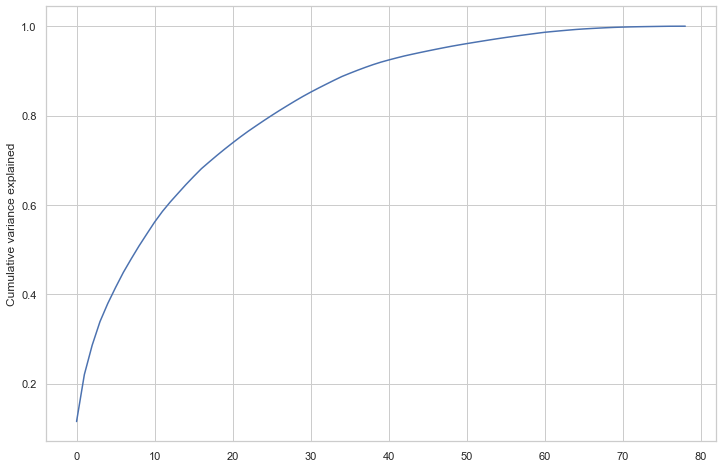

In [176]:
var_cumsum = np.cumsum(pca.explained_variance_ratio_)
fig = plt.figure(figsize=[12,8])
plt.plot(var_cumsum)
plt.ylabel("Cumulative variance explained")
plt.show()

> <span style='color:green'>**Inferences from above:** Around 95% of variance is explained by 50 features. So we will perform incremental PCA with these 50 features

### Before going for incremental PCA, performing SMOTE technique to address the class imbalance

#### Looking at the imbalance of class in Target column

In [177]:
log("Percenatge of Churned Customer data : "+str(round(100*y.sum()/len(y),2)))

> <span style='color:green'>Percenatge of Churned Customer data : 8.12</span>

#### Plotting pie chart to see the distribution of class

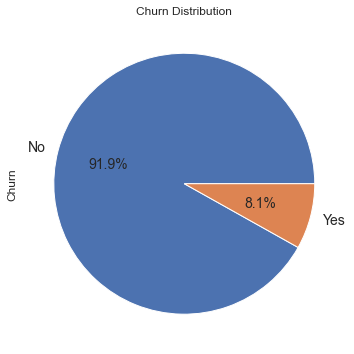

In [178]:
#Churn Distribution
pie_chart = df_final['churn'].value_counts()*100.0 /len(df_final)
ax = pie_chart.plot.pie(autopct='%.1f%%', labels = ['No', 'Yes'],figsize =(8,6), fontsize = 14 )                                                                           
ax.set_ylabel('Churn',fontsize = 12)
ax.set_title('Churn Distribution', fontsize = 12)
plt.show()

> <span style='color:green'>**Inferences from above:** As we can see from the Pie chart, the Target column is heavily imbalanced. Only 8.1% of data which shows churn. If we build model on with such imbalance in the Target column, our model will not be able to predict the churning of customers as it will be more biased towards the Non churn cusomters.

#### To handle the imbalance, we will using technique called SMOTE - Synthetic Minority Over-sampling Technique

In [179]:
### implementing smote technique on scaled dataset

smote = SMOTE(random_state=42)
X_train_scaled_smote, y_train_smote = smote.fit_resample(X_train_scaled_df, y_train)

In [180]:
### checking the shapes
X_train_scaled_smote.shape, y_train_smote.shape

((38544, 79), (38544,))

> <span style='color:green'>**Inferences from above:**Data is bloated using oversampling smote technique
    
    
> <span style='color:green'>**Inferences from above:**Imp Note - We perform smote only on trained dataset

In [181]:
y_train_smote.value_counts()

1    19272
0    19272
Name: churn, dtype: int64

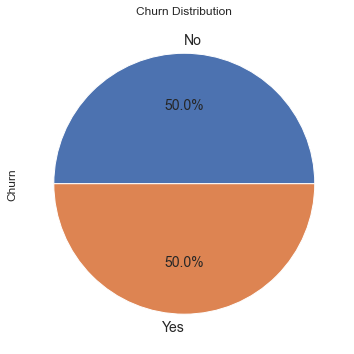

In [182]:
# rechecking Churn Distribution

pie_chart = y_train_smote.value_counts()*100.0 /len(y_train_smote)
ax = pie_chart.plot.pie(autopct='%.1f%%', labels = ['No', 'Yes'],figsize =(8,6), fontsize = 14 )                                                                           
ax.set_ylabel('Churn',fontsize = 12)
ax.set_title('Churn Distribution', fontsize = 12)
plt.show()

> <span style='color:green'>**Inferences from above:**As we can see, after applying SMOTE, the imbalance in the Target variable is addressed

#### Now fitting PCA for dimension reductionality. We will select number of components as 50 

In [183]:
pca_final = IncrementalPCA(n_components=50)
X_train_PCA = pca_final.fit_transform(X_train_scaled_smote)
X_test_PCA = pca_final.transform(X_test_scaled_df)

In [184]:
X_train_PCA.shape

(38544, 50)

In [185]:
X_test_PCA.shape

(8986, 50)

In [186]:
X_train_PCA

array([[-3.53674306,  0.96267731, -1.63696865, ...,  0.34888386,
        -0.33940692, -0.48362332],
       [ 3.28360052, -4.40551365, -4.23591841, ...,  0.15246791,
         0.17525199,  0.24578123],
       [ 0.58906407,  0.87927726, -1.18550411, ..., -0.00935249,
        -1.041978  , -0.85958052],
       ...,
       [ 0.30959152, -0.82816446,  0.0258448 , ..., -0.36719931,
         0.14030358, -0.14156379],
       [-1.05147885, -0.88508813,  1.07316462, ..., -0.54423511,
        -0.01372318, -0.41716463],
       [-1.87471508,  0.54171746, -1.00742298, ..., -0.2300414 ,
        -0.02571454,  0.00580118]])

In [187]:
X_test_PCA

array([[ 2.47771805, -0.96069454,  1.40959086, ...,  0.23473267,
         0.83503463,  0.05231574],
       [ 8.93192497,  3.98715799, -2.394044  , ..., -0.44155166,
         0.08467255,  0.37642855],
       [-3.51235148,  1.8593493 , -0.69523737, ..., -0.38331317,
        -0.21609962,  0.23477917],
       ...,
       [-0.11047831,  2.0238725 ,  0.52850338, ..., -1.13538129,
         0.02249131,  1.02684386],
       [ 3.62211062,  1.15777364, -0.63913526, ...,  1.20006743,
         1.47474464,  0.655769  ],
       [ 0.94148584, -2.67566359, -1.36390855, ...,  0.04281897,
        -0.01238527, -0.04742851]])

## Step 4.2: Building Logistic regression Model

#### a: Without hyperparameter tuning

In [188]:
lr = LogisticRegression(class_weight='balanced',random_state=42)
model_lr = lr.fit(X_train_PCA, y_train_smote)

In [189]:
#### Predicting class and probabilities on Test data
y_test_pred_prob = model_lr.predict_proba(X_test_PCA)
y_test_pred = model_lr.predict(X_test_PCA)

------ 

### Logistic Regression Model (Default) Model Stats Scores Summary : 

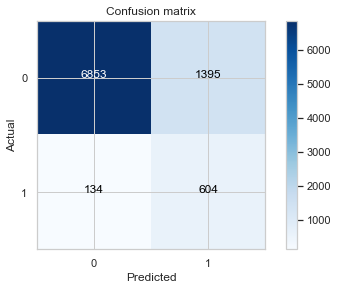

,Model,Accuracy,Recall,Precision,ROC_AUC,F1_Score
0,Logistic Regression Model (Default),0.83,0.82,0.30,0.90,0.44


In [190]:
print_model_metrics(y_test,y_test_pred,y_test_pred_prob,"Logistic Regression Model (Default)")

> <span style='color:green'>**Inferences from above: With default paramertes on LR model, we are getting AUC Score of 0.9 on test dataset which is good. Also the recall is very high and we need that because focus is more on identifying Churned customers and in that process if the misclassify few non churned customers as Churned, it doesnt impace the cusomters. But the F1_Score is low, so we will build other models and compare the scores**

#### b: Hyper-parameter tuning on LR model

In [191]:
lr_tuned = LogisticRegression(random_state=42)
solvers = ['liblinear']
penalty = ['l1', 'l2']
c_values = [0.01, 0.1, 0.3, 1.0,10] ##penalty values for regularisation

## define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
folds = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=lr_tuned, param_grid=grid, n_jobs = -1, cv = folds, scoring = 'recall', verbose = 1)
grid_search_result = grid_search.fit(X_train_PCA, y_train_smote)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


#### checking the results

In [192]:
print("Best: %f using %s" % (grid_search_result.best_score_, grid_search_result.best_params_))

Best: 0.859952 using {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


In [193]:
means = grid_search_result.cv_results_['mean_test_score']
stds = grid_search_result.cv_results_['std_test_score']
params = grid_search_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

0.858344 (0.008734) with: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
0.859797 (0.008928) with: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
0.859537 (0.008878) with: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
0.859952 (0.008641) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.859641 (0.008693) with: {'C': 0.3, 'penalty': 'l1', 'solver': 'liblinear'}
0.859900 (0.008733) with: {'C': 0.3, 'penalty': 'l2', 'solver': 'liblinear'}
0.859485 (0.008955) with: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
0.859485 (0.009078) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.859018 (0.008989) with: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
0.858966 (0.009033) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}


In [194]:
grid_search_result.best_estimator_

LogisticRegression(C=0.1, random_state=42, solver='liblinear')

#### Fitting the LR model with best hyperparameters on test dataset

In [195]:
lr_tuned_best = grid_search_result.best_estimator_

In [196]:
model_best_lr = lr_tuned_best.fit(X_train_PCA, y_train_smote)

In [197]:
#### Predicting class and probabilities on Test data

y_test_pred_prob = model_best_lr.predict_proba(X_test_PCA)
y_test_pred = model_best_lr.predict(X_test_PCA)

------ 

### Logistic Regression Model (Tuned) Model Stats Scores Summary : 

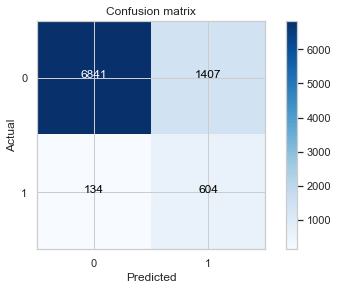

,Model,Accuracy,Recall,Precision,ROC_AUC,F1_Score
0,Logistic Regression Model (Tuned),0.83,0.82,0.30,0.90,0.44


In [198]:
print_model_metrics(y_test,y_test_pred,y_test_pred_prob,"Logistic Regression Model (Tuned)")

> <span style='color:green'>**Inferences from above: After hyper parameter tuning, we are still geting the AUC Score on test dataset = 0.9

## Step 4.3: Building Random Forest Model

#### a: Random forest without hyper parameter tuning(Default)

In [199]:
rf = RandomForestClassifier(class_weight='balanced',random_state=42)
rf.fit(X_train_PCA, y_train_smote)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [200]:
#### Predicting class and probabilities on Test data
y_test_pred_prob = rf.predict_proba(X_test_PCA)
y_test_pred = rf.predict(X_test_PCA)

------ 

### Random Forest Model (Default) Model Stats Scores Summary : 

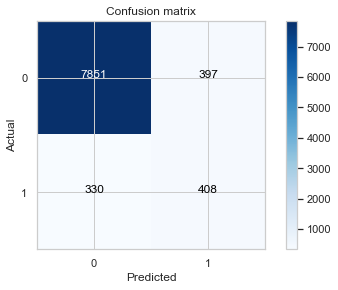

,Model,Accuracy,Recall,Precision,ROC_AUC,F1_Score
0,Random Forest Model (Default),0.92,0.55,0.51,0.90,0.53


In [201]:
print_model_metrics(y_test,y_test_pred,y_test_pred_prob,"Random Forest Model (Default)")

#### b: Random Forest with hyper parameter tuning

 - As the dataset is huge, doing hyper parameter tuning for a broader range of values together is time consuming. So, we will try RandomSearchCV to get the optimal set of Hyper parameters

In [202]:
#### Configuring the Parameters

In [203]:
# Number of trees in random forest
n_estimators = [200,250] 
# Number of features to consider at every split
max_features = ['auto']
# Maximum number of levels in tree
max_depth = [20,25,30]
# Minimum number of samples required to split a node
min_samples_split = [5,10,15]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2,4,6]

In [204]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               }

In [208]:
print(random_grid)

{'n_estimators': [200, 250], 'max_features': ['auto'], 'max_depth': [20, 25, 30], 'min_samples_split': [5, 10, 15], 'min_samples_leaf': [2, 4, 6]}


In [209]:
%%time
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(random_state=42)
# Random search of parameters, using 3 fold cross validation, 
# search across 50 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=1, random_state=42, n_jobs = -1,scoring='recall')
# Fit the random search model
rf_random.fit(X_train_PCA, y_train_smote)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Wall time: 48min 12s


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'max_depth': [20, 25, 30],
                                        'max_features': ['auto'],
                                        'min_samples_leaf': [2, 4, 6],
                                        'min_samples_split': [5, 10, 15],
                                        'n_estimators': [200, 250]},
                   random_state=42, scoring='recall', verbose=1)

In [210]:
print(rf_random.best_estimator_)

RandomForestClassifier(max_depth=25, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200, random_state=42)


In [211]:
print("Best: %f using %s" % (rf_random.best_score_, rf_random.best_params_))

Best: 0.961758 using {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 25}


In [212]:
#### Building model on the best parameter

rf_best = rf_random.best_estimator_
model_best_rf = rf_best.fit(X_train_PCA, y_train_smote)

In [213]:
#### Predicting class and probabilities on Test data

y_test_pred_prob = model_best_rf.predict_proba(X_test_PCA)
y_test_pred = model_best_rf.predict(X_test_PCA)

------ 

### Random Forest Model (Tuned) Model Stats Scores Summary : 

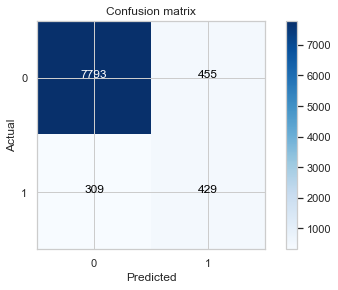

,Model,Accuracy,Recall,Precision,ROC_AUC,F1_Score
0,Random Forest Model (Tuned),0.91,0.58,0.49,0.90,0.53


In [214]:
print_model_metrics(y_test,y_test_pred,y_test_pred_prob,"Random Forest Model (Tuned)")

## Step 4.4: Build KNN model

In [215]:
# initialize the KNeighbors classifiers
model_knn = KNeighborsClassifier()
# fit the pca training data
model_knn.fit(X_train_PCA, y_train_smote)

KNeighborsClassifier()

In [216]:
#### Predicting class and probabilities on Test data
y_test_pred_prob = model_knn.predict_proba(X_test_PCA)
y_test_pred = model_knn.predict(X_test_PCA)

------ 

### KNN Model (Default) Model Stats Scores Summary : 

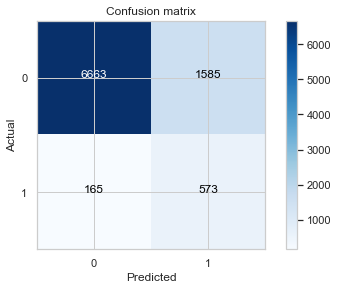

,Model,Accuracy,Recall,Precision,ROC_AUC,F1_Score
0,KNN Model (Default),0.81,0.78,0.27,0.84,0.40


In [217]:
print_model_metrics(y_test,y_test_pred,y_test_pred_prob,"KNN Model (Default)")

In [218]:
model_knn.n_neighbors

5

In [219]:
model_knn

KNeighborsClassifier()

In [220]:
knn_tuned = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',metric_params=None, n_jobs=-1, n_neighbors=15, p=2,weights='uniform')
knn_tuned_model = knn_tuned.fit(X_train_PCA, y_train_smote)

In [221]:
#### Predicting class and probabilities on Test data
y_test_pred_prob = knn_tuned_model.predict_proba(X_test_PCA)
y_test_pred = knn_tuned_model.predict(X_test_PCA)

------ 

### KNN Model (Tuned) Model Stats Scores Summary : 

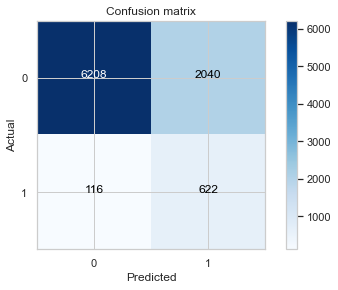

,Model,Accuracy,Recall,Precision,ROC_AUC,F1_Score
0,KNN Model (Tuned),0.76,0.84,0.23,0.87,0.37


In [222]:
print_model_metrics(y_test,y_test_pred,y_test_pred_prob,"KNN Model (Tuned)")

## Step 4.5: Ridge Classifier

#### a: Ridge without Hyper parameter tuning

In [223]:
ridge = RidgeClassifier(random_state=42)
ridge_model = ridge.fit(X_train_PCA, y_train_smote)

In [224]:
print('Alpha values for default Ridge model is = ',ridge_model.alpha)

Alpha values for default Ridge model is =  1.0


In [225]:
#### Predicting class and probabilities on Test data
#y_test_pred_prob = ridge_model.predict(X_test_PCA)
y_test_pred = ridge_model.predict(X_test_PCA)

------ 

### Ridge Model (Default) Model Stats Scores Summary : 

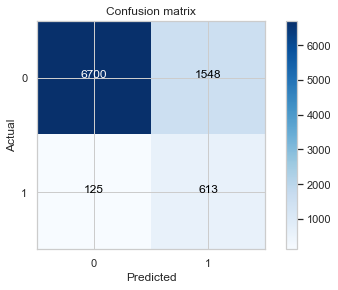

,Model,Accuracy,Recall,Precision,ROC_AUC,F1_Score
0,Ridge Model (Default),0.81,0.83,0.28,0.82,0.42


In [226]:
print_model_metrics_without_prob(y_test,y_test_pred,"Ridge Model (Default)")

#### b: Ridge with Hyper parameter tuning

In [227]:
ridge_tuned = RidgeClassifier(random_state=42)
alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0,10]

In [228]:
%%time
grid = dict(alpha=alpha)                                                                                                   
folds = StratifiedKFold(n_splits=3, random_state=42,shuffle=True)
grid_search = GridSearchCV(estimator=ridge_tuned, param_grid=grid, n_jobs=-1, cv=folds, scoring='recall')
grid_result = grid_search.fit(X_train_PCA, y_train_smote)

Wall time: 1.61 s


In [229]:
ridge_best = grid_result.best_estimator_
ridge_best

RidgeClassifier(alpha=10, random_state=42)

#### Fitting the best Ridge model 

In [230]:
ridge_best_model = ridge_best.fit(X_train_PCA, y_train_smote)

------ 

### Ridge Model (Tuned) Model Stats Scores Summary : 

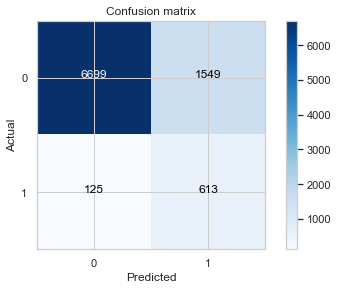

,Model,Accuracy,Recall,Precision,ROC_AUC,F1_Score
0,Ridge Model (Tuned),0.81,0.83,0.28,0.82,0.42


In [231]:
y_test_pred = ridge_best_model.predict(X_test_PCA)
print_model_metrics_without_prob(y_test,y_test_pred,"Ridge Model (Tuned)")

## Step 4.6: XGB Modellling

#### a: XGB without hyper parameter tuning

In [232]:
xgclf = xgb.XGBClassifier()

In [233]:
xgclf.fit(X_train_PCA, y_train_smote)

[13:51:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [234]:
y_test_pred_prob = xgclf.predict_proba(X_test_PCA)
y_test_pred = xgclf.predict(X_test_PCA)

------ 

### XGB Model (Default) Model Stats Scores Summary : 

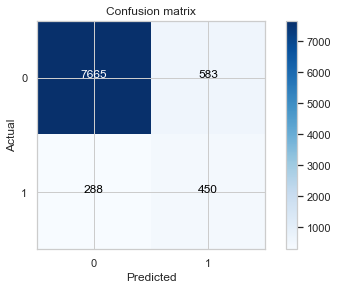

,Model,Accuracy,Recall,Precision,ROC_AUC,F1_Score
0,XGB Model (Default),0.90,0.61,0.44,0.88,0.51


In [235]:
print_model_metrics(y_test,y_test_pred,y_test_pred_prob,"XGB Model (Default)")

#### b: XGB with Hyperparameter tuning

In [236]:
# hyperparameter tuning with XGBoost

# creating a KFold object 
folds = 4

# specify range of hyperparameters
params = {'learning_rate': [0.3,0.4], 
             'subsample': [0.5,1],
             'max_depth': [2,3],
             'n_estimators': [100]
             }          
xgb_model = XGBClassifier()
# set up GridSearchCV()
model_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = params, 
                        scoring= 'recall', 
                        cv = folds, 
                        n_jobs = -1,
                        verbose = 1
                        )   

In [237]:
%%time
# fit the model
model_cv.fit(X_train_PCA, y_train_smote)    

Fitting 4 folds for each of 8 candidates, totalling 32 fits
[14:32:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 3min 42s


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight

In [238]:
# cv results
cv_results_xboost = pd.DataFrame(model_cv.cv_results_)
cv_results_xboost['param_learning_rate'] = cv_results_xboost['param_learning_rate'].astype('float')

In [239]:
# printing the optimal accuracy score and hyperparameters
log('We can get accuracy of **'+str(round(model_cv.best_score_,2))+'** using '+str(model_cv.best_params_))

> <span style='color:green'>We can get accuracy of **0.9** using {'learning_rate': 0.4, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.5}</span>

In [240]:
xgb_model_best = model_cv.best_estimator_
xgb_model_best

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.4, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

#### Fitting the best estimator on Trained dataset

In [241]:
xgb_model_tuned = xgb_model_best.fit(X_train_PCA, y_train_smote)

[14:32:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [242]:
y_test_pred_prob = xgb_model_tuned.predict_proba(X_test_PCA)
y_test_pred = xgb_model_tuned.predict(X_test_PCA)

------ 

### XGB Model (Tuned) Model Stats Scores Summary : 

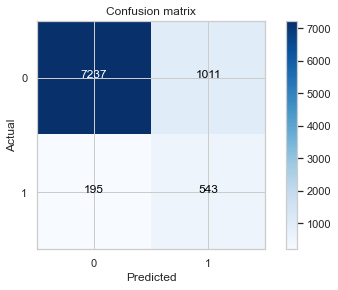

,Model,Accuracy,Recall,Precision,ROC_AUC,F1_Score
0,XGB Model (Tuned),0.87,0.74,0.35,0.88,0.47


In [243]:
print_model_metrics(y_test,y_test_pred,y_test_pred_prob,"XGB Model (Tuned)")

## Step 4.7: Extra Trees Model

#### a: Without Hyper parameter tuning

In [244]:
# initialize the ExtraTreesClassifier
model_et = ExtraTreesClassifier(class_weight='balanced', random_state= 42)
# fit the pca training data
model_et.fit(X_train_PCA, y_train_smote)

ExtraTreesClassifier(class_weight='balanced', random_state=42)

In [245]:
# predict the pca testing data
y_test_pred_prob = model_et.predict_proba(X_test_PCA)
y_test_pred = model_et.predict(X_test_PCA)

------ 

### ExtraTree Model (Default) Model Stats Scores Summary : 

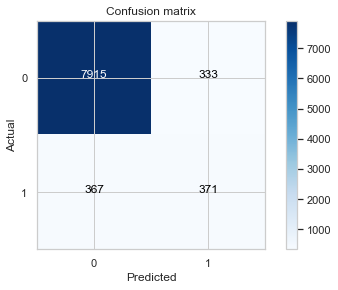

,Model,Accuracy,Recall,Precision,ROC_AUC,F1_Score
0,ExtraTree Model (Default),0.92,0.50,0.53,0.89,0.51


In [246]:
print_model_metrics(y_test,y_test_pred,y_test_pred_prob,"ExtraTree Model (Default)")

In [247]:
print(model_et.min_samples_split)

2


#### b: With Hyper parameter tuning

In [248]:
# hyperparameter tuning with Extreme Tree

# creating a KFold object 
folds = 4

# specify range of hyperparameters
params = {'n_estimators': [100,200], 
             'min_samples_split': [3,4],
             'max_depth': [2,4],
             'max_features': ['auto']
             }          
et_model = ExtraTreesClassifier(class_weight='balanced', random_state= 42)
# set up GridSearchCV()
model_cv_et = GridSearchCV(estimator = et_model, 
                        param_grid = params, 
                        scoring= 'recall', 
                        cv = folds, 
                        n_jobs = -1,
                        verbose = 1
                        )   

In [249]:
%%time
# fit the model
model_cv_et.fit(X_train_PCA, y_train_smote)

Fitting 4 folds for each of 8 candidates, totalling 32 fits
Wall time: 36.6 s


GridSearchCV(cv=4,
             estimator=ExtraTreesClassifier(class_weight='balanced',
                                            random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 4], 'max_features': ['auto'],
                         'min_samples_split': [3, 4],
                         'n_estimators': [100, 200]},
             scoring='recall', verbose=1)

In [250]:
et_model_best = model_cv_et.best_estimator_
et_model_best

ExtraTreesClassifier(class_weight='balanced', max_depth=4, min_samples_split=3,
                     random_state=42)

In [251]:
et_model_tuned = et_model_best.fit(X_train_PCA, y_train_smote)

In [252]:
y_test_pred_prob = et_model_tuned.predict_proba(X_test_PCA)
y_test_pred = et_model_tuned.predict(X_test_PCA)

------ 

### ExtraTree Model (Tuned) Model Stats Scores Summary : 

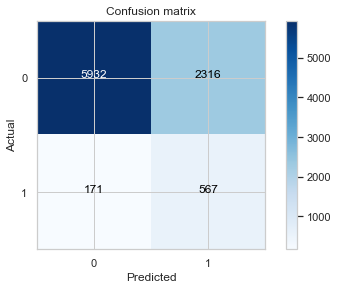

,Model,Accuracy,Recall,Precision,ROC_AUC,F1_Score
0,ExtraTree Model (Tuned),0.72,0.77,0.20,0.82,0.31


In [253]:
print_model_metrics(y_test,y_test_pred,y_test_pred_prob,"ExtraTree Model (Tuned)")

## Consolidated Summary of all Models Built

In [254]:
consolidate_summary

,Model,Accuracy,Recall,Precision,ROC_AUC,F1_Score
0,Logistic Regression Model (Default),0.83,0.82,0.30,0.90,0.44
1,Logistic Regression Model (Tuned),0.83,0.82,0.30,0.90,0.44
2,Random Forest Model (Default),0.92,0.55,0.51,0.90,0.53
3,Random Forest Model (Tuned),0.91,0.58,0.49,0.90,0.53
4,KNN Model (Default),0.81,0.78,0.27,0.84,0.40
5,KNN Model (Tuned),0.76,0.84,0.23,0.87,0.37
6,Ridge Model (Default),0.81,0.83,0.28,0.82,0.42
7,Ridge Model (Tuned),0.81,0.83,0.28,0.82,0.42
8,XGB Model (Default),0.90,0.61,0.44,0.88,0.51
9,XGB Model (Tuned),0.87,0.74,0.35,0.88,0.47


- As we can see in the summary printed above, we have built different Classifier Models for predicting the churn.
- Here, the important metrics to look out for prediction are F1 Score and Recall Score.

- Since there is imbalance in the Target variable, we cannot rely on Accuracy. Because of imabalance in the Target variable, the test results would be biased towards 0 (non churn). Even though the accuracy will be high, it will not help in identifying the churn.

- So we will use F1 score to evaluate the model. Along with that, we will look for recall_Score. 

- Recall_score tells us that out of total acutal churners, how many of the churners our model was able to predict correctly. Since the primary requirement of the business it to identify and retain the customers who are more likely to churn, so it becomes impeartive to give more weightage to recall_score as it will tell how our model is predicting the customers who are more likely to churn and it turn help business identify such customers and take action on them.

- **So, after comparing the scores, we will go ahead and choose XGB Classifier model with Hyper parameter tuning as final model to be used for Telecom Churn prediction. XGB Model gives us good recall score and F1 Score. Also the ROC_AUC score is good**



### Final Selected Model

In [255]:
consolidate_summary[consolidate_summary['Model'] == 'XGB Model (Tuned)']

,Model,Accuracy,Recall,Precision,ROC_AUC,F1_Score
9,XGB Model (Tuned),0.87,0.74,0.35,0.88,0.47


## Step 5: Identifying Strong Predictors of churn (Important features)

In [256]:
df_final.head()

,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,total_rech_data_8,max_rech_data_8,av_rech_amt_data_8,vol_2g_mb_8,vol_3g_mb_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,aon,vbc_3g_8,total_rech_amt_data_8,churn,avg_arpu_6_7,avg_onnet_mou_6_7,avg_offnet_mou_6_7,avg_roam_ic_mou_6_7,avg_roam_og_mou_6_7,avg_loc_og_t2t_mou_6_7,avg_loc_og_t2m_mou_6_7,avg_loc_og_t2f_mou_6_7,avg_loc_og_t2c_mou_6_7,avg_std_og_t2t_mou_6_7,avg_std_og_t2m_mou_6_7,avg_std_og_t2f_mou_6_7,avg_isd_og_mou_6_7,avg_spl_og_mou_6_7,avg_og_others_6_7,avg_loc_ic_t2t_mou_6_7,avg_loc_ic_t2m_mou_6_7,avg_loc_ic_t2f_mou_6_7,avg_std_ic_t2t_mou_6_7,avg_std_ic_t2m_mou_6_7,avg_std_ic_t2f_mou_6_7,avg_spl_ic_mou_6_7,avg_isd_ic_mou_6_7,avg_ic_others_6_7,avg_total_rech_num_6_7,avg_total_rech_amt_6_7,avg_max_rech_amt_6_7,avg_last_day_rch_amt_6_7,avg_total_rech_data_6_7,avg_max_rech_data_6_7,avg_av_rech_amt_data_6_7,avg_vol_2g_mb_6_7,avg_vol_3g_mb_6_7,avg_monthly_2g_6_7,avg_sachet_2g_6_7,avg_monthly_3g_6_7,avg_sachet_3g_6_7,avg_vbc_3g_6_7,avg_total_rech_amt_data_6_7
0,213.80,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.16,4.13,1.15,0.00,0.00,0.00,0.00,0.00,0.00,2,252.00,252,252,1.00,252.00,252.00,5.75,109.61,0,0,1,0,968,30.40,252.00,1,206.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.50,307.00,252.00,252.00,1.00,252.00,252.00,15.72,117.16,0.00,0.00,1.00,0.00,50.60,252.00
7,"1,986.74",52.29,325.91,31.64,38.06,40.28,162.28,53.23,0.00,12.01,49.14,16.68,10.01,6.50,0.00,27.31,121.19,39.53,30.39,141.33,22.21,0.00,31.59,15.14,7,"2,341.48",951,565,0.00,0.00,0.00,0.00,0.00,0,0,0,0,802,57.74,0.00,1,"1,209.51",56.26,510.29,24.86,18.16,41.38,378.00,58.64,0.00,13.79,40.83,13.37,0.09,2.25,0.00,45.20,219.53,126.81,24.36,109.22,43.22,0.10,8.29,15.46,5.00,"1,185.00",895.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,19.06,0.00
8,137.36,35.08,136.48,0.00,0.00,12.49,50.54,0.00,7.15,22.58,75.69,0.00,0.00,10.23,0.00,0.31,15.48,0.00,0.10,0.65,0.00,0.00,0.00,0.00,14,120.00,30,10,3.00,23.00,69.00,0.03,11.94,0,3,0,0,315,21.03,207.00,0,435.47,382.36,87.64,0.00,0.00,257.36,75.77,0.00,0.00,125.00,11.86,0.00,0.00,0.00,0.00,16.84,35.78,0.00,0.29,13.25,0.00,0.00,0.00,0.00,20.00,519.00,122.00,25.00,1.00,77.00,88.50,178.00,375.48,0.50,0.50,0.00,0.00,516.40,177.00
21,637.76,85.14,983.39,0.00,0.00,23.34,104.81,1.58,0.00,61.79,876.99,0.00,0.00,0.00,0.00,19.54,129.16,10.39,0.18,101.74,0.00,0.00,0.00,0.00,27,718.00,50,50,0.00,0.00,0.00,0.00,0.00,0,0,0,0,720,0.00,0.00,0,556.10,117.26,827.30,0.00,0.00,5.32,89.87,0.38,0.00,111.94,737.05,0.00,0.00,0.00,0.00,6.33,96.43,3.73,10.02,52.96,0.00,0.00,0.00,0.00,24.00,640.00,50.00,25.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
23,366.97,33.58,205.89,0.00,0.00,33.58,148.56,0.00,17.71,0.00,39.61,0.00,0.00,17.71,0.00,76.64,146.84,0.71,13.38,43.91,0.00,0.00,3.74,13.06,4,439.00,179,0,2.00,179.00,270.00,0.01,"1,009.92",0,0,1,1,604,40.45,540.00,0,134.12,49.81,87.38,0.00,0.00,49.81,82.97,0.00,0.00,0.00,4.35,0.00,0.01,0.05,0.00,40.88,104.63,0.00,0.26,8.66,0.00,0.00,14.12,2.67,4.00,227.00,89.50,89.50,1.00,89.50,178.00,0.24,299.55,0.00,0.00,1.00,0.00,25.93,356.00


In [257]:
df_imp_features = df_final.copy()

In [258]:
df_imp_features.head()

,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,total_rech_data_8,max_rech_data_8,av_rech_amt_data_8,vol_2g_mb_8,vol_3g_mb_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,aon,vbc_3g_8,total_rech_amt_data_8,churn,avg_arpu_6_7,avg_onnet_mou_6_7,avg_offnet_mou_6_7,avg_roam_ic_mou_6_7,avg_roam_og_mou_6_7,avg_loc_og_t2t_mou_6_7,avg_loc_og_t2m_mou_6_7,avg_loc_og_t2f_mou_6_7,avg_loc_og_t2c_mou_6_7,avg_std_og_t2t_mou_6_7,avg_std_og_t2m_mou_6_7,avg_std_og_t2f_mou_6_7,avg_isd_og_mou_6_7,avg_spl_og_mou_6_7,avg_og_others_6_7,avg_loc_ic_t2t_mou_6_7,avg_loc_ic_t2m_mou_6_7,avg_loc_ic_t2f_mou_6_7,avg_std_ic_t2t_mou_6_7,avg_std_ic_t2m_mou_6_7,avg_std_ic_t2f_mou_6_7,avg_spl_ic_mou_6_7,avg_isd_ic_mou_6_7,avg_ic_others_6_7,avg_total_rech_num_6_7,avg_total_rech_amt_6_7,avg_max_rech_amt_6_7,avg_last_day_rch_amt_6_7,avg_total_rech_data_6_7,avg_max_rech_data_6_7,avg_av_rech_amt_data_6_7,avg_vol_2g_mb_6_7,avg_vol_3g_mb_6_7,avg_monthly_2g_6_7,avg_sachet_2g_6_7,avg_monthly_3g_6_7,avg_sachet_3g_6_7,avg_vbc_3g_6_7,avg_total_rech_amt_data_6_7
0,213.80,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.16,4.13,1.15,0.00,0.00,0.00,0.00,0.00,0.00,2,252.00,252,252,1.00,252.00,252.00,5.75,109.61,0,0,1,0,968,30.40,252.00,1,206.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.50,307.00,252.00,252.00,1.00,252.00,252.00,15.72,117.16,0.00,0.00,1.00,0.00,50.60,252.00
7,"1,986.74",52.29,325.91,31.64,38.06,40.28,162.28,53.23,0.00,12.01,49.14,16.68,10.01,6.50,0.00,27.31,121.19,39.53,30.39,141.33,22.21,0.00,31.59,15.14,7,"2,341.48",951,565,0.00,0.00,0.00,0.00,0.00,0,0,0,0,802,57.74,0.00,1,"1,209.51",56.26,510.29,24.86,18.16,41.38,378.00,58.64,0.00,13.79,40.83,13.37,0.09,2.25,0.00,45.20,219.53,126.81,24.36,109.22,43.22,0.10,8.29,15.46,5.00,"1,185.00",895.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,19.06,0.00
8,137.36,35.08,136.48,0.00,0.00,12.49,50.54,0.00,7.15,22.58,75.69,0.00,0.00,10.23,0.00,0.31,15.48,0.00,0.10,0.65,0.00,0.00,0.00,0.00,14,120.00,30,10,3.00,23.00,69.00,0.03,11.94,0,3,0,0,315,21.03,207.00,0,435.47,382.36,87.64,0.00,0.00,257.36,75.77,0.00,0.00,125.00,11.86,0.00,0.00,0.00,0.00,16.84,35.78,0.00,0.29,13.25,0.00,0.00,0.00,0.00,20.00,519.00,122.00,25.00,1.00,77.00,88.50,178.00,375.48,0.50,0.50,0.00,0.00,516.40,177.00
21,637.76,85.14,983.39,0.00,0.00,23.34,104.81,1.58,0.00,61.79,876.99,0.00,0.00,0.00,0.00,19.54,129.16,10.39,0.18,101.74,0.00,0.00,0.00,0.00,27,718.00,50,50,0.00,0.00,0.00,0.00,0.00,0,0,0,0,720,0.00,0.00,0,556.10,117.26,827.30,0.00,0.00,5.32,89.87,0.38,0.00,111.94,737.05,0.00,0.00,0.00,0.00,6.33,96.43,3.73,10.02,52.96,0.00,0.00,0.00,0.00,24.00,640.00,50.00,25.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
23,366.97,33.58,205.89,0.00,0.00,33.58,148.56,0.00,17.71,0.00,39.61,0.00,0.00,17.71,0.00,76.64,146.84,0.71,13.38,43.91,0.00,0.00,3.74,13.06,4,439.00,179,0,2.00,179.00,270.00,0.01,"1,009.92",0,0,1,1,604,40.45,540.00,0,134.12,49.81,87.38,0.00,0.00,49.81,82.97,0.00,0.00,0.00,4.35,0.00,0.01,0.05,0.00,40.88,104.63,0.00,0.26,8.66,0.00,0.00,14.12,2.67,4.00,227.00,89.50,89.50,1.00,89.50,178.00,0.24,299.55,0.00,0.00,1.00,0.00,25.93,356.00


In [259]:
df_imp_features.shape

(29953, 80)

In [260]:
### Splitting the Dependent and Independent Features

X = df_imp_features.drop('churn', axis = 1)
y = df_imp_features['churn']

In [261]:
X.shape , y.shape

((29953, 79), (29953,))

In [262]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier

#### Using Random Forest model to identify the weightage of each feature. We will fit the Random Forest model on Dataset witout PCA

In [263]:
model_rf = RandomForestClassifier(n_jobs = -1, random_state=42)
model_rf.fit(X, y)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [264]:
# Check the feature importance score for each feature
feature_imp_df = pd.DataFrame({'Feature':X.columns, 'Score':model_rf.feature_importances_})
# Order the features by max score
feature_imp_df = feature_imp_df.sort_values('Score', ascending=False).reset_index()
feature_imp_df.head(50)

,index,Feature,Score
0,16,loc_ic_t2m_mou_8,0.09
1,15,loc_ic_t2t_mou_8,0.05
2,0,arpu_8,0.04
3,25,total_rech_amt_8,0.04
4,26,max_rech_amt_8,0.03
5,6,loc_og_t2m_mou_8,0.03
6,2,offnet_mou_8,0.03
7,27,last_day_rch_amt_8,0.02
8,4,roam_og_mou_8,0.02
9,1,onnet_mou_8,0.02


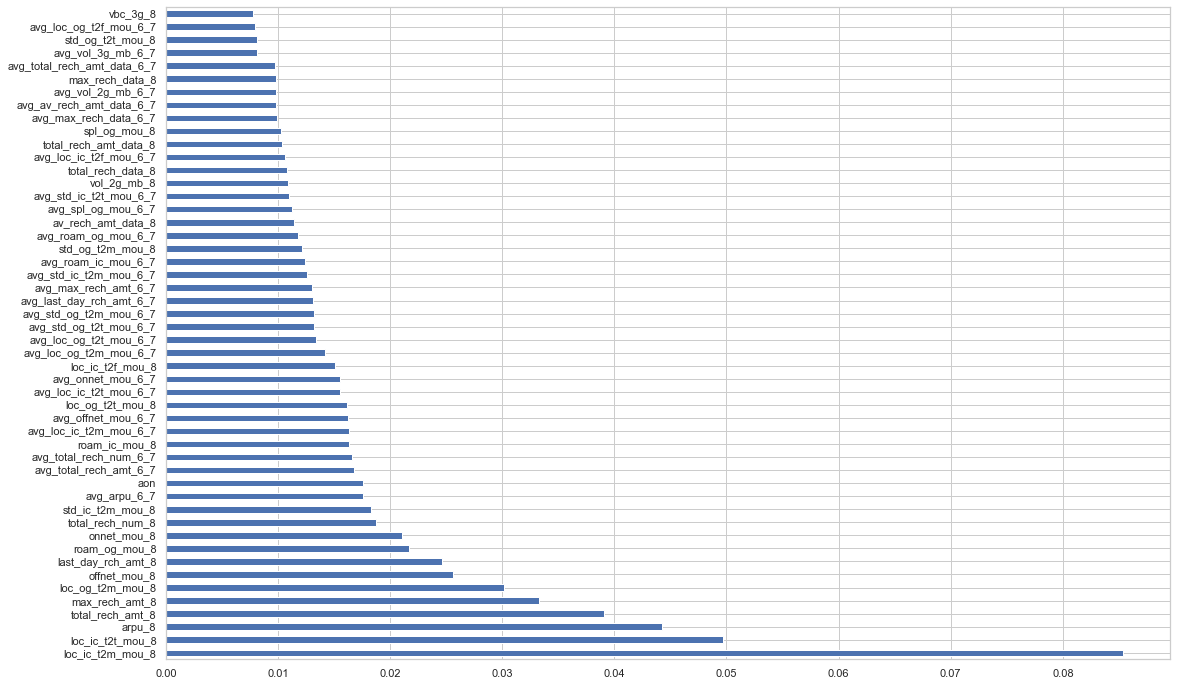

In [265]:
# plot the chart with top 50 important features
(pd.Series(model_rf.feature_importances_, index=X.columns).nlargest(50).plot(kind='barh', figsize=(18,12))) 
plt.show()

In [266]:
### Fetching the Top 50 Features
top_50_features = feature_imp_df[:50]['Feature']
X[top_50_features].corr()

,loc_ic_t2m_mou_8,loc_ic_t2t_mou_8,arpu_8,total_rech_amt_8,max_rech_amt_8,loc_og_t2m_mou_8,offnet_mou_8,last_day_rch_amt_8,roam_og_mou_8,onnet_mou_8,total_rech_num_8,std_ic_t2m_mou_8,avg_arpu_6_7,aon,avg_total_rech_amt_6_7,avg_total_rech_num_6_7,roam_ic_mou_8,avg_loc_ic_t2m_mou_6_7,avg_offnet_mou_6_7,loc_og_t2t_mou_8,avg_loc_ic_t2t_mou_6_7,avg_onnet_mou_6_7,loc_ic_t2f_mou_8,avg_loc_og_t2m_mou_6_7,avg_loc_og_t2t_mou_6_7,avg_std_og_t2t_mou_6_7,avg_std_og_t2m_mou_6_7,avg_last_day_rch_amt_6_7,avg_max_rech_amt_6_7,avg_std_ic_t2m_mou_6_7,avg_roam_ic_mou_6_7,std_og_t2m_mou_8,avg_roam_og_mou_6_7,av_rech_amt_data_8,avg_spl_og_mou_6_7,avg_std_ic_t2t_mou_6_7,vol_2g_mb_8,total_rech_data_8,avg_loc_ic_t2f_mou_6_7,total_rech_amt_data_8,spl_og_mou_8,avg_max_rech_data_6_7,avg_av_rech_amt_data_6_7,avg_vol_2g_mb_6_7,max_rech_data_8,avg_total_rech_amt_data_6_7,avg_vol_3g_mb_6_7,std_og_t2t_mou_8,avg_loc_og_t2f_mou_6_7,vbc_3g_8
loc_ic_t2m_mou_8,1.00,0.37,0.30,0.29,0.19,0.61,0.28,0.18,-0.08,0.01,0.10,0.13,0.22,0.21,0.21,0.02,-0.05,0.82,0.18,0.25,0.32,-0.05,0.28,0.53,0.21,-0.15,-0.11,0.14,0.14,0.09,0.01,-0.05,-0.04,0.04,0.00,0.04,-0.03,-0.03,0.26,-0.02,0.04,0.03,-0.01,-0.05,0.07,-0.06,-0.01,-0.09,0.23,0.06
loc_ic_t2t_mou_8,0.37,1.00,0.22,0.22,0.13,0.28,0.12,0.12,-0.04,0.16,0.08,0.08,0.16,0.13,0.16,0.02,-0.02,0.34,0.06,0.50,0.81,0.11,0.16,0.24,0.44,-0.08,-0.08,0.08,0.09,0.06,0.02,-0.03,-0.02,0.02,0.01,0.03,-0.03,-0.03,0.15,-0.02,0.04,0.03,-0.01,-0.05,0.05,-0.05,-0.01,-0.04,0.14,0.04
arpu_8,0.30,0.22,1.00,0.94,0.47,0.47,0.63,0.36,0.21,0.45,0.43,0.22,0.67,0.10,0.68,0.20,0.15,0.22,0.41,0.31,0.15,0.27,0.10,0.33,0.21,0.19,0.22,0.28,0.31,0.14,0.14,0.39,0.17,0.21,0.07,0.14,-0.02,-0.02,0.07,0.13,0.13,0.02,0.00,-0.11,0.18,-0.04,0.09,0.35,0.20,0.16
total_rech_amt_8,0.29,0.22,0.94,1.00,0.53,0.45,0.61,0.42,0.20,0.44,0.44,0.21,0.66,0.09,0.64,0.20,0.14,0.21,0.39,0.30,0.15,0.26,0.09,0.32,0.20,0.18,0.21,0.23,0.25,0.13,0.13,0.39,0.17,0.21,0.06,0.13,-0.01,-0.01,0.07,0.13,0.13,0.02,0.00,-0.10,0.18,-0.03,0.09,0.34,0.17,0.15
max_rech_amt_8,0.19,0.13,0.47,0.53,1.00,0.26,0.19,0.62,0.10,0.08,-0.17,0.14,0.34,0.20,0.33,-0.28,0.11,0.16,0.10,0.16,0.10,0.00,0.13,0.21,0.11,-0.05,-0.04,0.48,0.67,0.10,0.09,0.03,0.07,0.31,-0.03,0.07,0.01,-0.09,0.13,0.05,-0.00,0.30,0.20,-0.05,0.42,-0.02,0.23,0.01,0.29,0.25
loc_og_t2m_mou_8,0.61,0.28,0.47,0.45,0.26,1.00,0.54,0.24,-0.04,0.07,0.13,0.08,0.35,0.22,0.36,0.03,-0.05,0.53,0.39,0.36,0.23,0.00,0.19,0.82,0.30,-0.12,-0.07,0.21,0.20,0.04,0.01,-0.01,-0.01,-0.02,0.00,0.00,-0.07,-0.09,0.16,-0.06,0.04,-0.04,-0.09,-0.11,0.01,-0.12,-0.05,-0.06,0.28,0.02
offnet_mou_8,0.28,0.12,0.63,0.61,0.19,0.54,1.00,0.17,0.12,0.17,0.33,0.26,0.46,0.03,0.48,0.18,0.07,0.21,0.75,0.18,0.07,0.08,0.06,0.40,0.12,0.04,0.59,0.14,0.10,0.19,0.09,0.81,0.13,-0.13,0.07,0.05,-0.10,-0.14,0.04,-0.11,0.13,-0.19,-0.22,-0.15,-0.12,-0.18,-0.14,0.11,0.12,-0.07
last_day_rch_amt_8,0.18,0.12,0.36,0.42,0.62,0.24,0.17,1.00,0.05,0.07,-0.19,0.08,0.25,0.19,0.25,-0.25,0.05,0.14,0.08,0.13,0.08,0.01,0.11,0.19,0.10,-0.04,-0.05,0.42,0.44,0.05,0.05,0.03,0.04,0.19,-0.04,0.03,-0.03,-0.12,0.11,0.01,-0.02,0.19,0.12,-0.07,0.26,-0.05,0.14,0.02,0.24,0.16
roam_og_mou_8,-0.08,-0.04,0.21,0.20,0.10,-0.04,0.12,0.05,1.00,0.08,0.03,0.04,0.20,0.00,0.21,0.02,0.79,-0.03,0.13,-0.02,-0.01,0.11,-0.04,-0.00,0.01,0.07,0.08,0.08,0.08,0.08,0.45,0.03,0.52,-0.05,-0.00,0.09,-0.02,-0.07,-0.03,-0.05,-0.03,-0.05,-0.06,-0.04,-0.03,-0.06,-0.03,0.01,0.00,-0.02
onnet_mou_8,0.01,0.16,0.45,0.44,0.08,0.07,0.17,0.07,0.08,1.00,0.31,0.06,0.33,-0.03,0.34,0.20,0.03,-0.04,0.09,0.42,0.11,0.78,-0.01,0.02,0.32,0.67,0.09,0.03,-0.01,0.02,0.06,0.15,0.10,-0.15,0.08,0.17,-0.09,-0.12,-0.02,-0.10,0.14,-0.21,-0.22,-0.14,-0.15,-0.16,-0.14,0.87,-0.03,-0.10


In [267]:
cor_matrix = X[top_50_features].corr().corr().abs()

In [268]:
### Identify highly collerated vairables and dropping such variables to handle multicollinearity

threshold = 0.70


columns = np.full((cor_matrix.shape[0],), True, dtype=bool)
for i in range(cor_matrix.shape[0]):
    for j in range(i+1, cor_matrix.shape[0]):
        if cor_matrix.iloc[i,j] >= threshold:
            if columns[j]:
                columns[j] = False
selected_columns = X[top_50_features].columns[columns]
selected_columns
X_uncorr_df = X[selected_columns]

In [269]:
X_uncorr_df.head()

,loc_ic_t2m_mou_8,loc_ic_t2t_mou_8,arpu_8,max_rech_amt_8,roam_og_mou_8,onnet_mou_8,total_rech_num_8,std_ic_t2m_mou_8,aon,loc_ic_t2f_mou_8,av_rech_amt_data_8,avg_spl_og_mou_6_7,avg_std_ic_t2t_mou_6_7,vol_2g_mb_8,avg_loc_og_t2f_mou_6_7
0,4.13,0.16,213.80,252,0.00,0.00,2,0.00,968,1.15,252.00,0.00,0.00,5.75,0.00
7,121.19,27.31,"1,986.74",951,38.06,52.29,7,141.33,802,39.53,0.00,2.25,24.36,0.00,58.64
8,15.48,0.31,137.36,30,0.00,35.08,14,0.65,315,0.00,69.00,0.00,0.29,0.03,0.00
21,129.16,19.54,637.76,50,0.00,85.14,27,101.74,720,10.39,0.00,0.00,10.02,0.00,0.38
23,146.84,76.64,366.97,179,0.00,33.58,4,43.91,604,0.71,270.00,0.05,0.26,0.01,0.00


In [270]:
len(X_uncorr_df.columns)

15

In [271]:
X_uncorr_df.columns

Index(['loc_ic_t2m_mou_8', 'loc_ic_t2t_mou_8', 'arpu_8', 'max_rech_amt_8',
       'roam_og_mou_8', 'onnet_mou_8', 'total_rech_num_8', 'std_ic_t2m_mou_8',
       'aon', 'loc_ic_t2f_mou_8', 'av_rech_amt_data_8', 'avg_spl_og_mou_6_7',
       'avg_std_ic_t2t_mou_6_7', 'vol_2g_mb_8', 'avg_loc_og_t2f_mou_6_7'],
      dtype='object')

#### Applying VIF to check for multicollinearity among the top 15 selected columns

In [272]:
#Performing VIF
vif = pd.DataFrame()
vif['Features'] = X_uncorr_df.columns
vif['VIF'] = [variance_inflation_factor(X_uncorr_df.values,i) for i in range(X_uncorr_df.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF' ,ascending = False)
print(vif)

                  Features                  VIF
2                   arpu_8                 7.27
3           max_rech_amt_8                 3.54
6         total_rech_num_8                 3.13
0         loc_ic_t2m_mou_8                 2.28
8                      aon                 2.26
5              onnet_mou_8                 2.00
10      av_rech_amt_data_8                 1.93
1         loc_ic_t2t_mou_8                 1.63
14  avg_loc_og_t2f_mou_6_7                 1.51
7         std_ic_t2m_mou_8                 1.39
12  avg_std_ic_t2t_mou_6_7                 1.32
9         loc_ic_t2f_mou_8                 1.29
13             vol_2g_mb_8                 1.28
4            roam_og_mou_8                 1.17
11      avg_spl_og_mou_6_7                 1.16


In [273]:
X_uncorr_df = X_uncorr_df.drop(columns = 'arpu_8', axis = 1)

In [274]:
#Performing VIF
vif = pd.DataFrame()
vif['Features'] = X_uncorr_df.columns
vif['VIF'] = [variance_inflation_factor(X_uncorr_df.values,i) for i in range(X_uncorr_df.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF' ,ascending = False)
print(vif)

                  Features                  VIF
2           max_rech_amt_8                 2.77
7                      aon                 2.26
5         total_rech_num_8                 2.25
0         loc_ic_t2m_mou_8                 2.18
9       av_rech_amt_data_8                 1.85
4              onnet_mou_8                 1.67
1         loc_ic_t2t_mou_8                 1.63
13  avg_loc_og_t2f_mou_6_7                 1.48
6         std_ic_t2m_mou_8                 1.37
11  avg_std_ic_t2t_mou_6_7                 1.32
8         loc_ic_t2f_mou_8                 1.29
12             vol_2g_mb_8                 1.27
10      avg_spl_og_mou_6_7                 1.16
3            roam_og_mou_8                 1.11


### After VIF, we have identified the Top 14 Uncorelated features from the Dataset. On these features, we will build Random Forest Model to identify the feature importance and draw inferences from it

## Step 5.1 : Perform scaling on the data for top 14 selected features

In [275]:
scaler = StandardScaler()
X_uncorr_scaled = scaler.fit_transform(X_uncorr_df)

## converting in Dataframe
X_uncorr_scaled_df = pd.DataFrame(data = X_uncorr_scaled, columns= X_uncorr_df.columns)
X_uncorr_scaled_df.head()

,loc_ic_t2m_mou_8,loc_ic_t2t_mou_8,max_rech_amt_8,roam_og_mou_8,onnet_mou_8,total_rech_num_8,std_ic_t2m_mou_8,aon,loc_ic_t2f_mou_8,av_rech_amt_data_8,avg_spl_og_mou_6_7,avg_std_ic_t2t_mou_6_7,vol_2g_mb_8,avg_loc_og_t2f_mou_6_7
0,-0.77,-0.59,0.65,-0.26,-0.58,-0.92,-0.45,-0.25,-0.31,0.77,-0.37,-0.42,-0.38,-0.44
1,-0.11,-0.30,5.45,0.36,-0.44,-0.33,2.20,-0.43,0.58,-0.69,-0.24,0.43,-0.40,4.06
2,-0.70,-0.59,-0.87,-0.26,-0.49,0.49,-0.43,-0.93,-0.33,-0.29,-0.37,-0.41,-0.40,-0.44
3,-0.07,-0.39,-0.74,-0.26,-0.36,2.02,1.46,-0.51,-0.09,-0.69,-0.37,-0.07,-0.40,-0.41
4,0.03,0.21,0.15,-0.26,-0.49,-0.69,0.38,-0.63,-0.32,0.88,-0.37,-0.41,-0.40,-0.44


In [276]:
X_uncorr_scaled_df.shape

(29953, 14)

#### Splitting the Dataset in train and test set

In [277]:
X_train, X_test, y_train, y_test = train_test_split(X_uncorr_scaled_df, y, test_size=0.3, train_size=0.7, random_state=42)

In [278]:
print('Train set shapes after split',X_train.shape, y_train.shape)
print('Test set shapes after split',X_test.shape, y_test.shape)

Train set shapes after split (20967, 14) (20967,)
Test set shapes after split (8986, 14) (8986,)


## Step 5.2: Applying SMOTE technique to handle imbalance in the predictor variable

In [279]:
### implementing smote technique

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [280]:
X_train_smote.shape, y_train_smote.shape

((38544, 14), (38544,))

In [281]:
print('Class Balance count : ',Counter(y_train_smote))

Class Balance count :  Counter({0: 19272, 1: 19272})


In [282]:
print('Y_train :', Counter(y_train_smote))

Y_train : Counter({0: 19272, 1: 19272})


## Step 5.3 : Build Random Forest Model

In [283]:
model_rf_feature = RandomForestClassifier( class_weight='balanced', criterion='gini', max_depth=30, max_features='auto',
             min_samples_leaf=10, min_samples_split=10, 
            n_estimators=250, n_jobs=-1, oob_score=True, random_state=42, verbose=1)
model_rf_feature.fit(X_train_smote, y_train_smote)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    6.3s finished


RandomForestClassifier(class_weight='balanced', max_depth=30,
                       min_samples_leaf=10, min_samples_split=10,
                       n_estimators=250, n_jobs=-1, oob_score=True,
                       random_state=42, verbose=1)

In [284]:
y_test_pred = model_rf_feature.predict(X_test)
y_test_pred_prob = model_rf_feature.predict_proba(X_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.1s finished


#### Evaluating Model

In [285]:
# Classification Report
print('\nClassification Report : \n\n', classification_report(y_test, y_test_pred))


Classification Report : 

               precision    recall  f1-score   support

           0       0.97      0.92      0.95      8248
           1       0.46      0.73      0.56       738

    accuracy                           0.91      8986
   macro avg       0.72      0.83      0.75      8986
weighted avg       0.93      0.91      0.92      8986



In [286]:
accuracy_score(y_test, y_test_pred)

0.9064099710661029

In [287]:
recall_score(y_test, y_test_pred)

0.7276422764227642

In [288]:

roc_auc_score(y_test,y_test_pred_prob[:,1])

0.9087369295734665

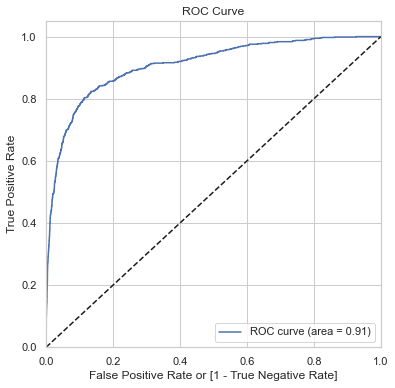

In [289]:
fpr, tpr, thresholds = roc_curve( y_test, y_test_pred_prob[:,1], drop_intermediate = False )
auc_score = roc_auc_score( y_test, y_test_pred_prob[:,1] )
plt.figure(figsize=(6, 6))
plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## Step 6 : Recommendations to Business on managing Customer Churn

### Plotting pie chart 

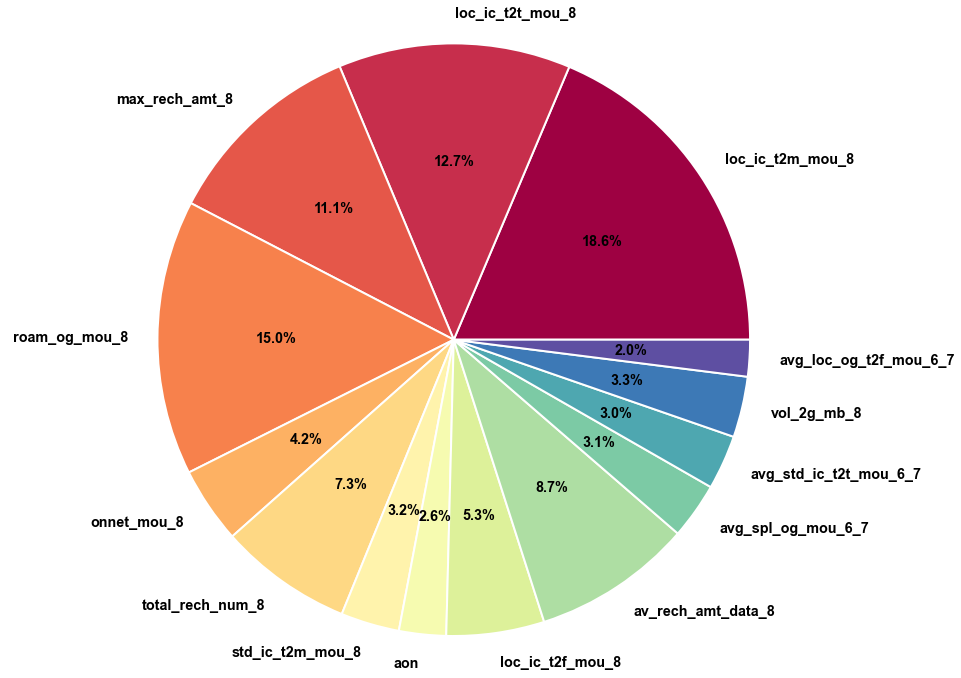

In [290]:
cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0, 1, 14)]
plt.figure(figsize=(16,12))
patches, texts, pcts = plt.pie(model_rf_feature.feature_importances_, labels=X_train.columns, autopct='%.1f%%', shadow=False, colors=colors,wedgeprops={'linewidth': 2.0, 'edgecolor': 'white'},textprops={'size': 'large'})
plt.setp(texts, color='black', fontweight='bold')
plt.setp(pcts, color='black', fontweight='bold')

plt.axis('equal')
plt.show()

### Plotting displot for Churn flag for each top 14 selected features

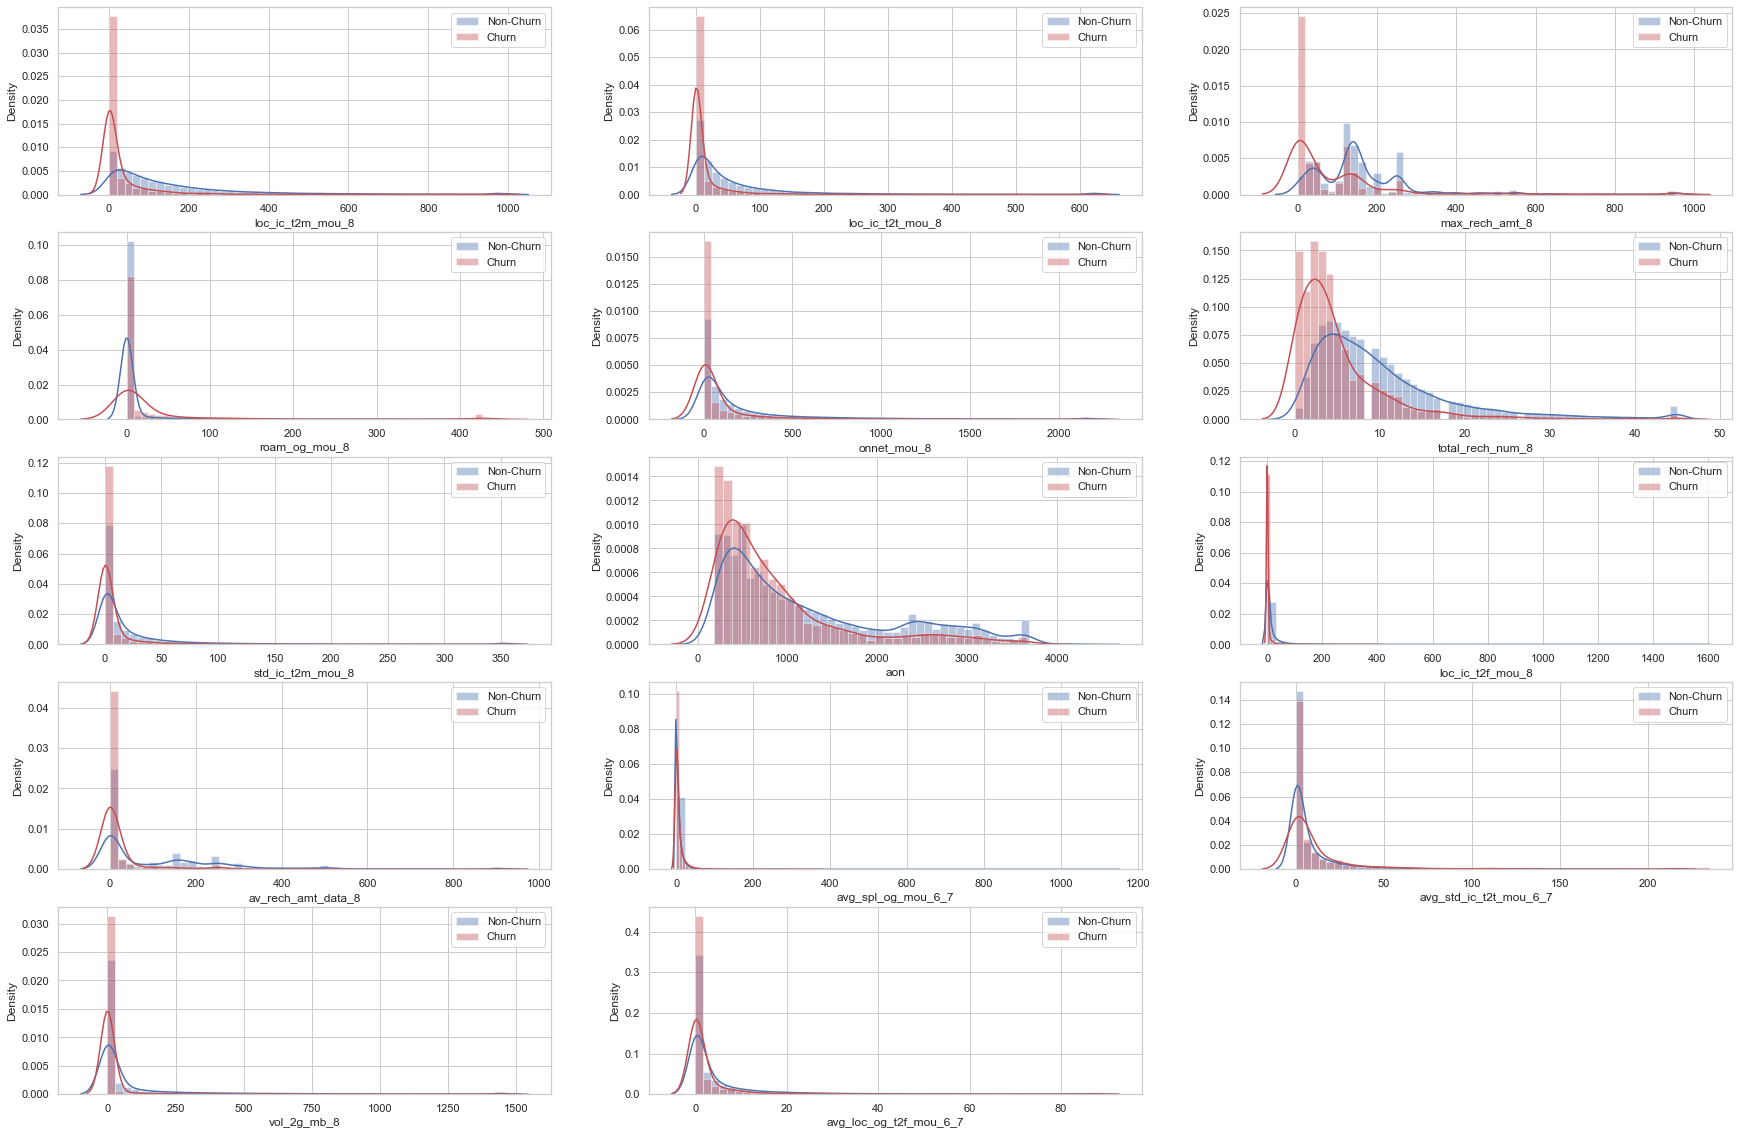

In [291]:
# Data preparation
data = df_final.copy()

#selected final list of features
cols = X_uncorr_df.columns

data = data[cols]
data['churn'] = df_final['churn']

plt.figure(figsize=(30,20))

for i, col in enumerate(cols):

    plt.subplot(5,3,i+1)
    plt.xlabel(col)
    ax = sns.distplot(data.loc[data['churn']==0, [col]], color='b', label='Non-Churn',rug = False)
    ax = sns.distplot(data.loc[data['churn']==1, [col]], color='r', label='Churn',rug = False)
    ax.legend()
    
    #plt.title('{0} dist plot'.format(col))

### Suggestions/Strategies:

**Below mentioned features are major indicators to identify when a particular customer tend to chrun**

- It can seen from the pie chart, feature **'Local Incoming calls from other network in 8th month'** is one of the very important feature to understand whether a Customer will churn or not churn. From the distplot, it can be noticed that, there is large chunk of churners who have very less minutes of incoming calls. This shows that they are either not happy with the current network and are exploring different options, hence the reduced number of minutes of Incoming calls from other network. Or other reason could be they are no more using the number and have already switched to some other network.
- Same is the case with incoming calss from the same network in 8th month. Lower value for **'Local Incoming calls from other network in 8th month'** got more churn rate
- Operator should take immediate actions on such customers by taking feedback from them about the service, understand why there is reduced usage and what they are not happy about. 


- Another important feature is **'Maximum Recharge amount in 8th Month'**. Among Churners, there is high density of customers who have not done any recharge or have done recharge of very less amount. This is an clear indication to business that customers who dont recharge or opt for lesser amount of recharge in the action phase are likely to churn. So actions can be taken by business like offering discounts on recharges, giving out coupons or recharge vouchers, giving away free talktime.


- **'Roaming Outgoing minutes of Usage in 8th Month'-** The customers who dont use the outgoing service when on roaming tend to churn more. This could be because of higher outgoing call rates when in roaming. And if someone who is regularly on roaming due to business or family reasons could think of switching the network due to higher roaming rates. Business can identify such customers, see their history of being into roaming (travelling to other states) and provide with good offers like discount on roaming outgoing calls.

- Another good indicator is **total recharge number in 8th Month** feature. Here we can clearly see that customers whose total recharge is very less in 8th month are most likely to chrun. This shows they are not happy with the serivces provided or not happy with the recharge rates. Target such customers by giving them recharge discounts, recharge vouchers



**Apart from above features which are major contributors, there are few other variables as well which can be looked into by the business to retain the customers which are likely to churn**

- **STD Incoming T2M Minutes of usage** feature shows that fewer STD incoming calls from other networks can also lead to churn. We are talking about typically those cutomers who have relatives or friends in other states and often stay connected with them. If the charges are more from other operator to our network, they might tend to chrun to same network as that of their relatives or friends. Bssiness can see if they can give some offers on outgoing STD calls to other network to retain such customers

- Customers with lesser **AON (Age on Network)** tend to churn more. These are typically the newer customers who are in always search of offers. If they get some good offers from other operators, they tend to switch. BUsiness should extend to give offers which were given during initial days for few more months and try to retain them.

- Attribute **'Local Incoming T2F Minutes of Usage in 8th Month'** is another good indicator to identify churners. Customers with fewer T2F minutes of usage tend to churn and hence business can target such customers in the action phase by offering them discounts on T2F calls.

- Cusomters with lesser **Average recharge amount for data in 8th month** also are more likely to churn. One reason could be such customers are not satisfied with the data plans/packs provided by the operator. Another reason customer is not happy with the Data speed. Business can give discounted plans on Data packs or additional Data for usage to retain such cusomters

- Customers with no usage or dip in  **usage of Mobile internet (2g)** are also likely to churn. Retain such customers by providing them additional Data or discounts 


- Customers who dont use or have lesser usage of the **local outgoing calls under T2F category** in the good phase (6th and 7th) also tend to churn.

